In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import exp, abs, log
from scipy.special import gamma, factorial
import os, sys
import scipy.stats as stats
import statsmodels.api as sm
from utils import *
import time
import datetime as dt
import universal as up
from universal import tools, algos
from universal.algos import *
from strategies import *
from metrics import *
import universal as up
from universal import tools, algos
from universal.result import AlgoResult, ListResult
import random

np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
np.set_printoptions(threshold=np.inf)

np.random.RandomState(seed=12345)

import warnings
warnings.filterwarnings('ignore')

In [2]:
def valid_G4P_passive(strategy, paras, phs, _eps_rng=[1.0001, 1.2], max_iter=20):
    def valid_G4P_passive_run(_eps):
        paras['passive_eps'] = _eps
#         paras['passive_gamma'] = _gamma
        maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

        results = []
        concat_result_dict = {}

        if paras['dataset']=='snp500-12':
            data_path1 = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        elif paras['dataset']=='snp500-24':
            data_path1 = './stock_data/stock24_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        result_dict = {}     
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec = eval(strategy)
        result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
        if strategy_name in concat_result_dict:
            concat_result_dict[strategy_name][0] += rt_v.copy()
            concat_result_dict[strategy_name][1] += x_vec.copy()
            concat_result_dict[strategy_name][2] += [sample_Y0.copy()]
        else:
            concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
        results.append(result_dict)
        rt_v, x_vec, sample_Y0 = concat_result_dict[strategy_name]
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        result.fee = valid_fee
        tw = result.total_wealth
        print(tw)
        return tw
    
    cov = matern32()
    gp = GaussianProcess(cov, optimize=False, usegrads=True)
    acq = Acquisition(mode='Entropy')
#     param = {'_eps': ('cont', _eps_rng),
#              '_gamma': ('cont', _gamma_rng)}
    param = {'_eps': ('cont', _eps_rng)}

    gpgo = GPGO(gp, acq, valid_G4P_passive_run, param)
    gpgo.run(max_iter=max_iter)
    rs=gpgo.getResult()[0]
    _eps = rs['_eps']
    return _eps

In [3]:
def run(paras, strategy_lst, figsize=(10,5), phase_cnt=12, valid_fee=None, disp=True):
    if not disp:
        old_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    maxiter, subn, lb, c = paras['maxiter'], paras['subn'], paras['lb'], paras['c']

    results = []
    concat_result_dict = {}
    for phs in range(0, phase_cnt):
        print('Phase %d' % phs)
        if paras['dataset']=='snp500-12':
            data_path1 = './stock_data/stock_phase%02d_lb%d.npz' % (phs, lb)
        elif paras['dataset']=='snp500-24':
            data_path1 = './stock_data/stock24_phase%02d_lb%d.npz' % (phs, lb)
        data = np.load(data_path1)
        cov_train, choice = data['cov_train'], data['choice']
        if paras['inverse']:
            choice = choice[::-1]
        cov = cov_train[choice[:subn], :][:, choice[:subn]]

        predY0, std_varY0, sample_Y0 = get_res(paras, phs, maxiter, subn, lb)
        result_dict = {}        
        for strategy in strategy_lst:
            strategy_name = strategy.split('(')[0]
            print(strategy_name)
            if valid_fee is not None and phs > 0: # start validation
                if strategy_name=='G4P_passive':
                    _eps = valid_G4P_passive(strategy, paras, phs-1, valid_fee)
                    paras['passive_eps'] = _eps
#                     paras['passive_gamma'] = _gamma
#                 elif strategy_name=='G4P':
#                     _gamma = valid_G4P(strategy, paras, phs-1)
#                     paras['gamma'] = _gamma
            rt_v, x_vec = eval(strategy)
            result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if strategy_name in concat_result_dict:
                concat_result_dict[strategy_name][0] += rt_v.copy()
                concat_result_dict[strategy_name][1] += x_vec.copy()
                concat_result_dict[strategy_name][2] += [sample_Y0.copy()]
            else:
                concat_result_dict[strategy_name] = [rt_v.copy(), x_vec.copy(), [sample_Y0.copy()]]
            if disp:
                disp_k = 3
                fig, axs = plt.subplots(disp_k, disp_k, figsize=(30,6))
                for i in range(disp_k):
                    ixv = random.randint(0,len(x_vec)-4)
                    for j in range(disp_k):
                        xv = x_vec[ixv+j]
                        axs[i,j].bar(range(len(xv)),xv)
                plt.show()
        results.append(result_dict)

    if not disp:
        sys.stdout = old_stdout
    return results, concat_result_dict

In [4]:
def display(strategy_name, concat_results, paras, figsize=(10,5)):
    rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
    B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
    B = pd.DataFrame(B)
    Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
    result = AlgoResult(Y, B)
    result.set_rf_rate(paras['rf'])
    print('========================================================')
    print(strategy_name)
    print('--------------------------------------------------------')
    print('fee = 0')
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.0025
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure(figsize=figsize)
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print('--------------------------------------------------------')
    c=0.005
    print('fee = %f'%c)
    result.fee = c
    print(result.summary())
    print('Total wealth:', result.total_wealth)
    plt.figure()
    result.plot(weights=False, assets=False, ucrp=False, logy=False)
    plt.show()
    print()

In [5]:
def display_phs(strategy_name, results, phs, paras, figsize=(10,5)):
    print('========================================================')
    print('Phase %d'%phs)
    for strategy in strategy_lst:
        strategy_name = strategy.split('(')[0]
        rt_v, x_vec, sample_Y0 = results[phs][strategy_name]
        
        B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
        B = pd.DataFrame(B)
        Y = pd.DataFrame(sample_Y0[0])
#         print(B.shape)
#         print(Y.shape)
        result = AlgoResult(Y, B)
        result.set_rf_rate(paras['rf'])
        print(strategy_name)
        print('--------------------------------------------------------')
        print('fee = 0')
        print(result.summary())
        print('Total wealth:', result.total_wealth)

# G4P

In [43]:
strategy_lst = [#'ucb_strategy(0, predY0, std_varY0, sample_Y0)', 
                'G4P(predY0, std_varY0, sample_Y0, cov, paras["gamma"])' 
#                 'G4P_passive(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])'
               ]

# HATS

## HATS mat 30 + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid='48 35 83 25 84 19 21 71 24 68 81 38 51 56 77 43 80 15 30 60 69 37 73 62 34 54 57 70 39 42'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_HATS_matcnt30_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


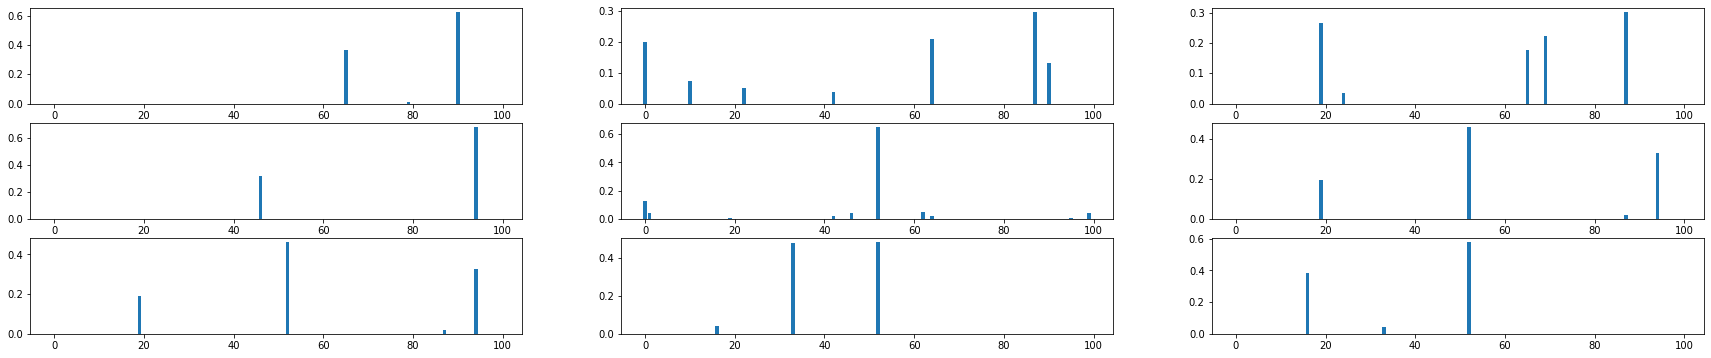

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_HATS_matcnt30_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


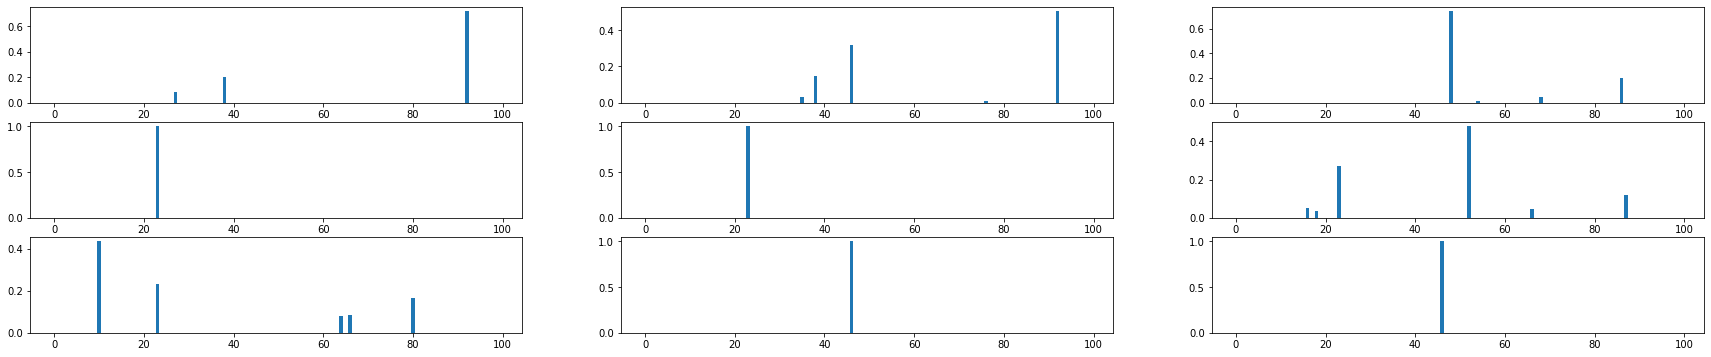

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_HATS_matcnt30_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


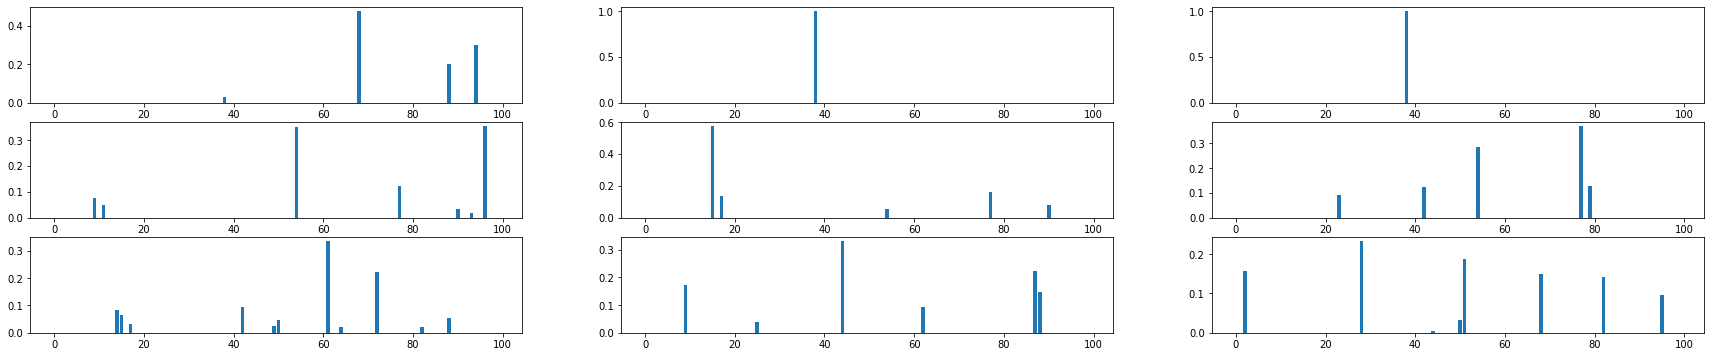

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_HATS_matcnt30_invTrue_ggdTrue.npz
G4P


In [ ]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True', 'matcnt':30, 
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

In [ ]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

In [ ]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True', 'matcnt':30, 
       'c':0.001, 'rf':0.0007, 'gamma':0.0, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.15
    Sharpe ratio: 0.92 ± 0.55
    Ulcer index: 1.89
    Information ratio (wrt UCRP): 0.43
    Appraisal ratio (wrt UCRP): 0.26 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.24 / 8.677%
    Annualized return: 30.64%
    Annualized volatility: 35.87%
    Longest drawdown: 466 days
    Max drawdown: 43.40%
    Winning days: 52.4%
    Annual turnover: 327.6
        
Total wealth: 3.570244476868789


<Figure size 720x360 with 0 Axes>

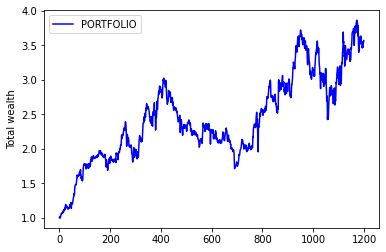

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.76
    Sharpe ratio: -1.36 ± 0.63
    Ulcer index: -0.68
    Information ratio (wrt UCRP): -2.18
    Appraisal ratio (wrt UCRP): -2.23 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.24 / -72.066%
    Annualized return: -41.70%
    Annualized volatility: 35.25%
    Longest drawdown: 1116 days
    Max drawdown: 94.21%
    Winning days: 44.0%
    Annual turnover: 327.6
        
Total wealth: 0.07657657401472648


<Figure size 720x360 with 0 Axes>

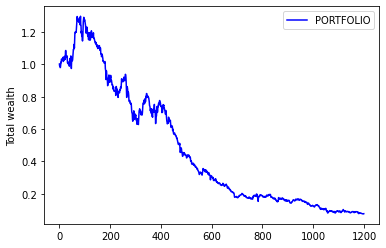

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.51
    Sharpe ratio: -3.67 ± 1.27
    Ulcer index: -1.51
    Information ratio (wrt UCRP): -4.83
    Appraisal ratio (wrt UCRP): -4.76 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.23 / -152.810%
    Annualized return: -74.09%
    Annualized volatility: 35.04%
    Longest drawdown: 1129 days
    Max drawdown: 99.85%
    Winning days: 37.6%
    Annual turnover: 327.6
        
Total wealth: 0.0016109815487599787


<Figure size 432x288 with 0 Axes>

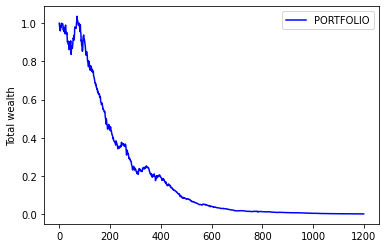

In [11]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

## No graph + GGD

    #!/bin/bash

    maxiter=5000
    subn=100
    lb=5
    M=20
    inverse='True'
    ggd='True'
    matid=''

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
            python main2.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat${matcnt}_subn${subn}_lb5_s5_log${i}.log
    done

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


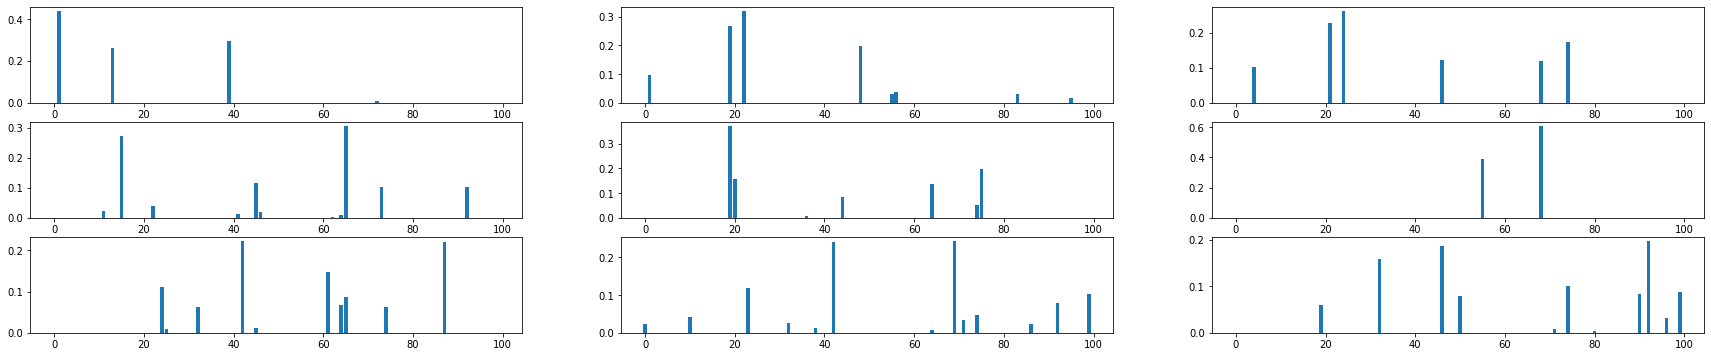

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


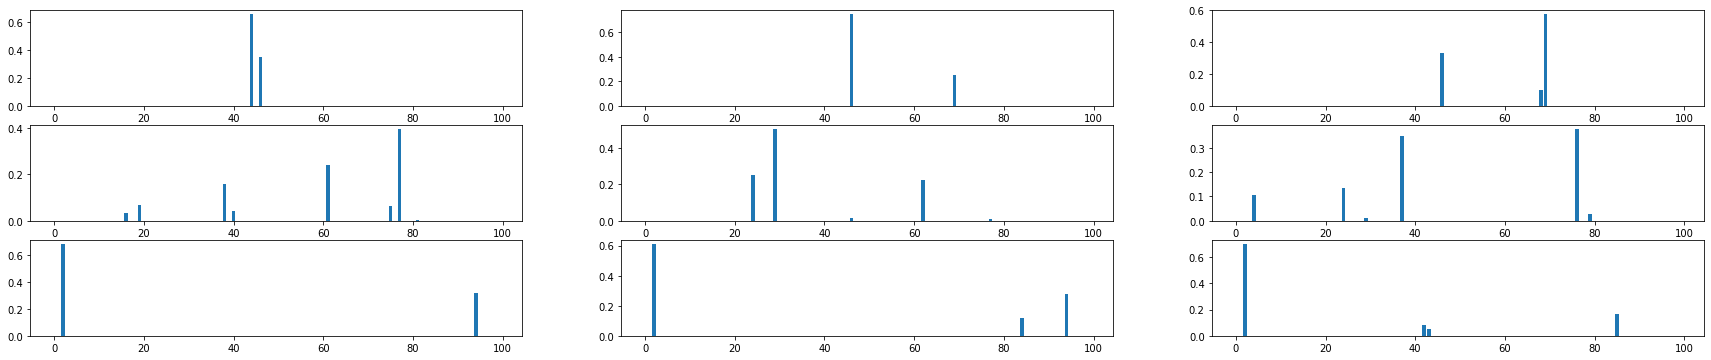

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


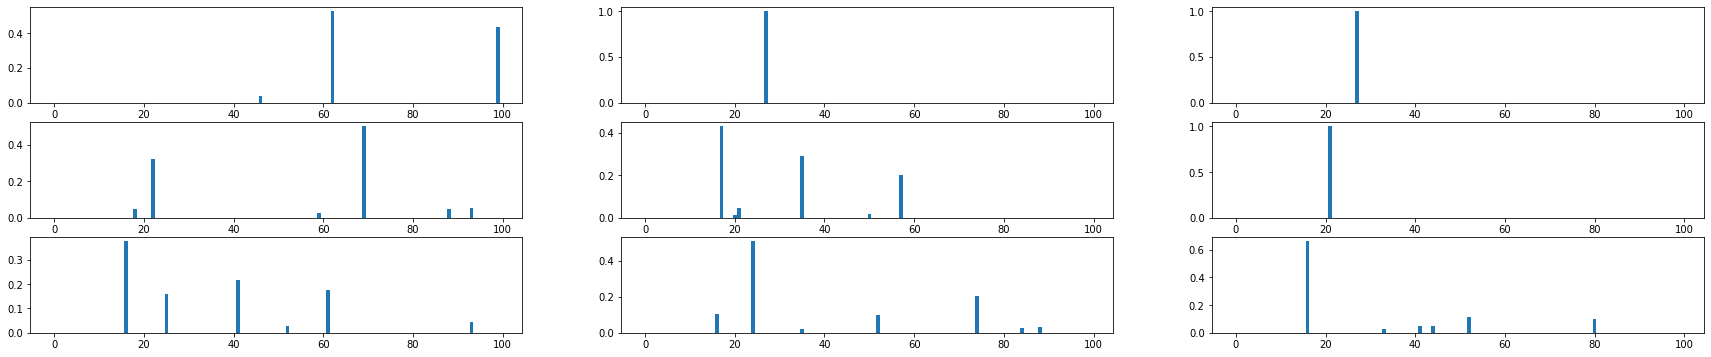

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


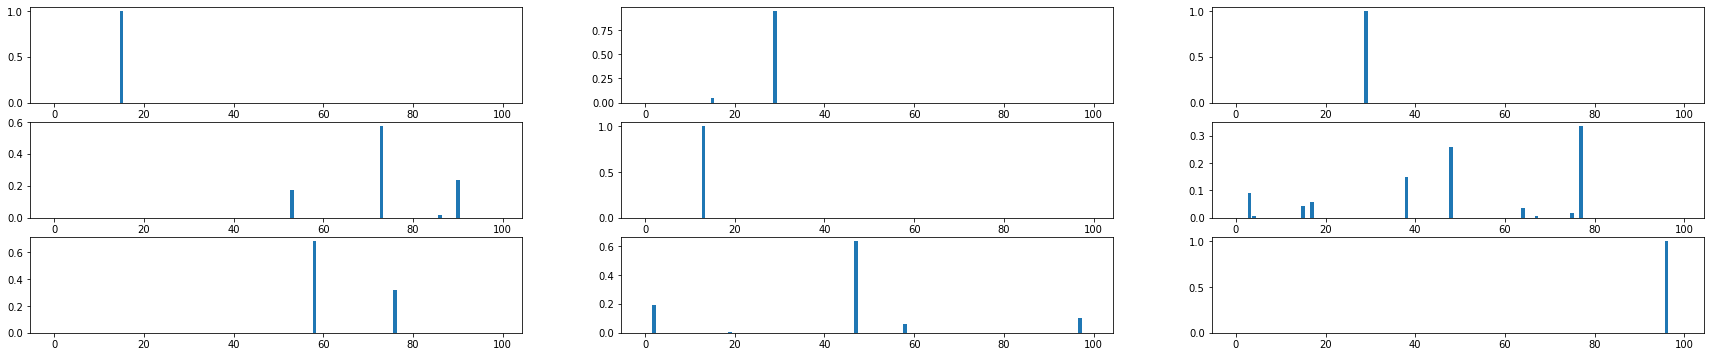

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


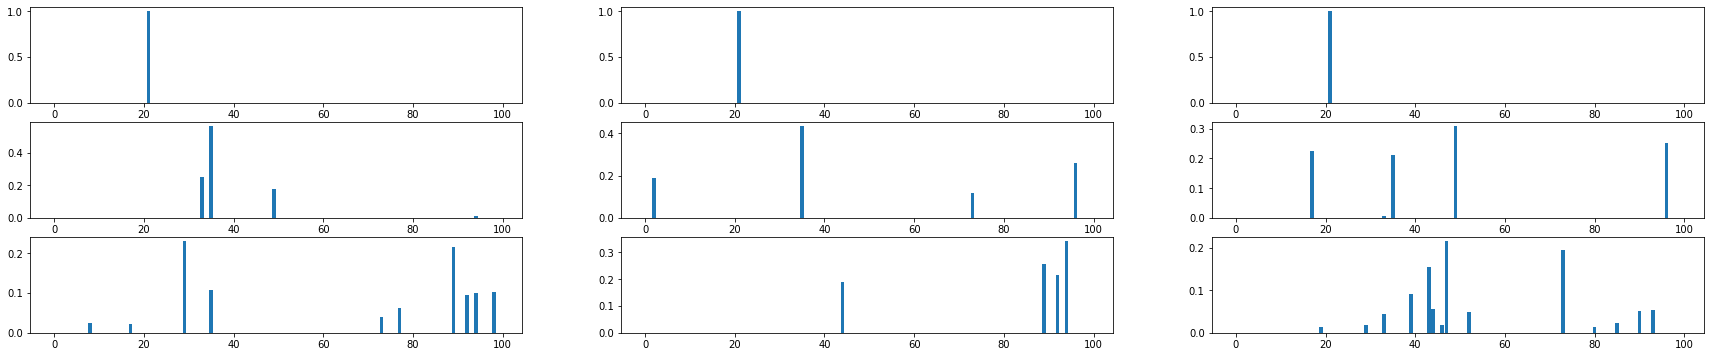

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


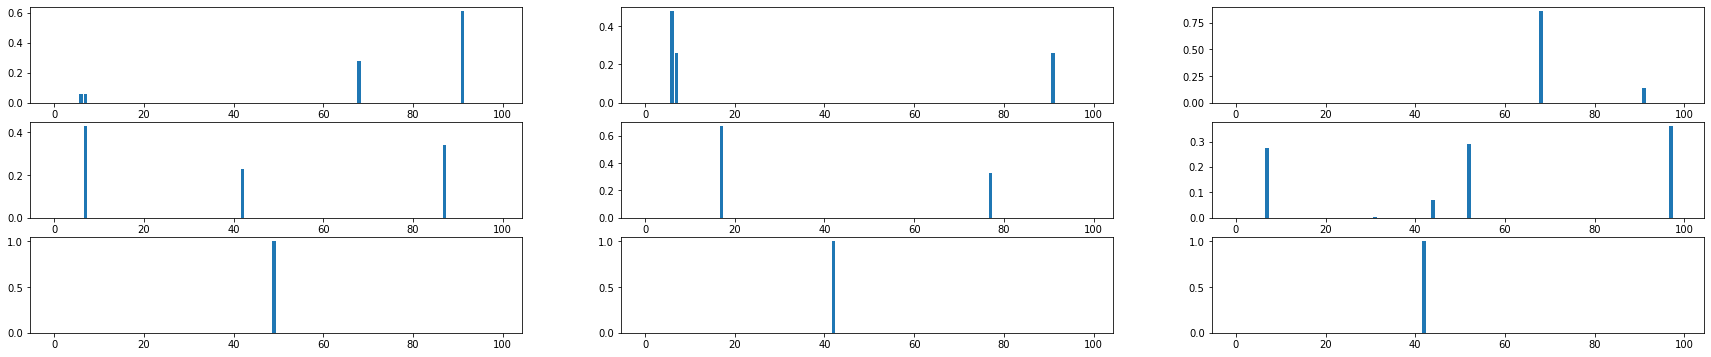

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


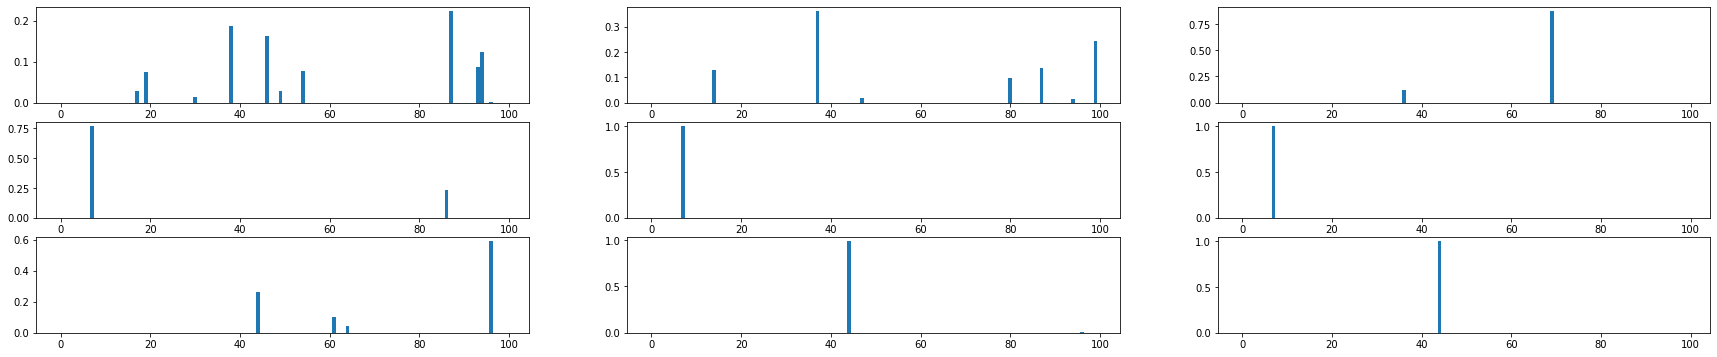

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


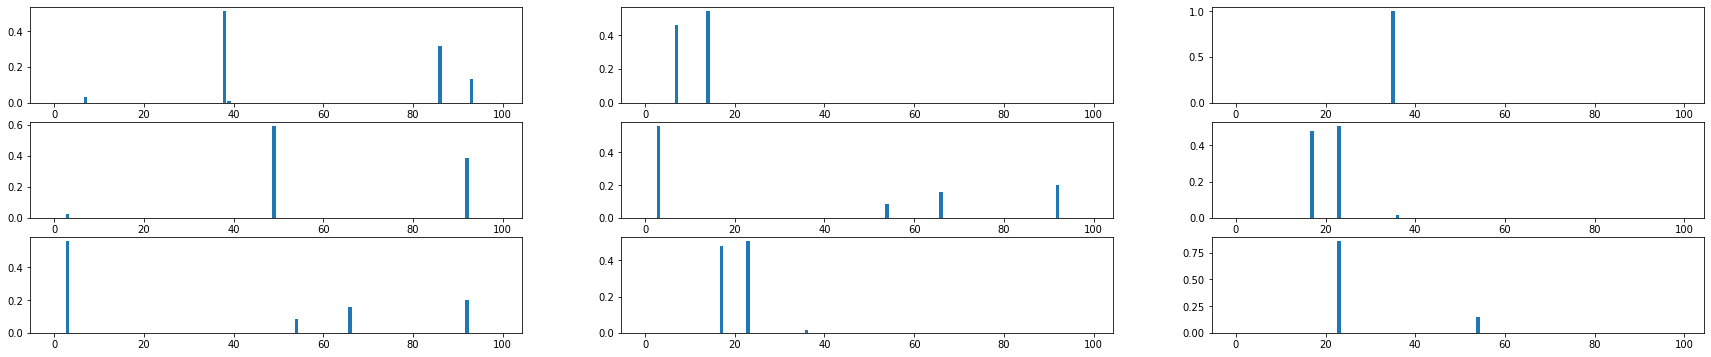

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


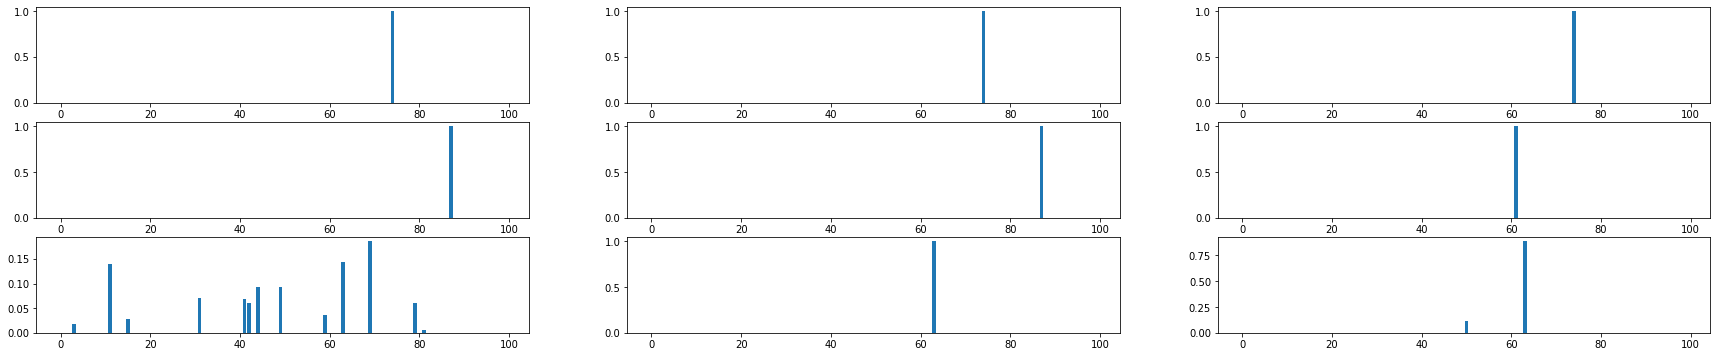

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


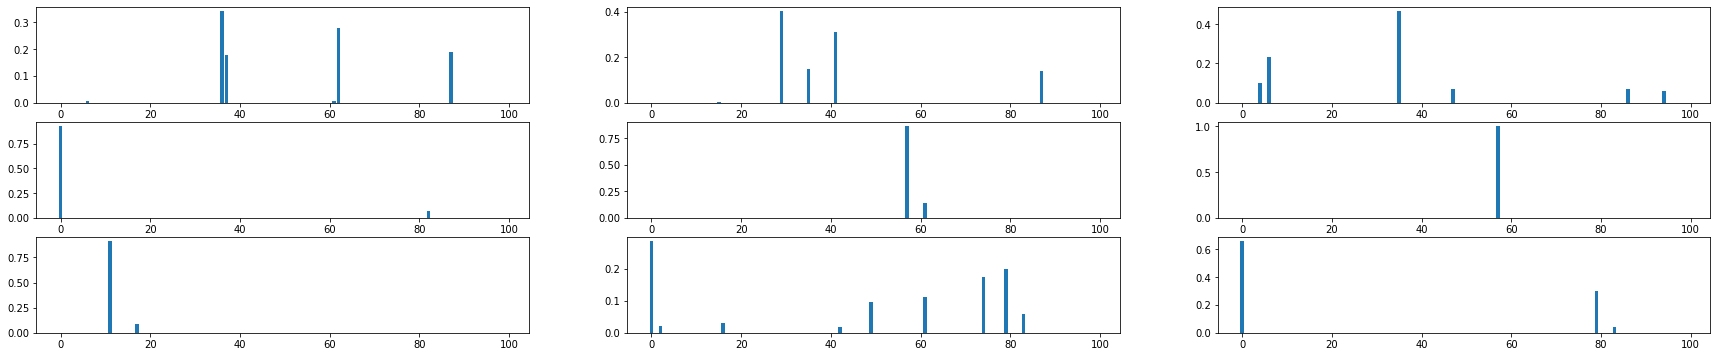

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


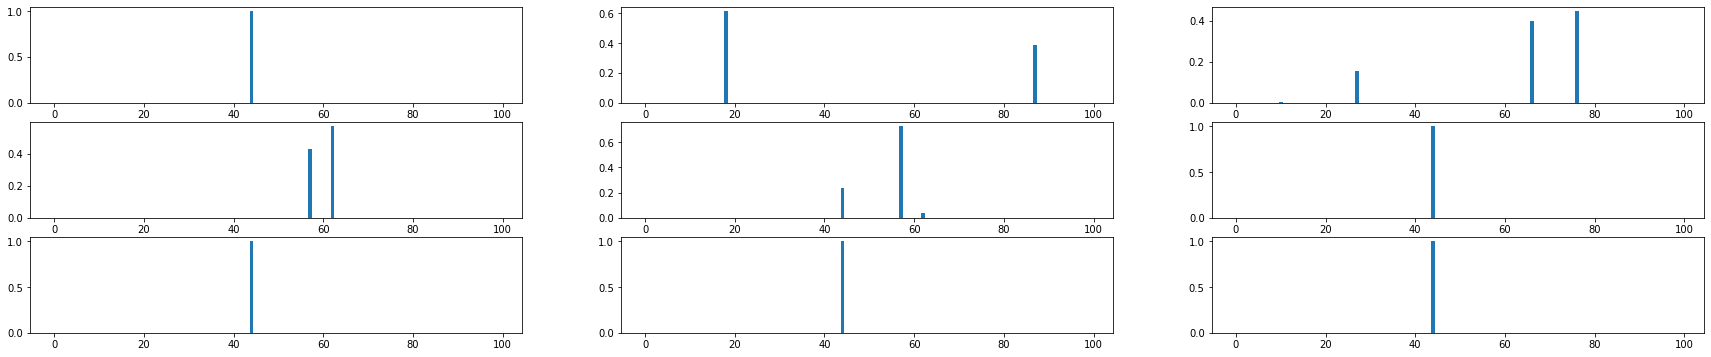

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_HATS_matcnt0_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


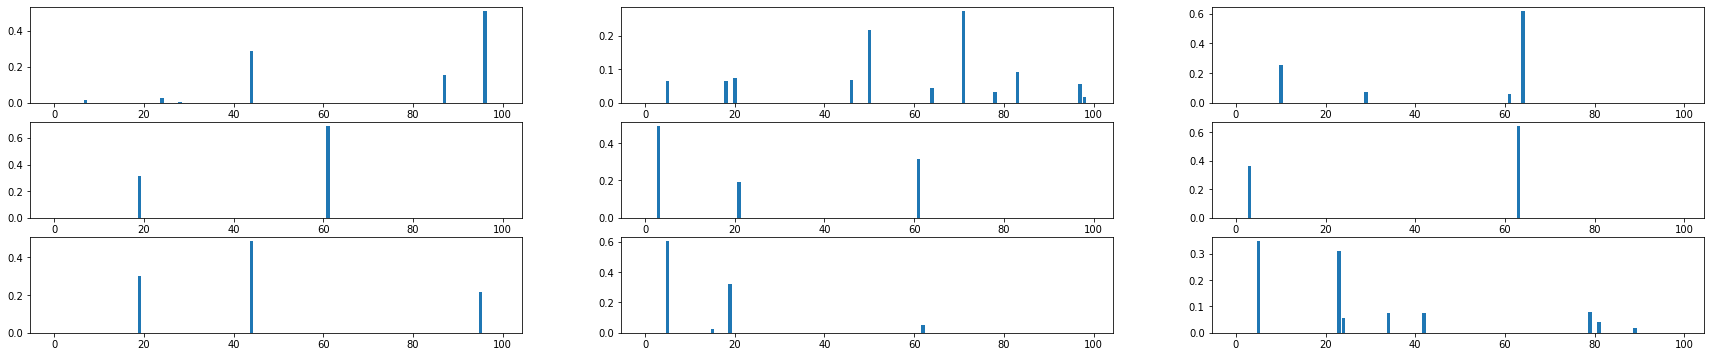

In [24]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True', 'matcnt':0, 
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0, 'passive_gamma':0.0,
       'mattype':0, 'dg':0
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.21
    Sharpe ratio: 1.16 ± 0.59
    Ulcer index: 3.64
    Information ratio (wrt UCRP): 0.65
    Appraisal ratio (wrt UCRP): 0.46 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / 13.326%
    Annualized return: 38.11%
    Annualized volatility: 32.15%
    Longest drawdown: 391 days
    Max drawdown: 30.37%
    Winning days: 55.0%
    Annual turnover: 331.8
        
Total wealth: 4.652912106888318


<Figure size 720x360 with 0 Axes>

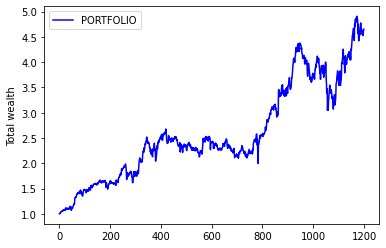

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.41 ± 0.65
    Ulcer index: -0.67
    Information ratio (wrt UCRP): -2.40
    Appraisal ratio (wrt UCRP): -2.43 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -68.582%
    Annualized return: -39.07%
    Annualized volatility: 31.64%
    Longest drawdown: 1130 days
    Max drawdown: 91.65%
    Winning days: 42.9%
    Annual turnover: 331.8
        
Total wealth: 0.0944561721390175


<Figure size 720x360 with 0 Axes>

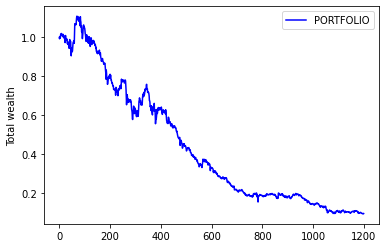

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.47
    Sharpe ratio: -4.04 ± 1.39
    Ulcer index: -1.47
    Information ratio (wrt UCRP): -5.52
    Appraisal ratio (wrt UCRP): -5.39 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -150.490%
    Annualized return: -73.22%
    Annualized volatility: 31.35%
    Longest drawdown: 1199 days
    Max drawdown: 99.81%
    Winning days: 34.5%
    Annual turnover: 331.8
        
Total wealth: 0.0018864348433350474


<Figure size 432x288 with 0 Axes>

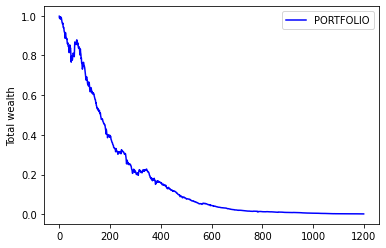

In [25]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

# Pearson 

## Pearson 0.85 + GGD

    maxiter=2000
    subn=100
    lb=5
    M=10
    inverse='True'
    ggd='True'
    matid='-1 0.85'

    matcnt=$(echo ${matid} | wc -w)
    for i in `seq 0 11`;
    # for i in 10;
    do
        echo "phase $i"
        python main3.py --phase $i --maxiter ${maxiter} --subn ${subn} --lb ${lb} --inverse ${inverse} --matid ${matid} --M ${M} --ggd ${ggd} --gpu 1  > ./log/main2_noval_inv${inverse}_ggd${ggd}_M${M}_iter${maxiter}_mat_pearson_subn${subn}_lb5_s5_log${i}.log
    done

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


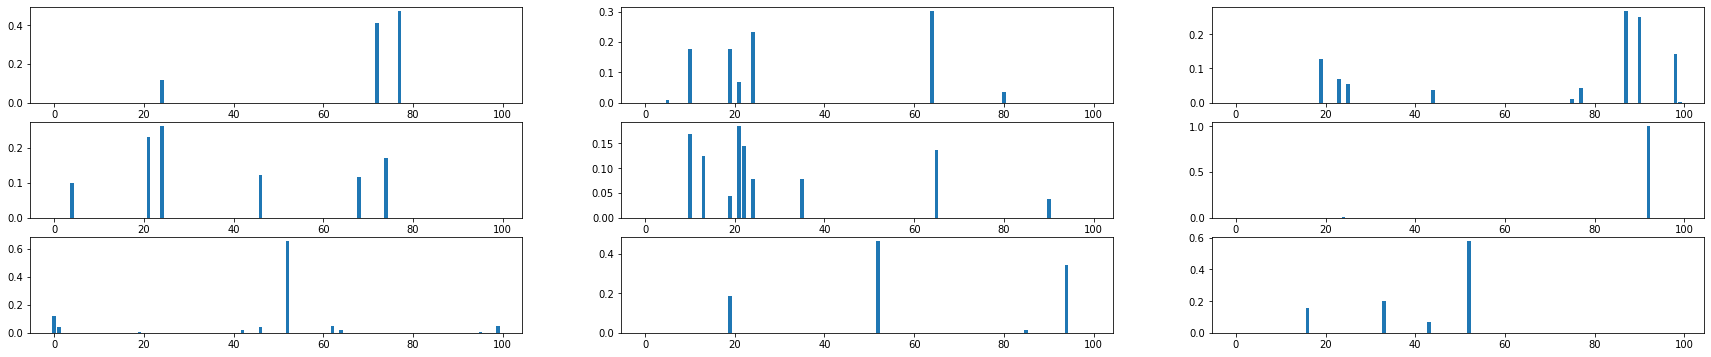

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


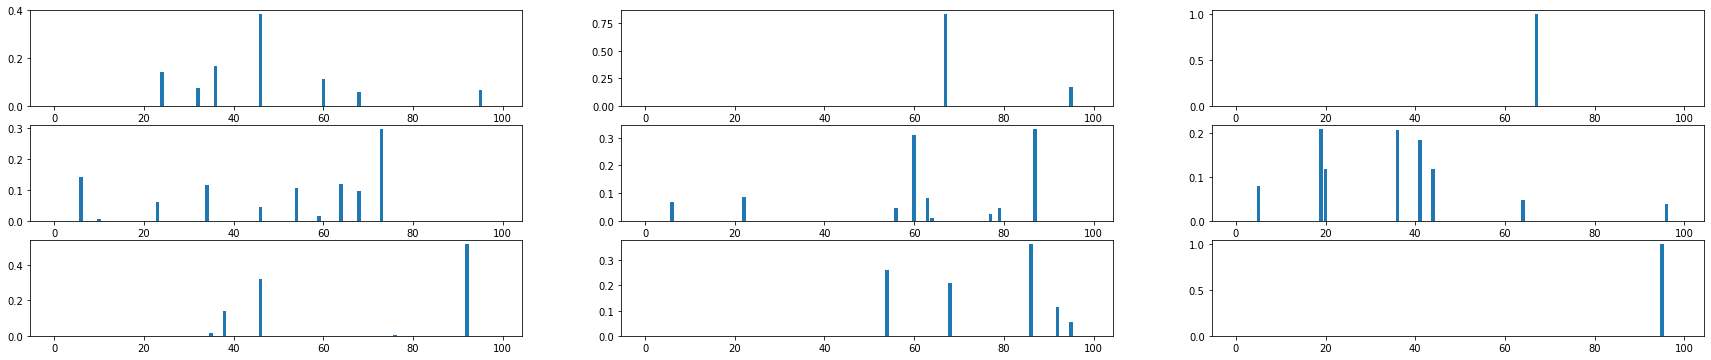

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


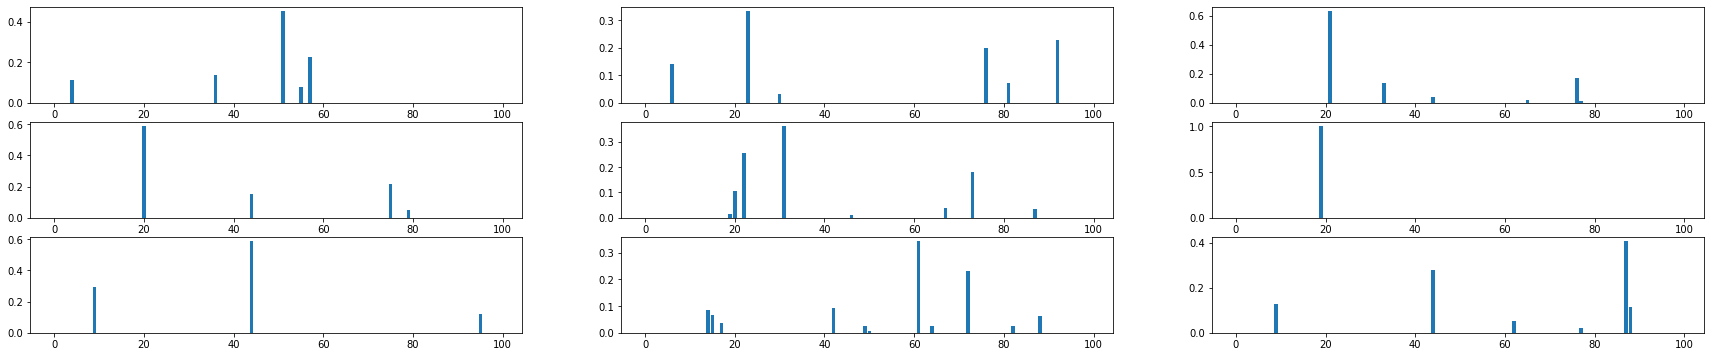

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


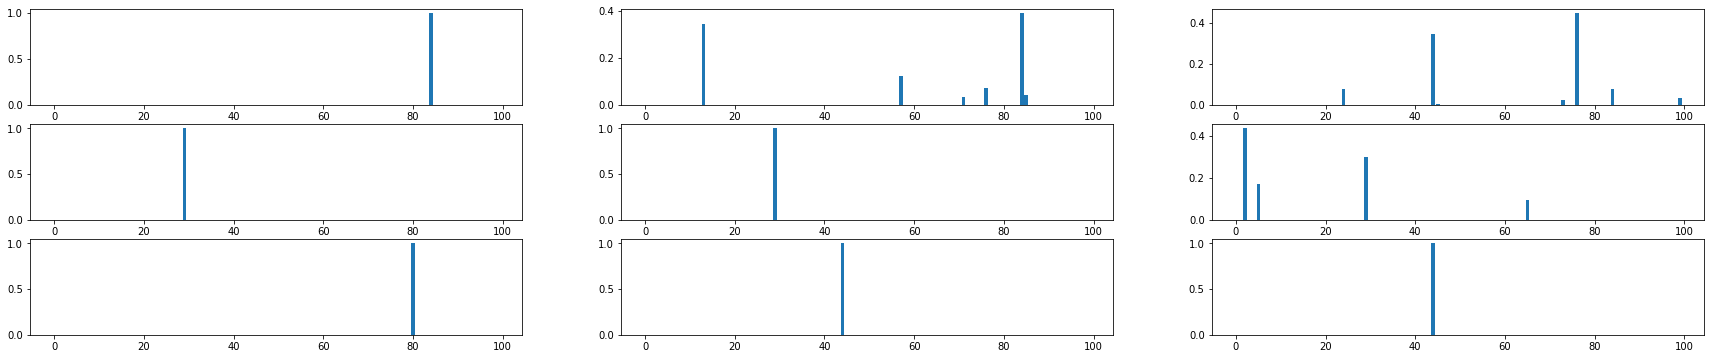

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


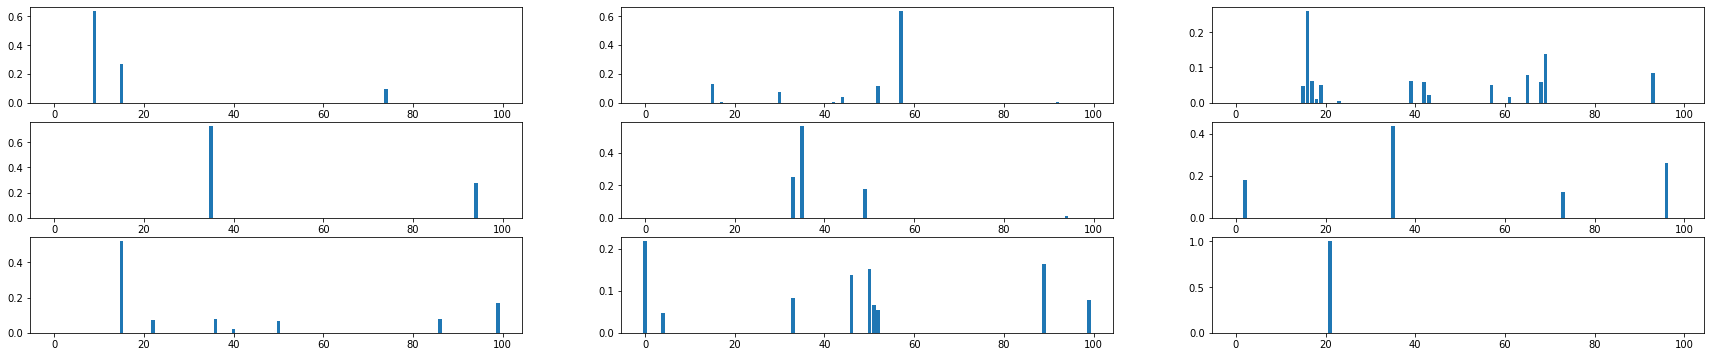

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


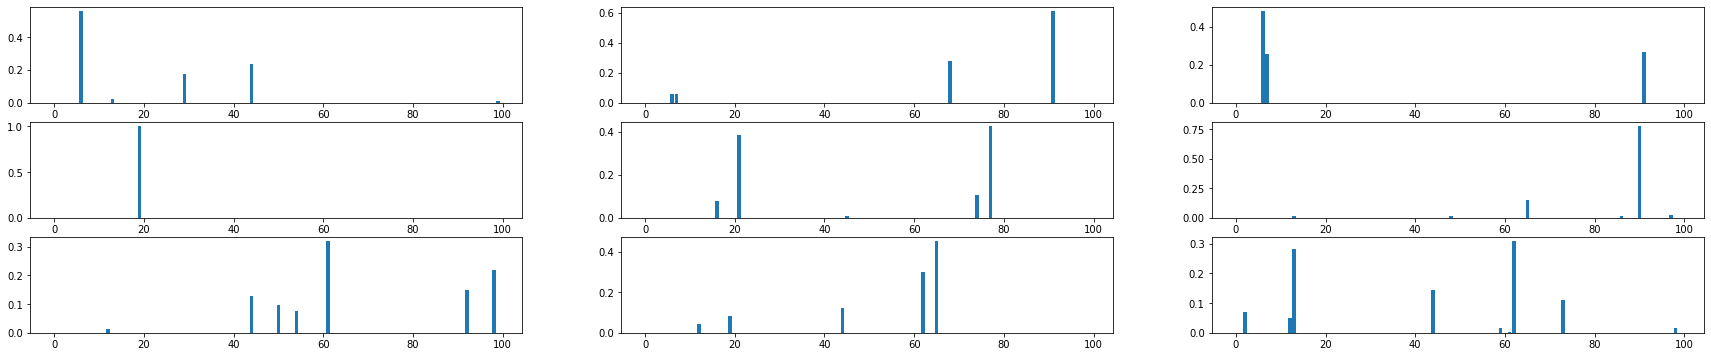

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


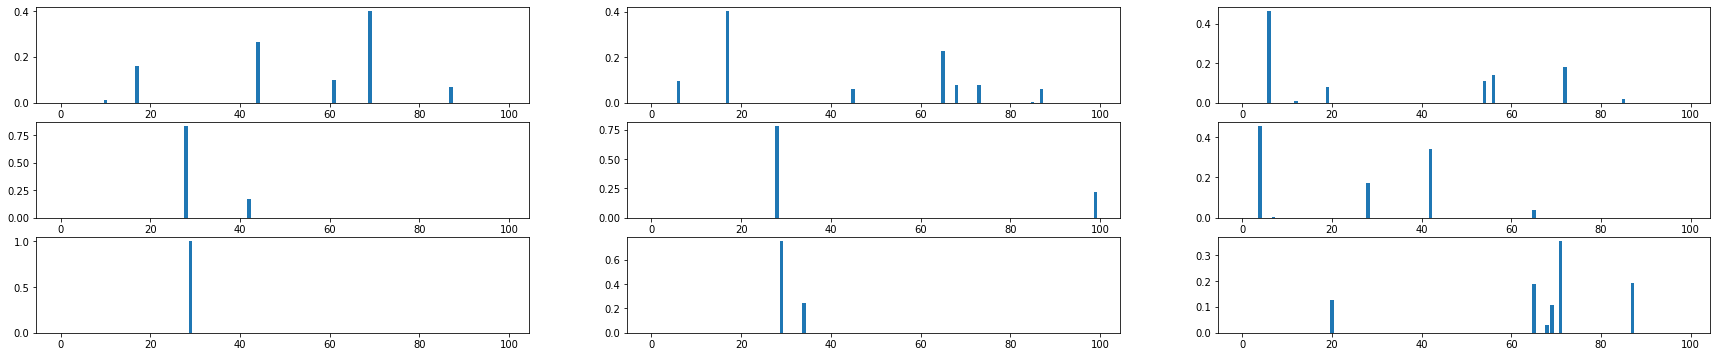

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


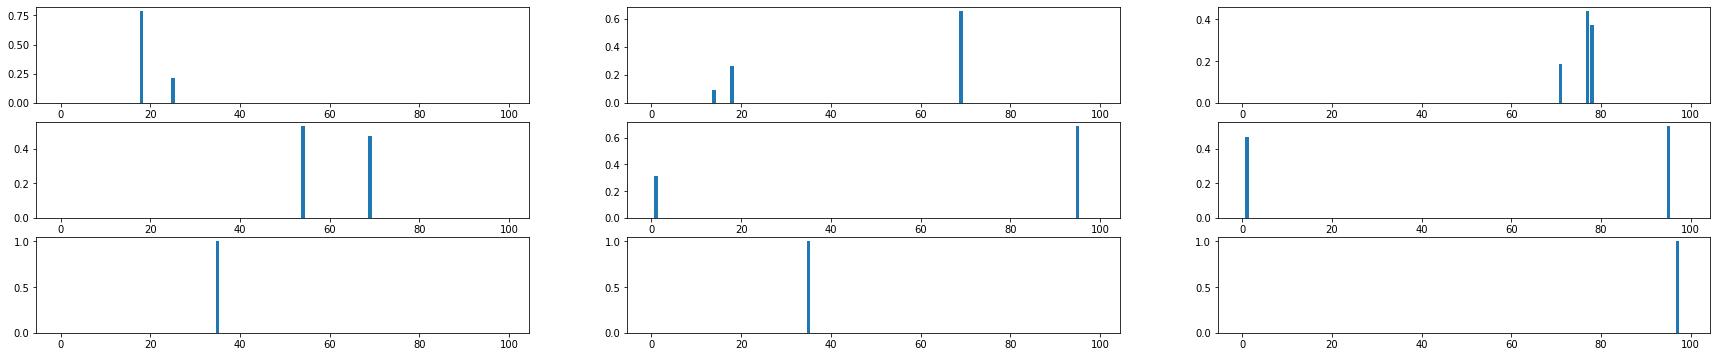

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


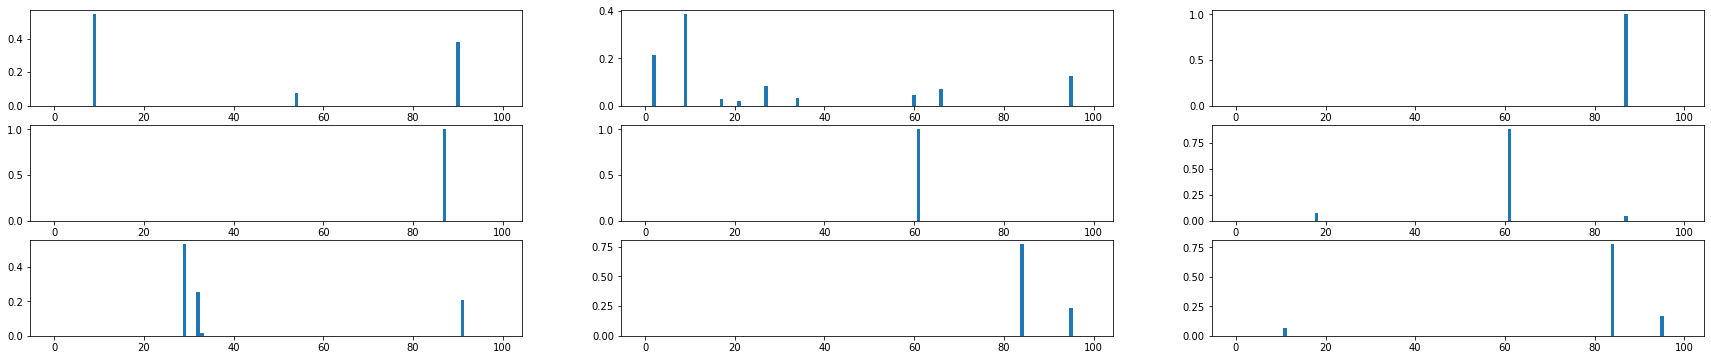

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


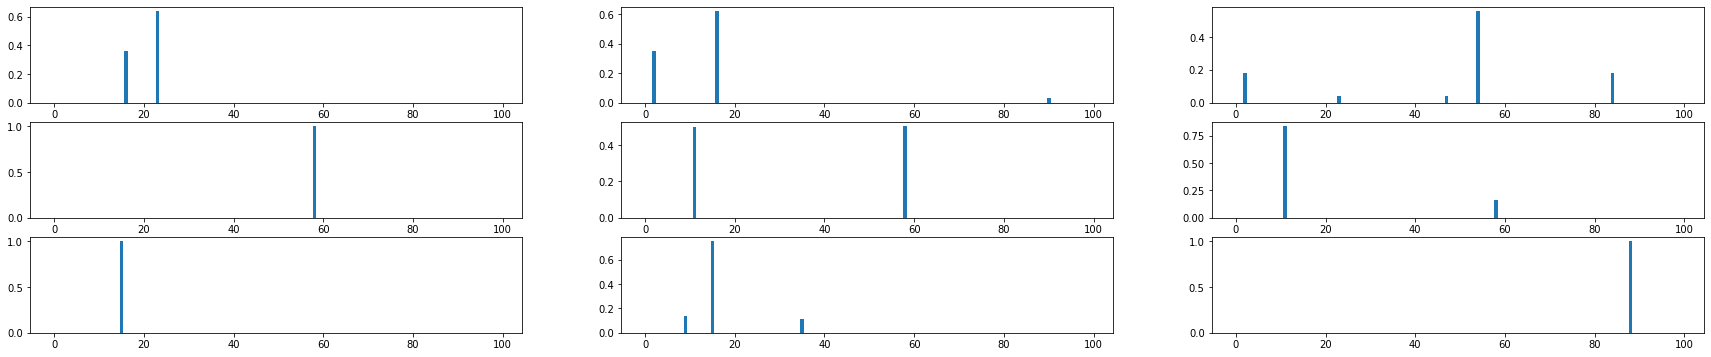

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


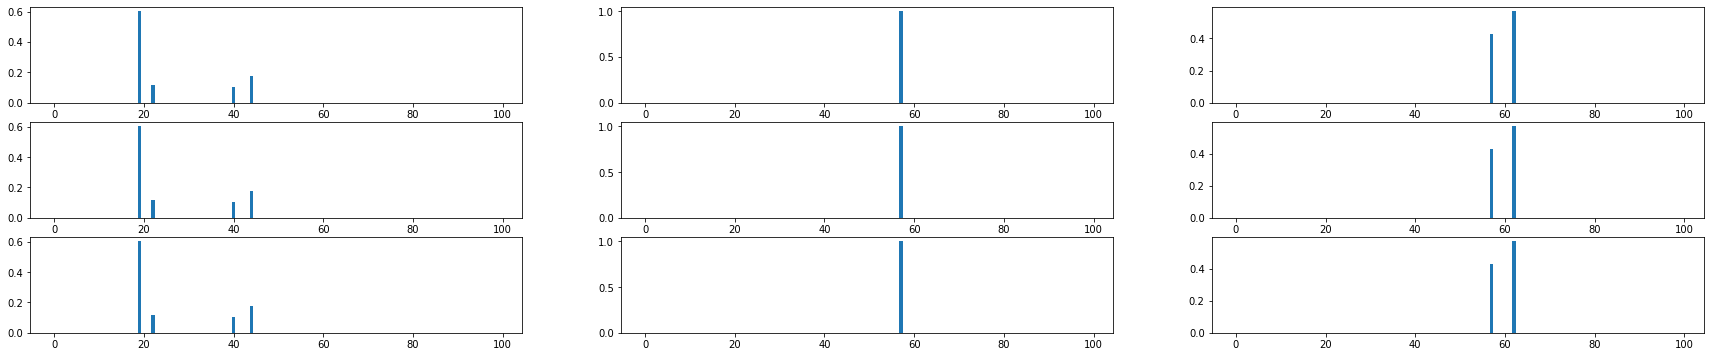

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_pearson_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


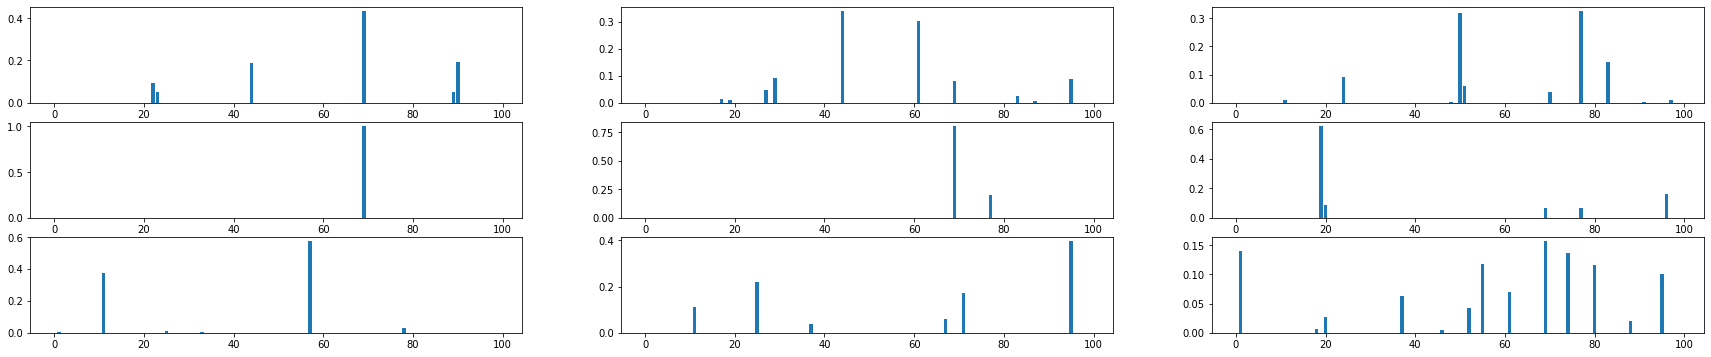

In [44]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':-1, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.21
    Sharpe ratio: 1.16 ± 0.59
    Ulcer index: 3.61
    Information ratio (wrt UCRP): 0.65
    Appraisal ratio (wrt UCRP): 0.47 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / 13.417%
    Annualized return: 38.20%
    Annualized volatility: 32.15%
    Longest drawdown: 391 days
    Max drawdown: 30.41%
    Winning days: 55.0%
    Annual turnover: 331.9
        
Total wealth: 4.667969229402522


<Figure size 720x360 with 0 Axes>

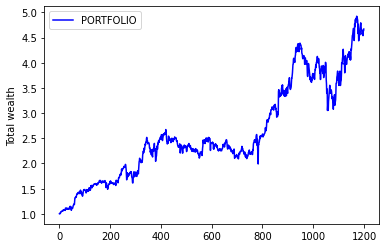

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.41 ± 0.65
    Ulcer index: -0.67
    Information ratio (wrt UCRP): -2.39
    Appraisal ratio (wrt UCRP): -2.43 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -68.514%
    Annualized return: -39.04%
    Annualized volatility: 31.63%
    Longest drawdown: 1130 days
    Max drawdown: 91.63%
    Winning days: 43.0%
    Annual turnover: 331.9
        
Total wealth: 0.09467493370210256


<Figure size 720x360 with 0 Axes>

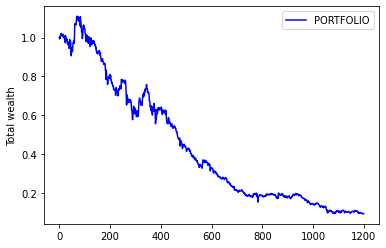

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.47
    Sharpe ratio: -4.04 ± 1.39
    Ulcer index: -1.47
    Information ratio (wrt UCRP): -5.52
    Appraisal ratio (wrt UCRP): -5.39 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -150.444%
    Annualized return: -73.21%
    Annualized volatility: 31.35%
    Longest drawdown: 1199 days
    Max drawdown: 99.81%
    Winning days: 34.4%
    Annual turnover: 331.9
        
Total wealth: 0.0018890479452508607


<Figure size 432x288 with 0 Axes>

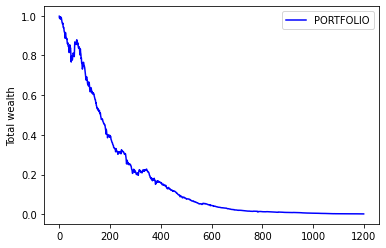

In [45]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

# Spearman

## Spearman 0.85 + GGD

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


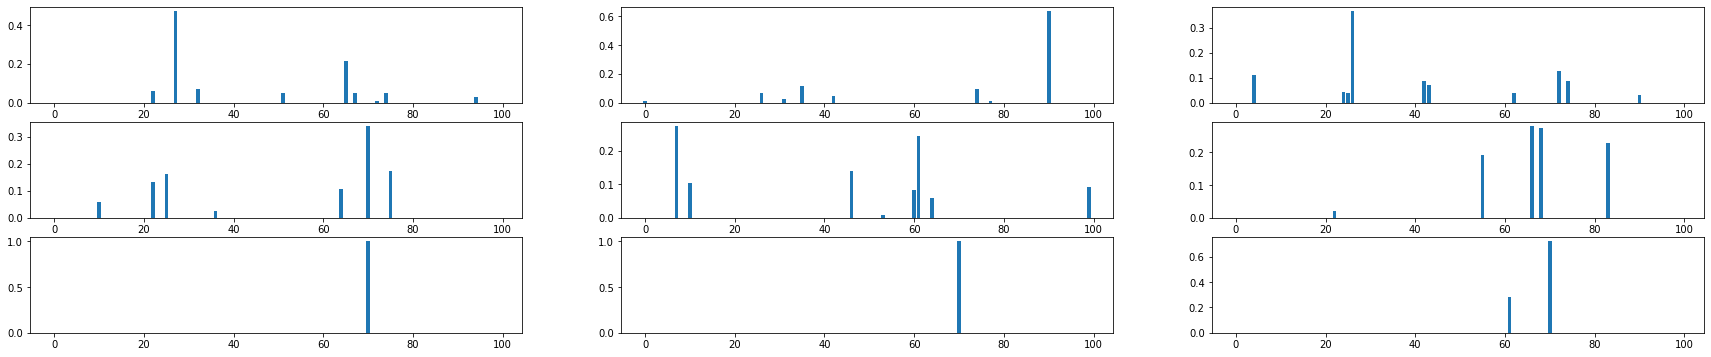

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


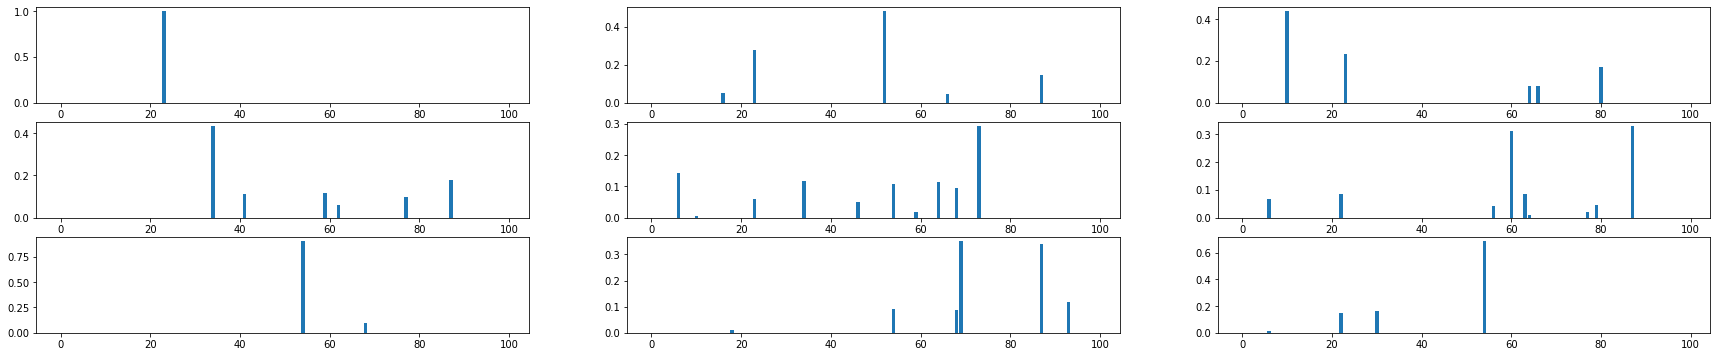

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


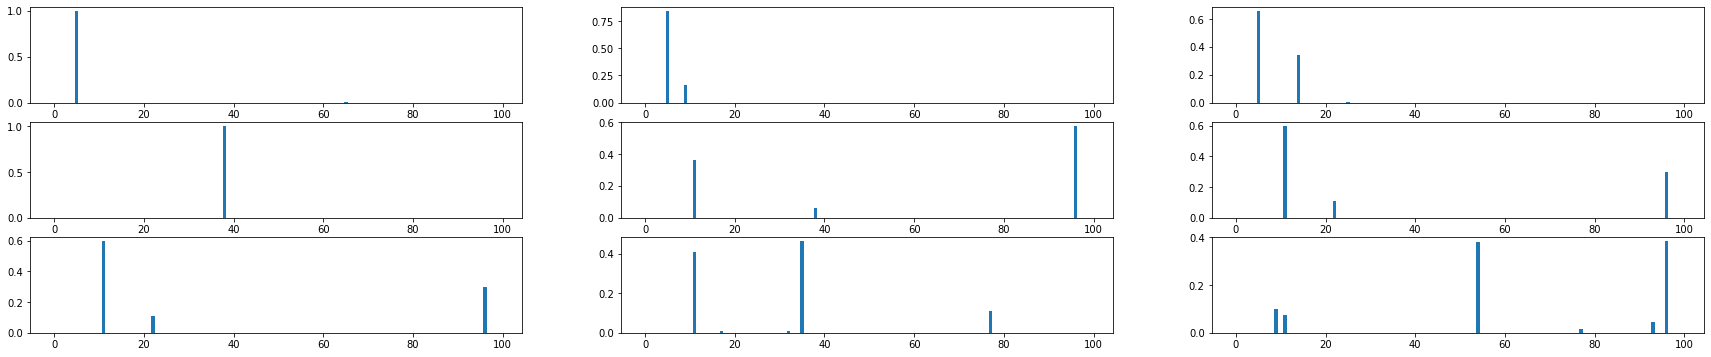

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


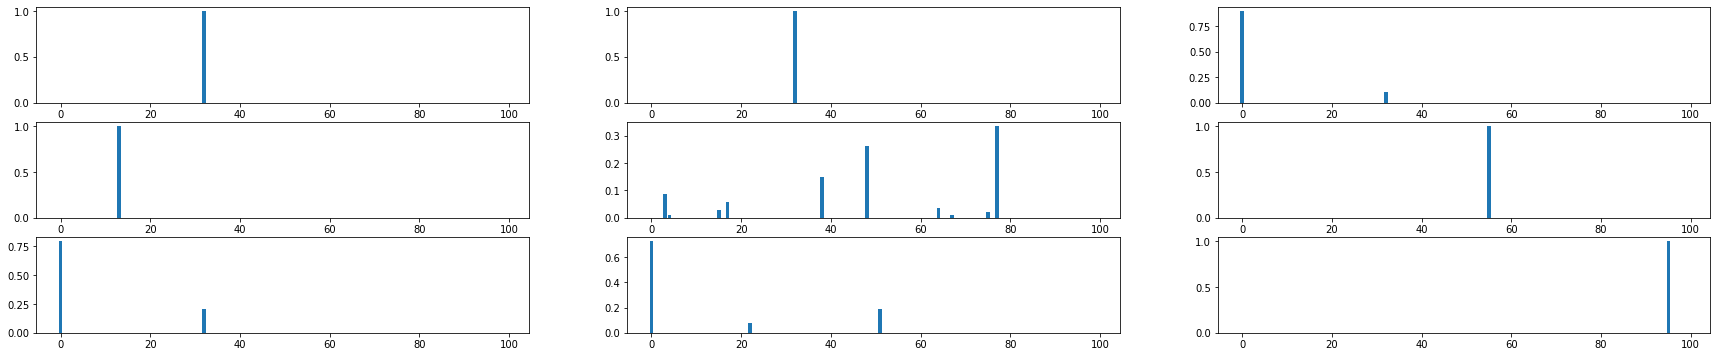

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


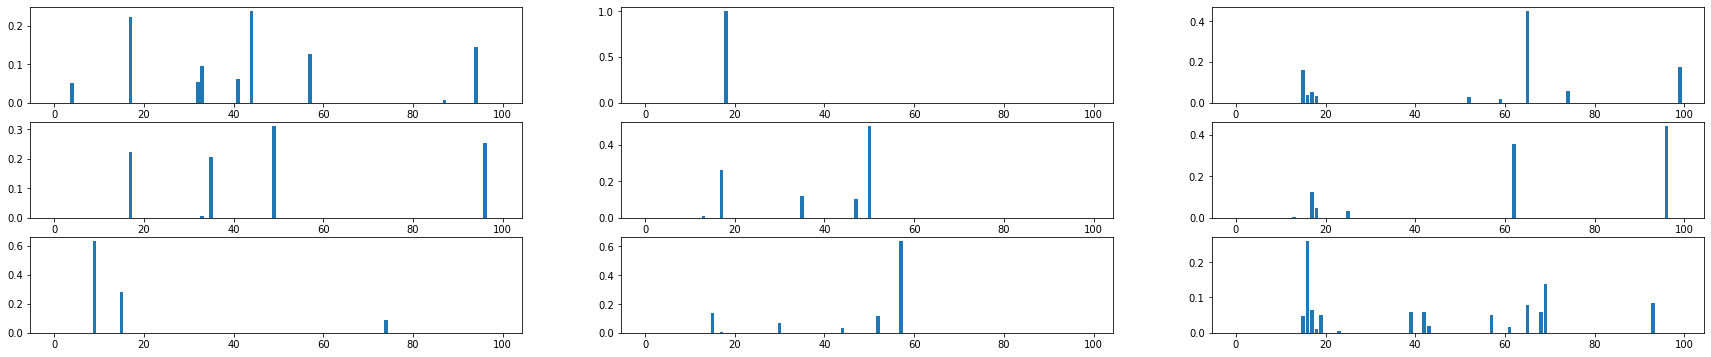

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


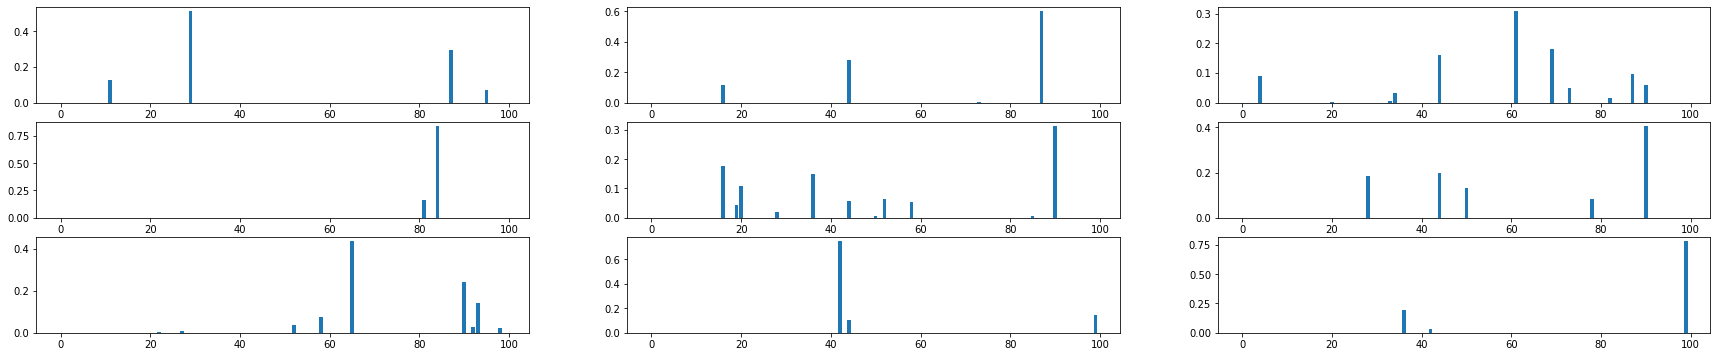

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


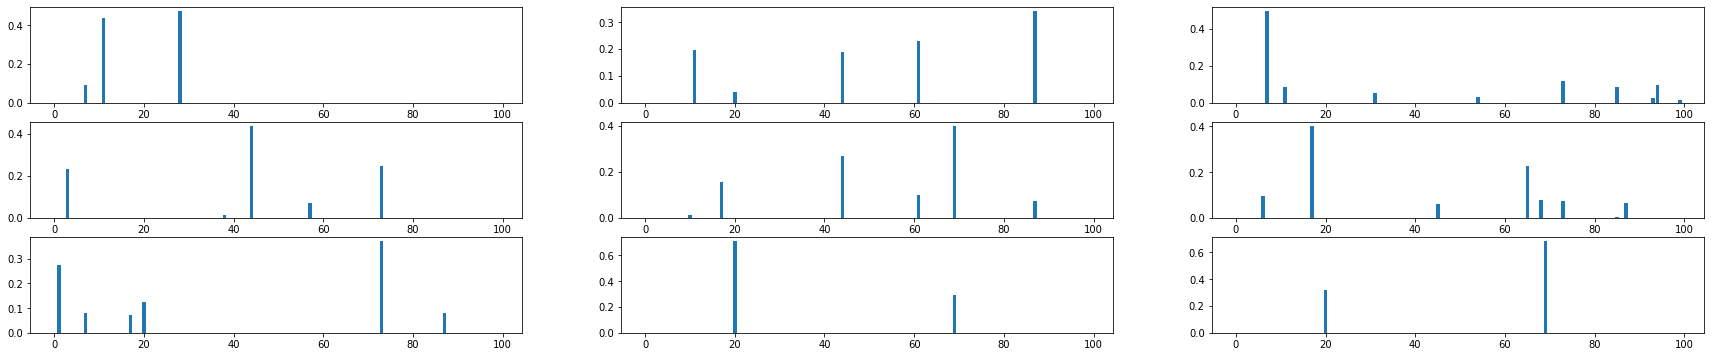

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


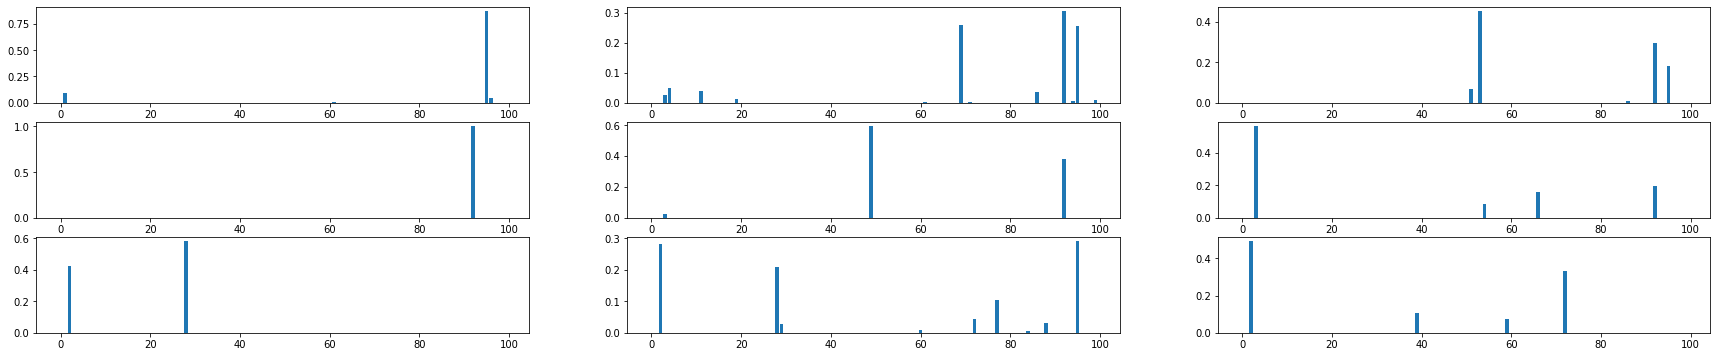

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


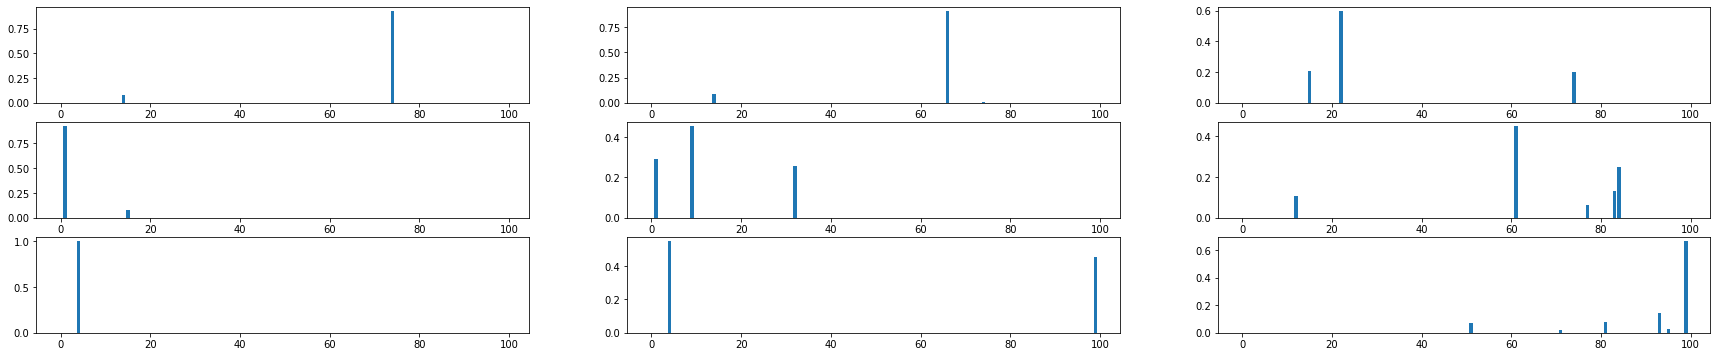

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


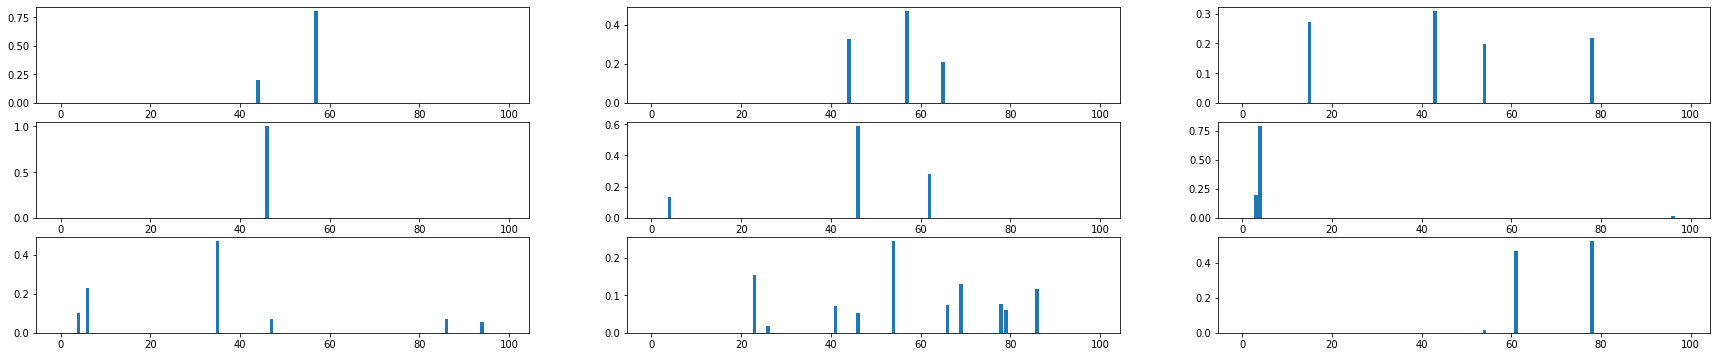

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


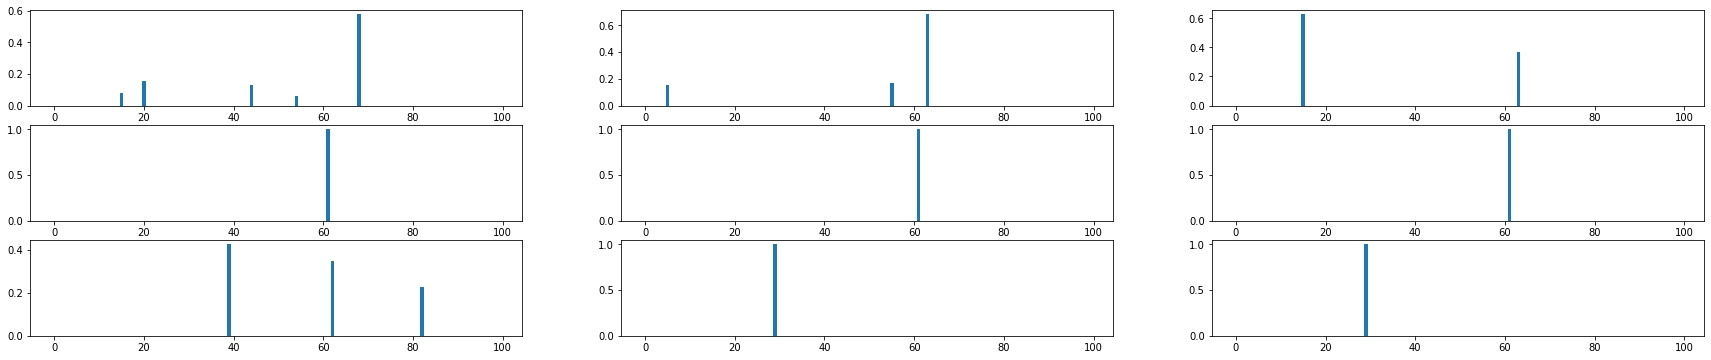

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


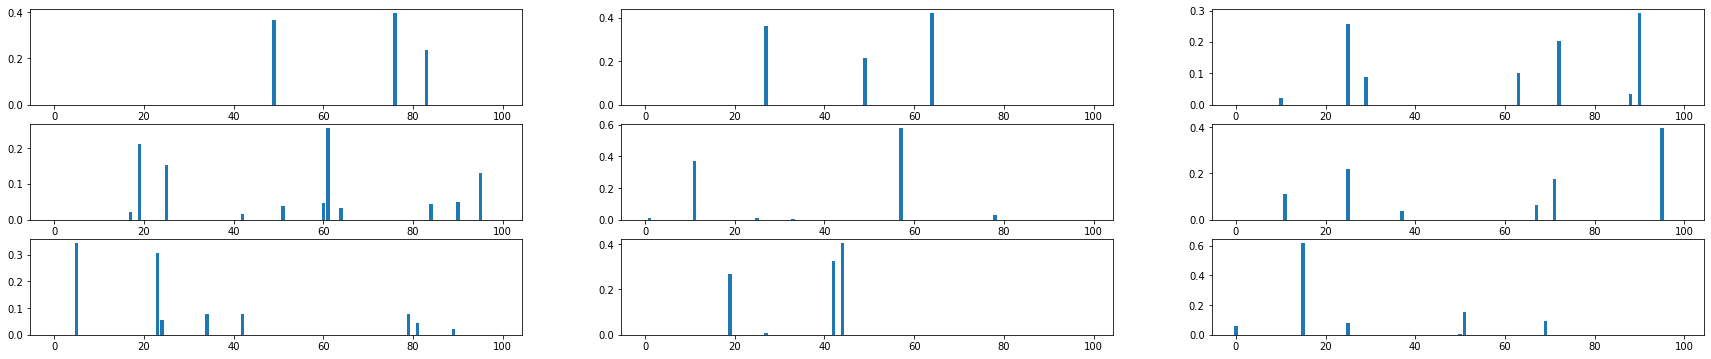

In [46]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.21
    Sharpe ratio: 1.17 ± 0.59
    Ulcer index: 3.73
    Information ratio (wrt UCRP): 0.66
    Appraisal ratio (wrt UCRP): 0.47 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / 13.603%
    Annualized return: 38.44%
    Annualized volatility: 32.13%
    Longest drawdown: 391 days
    Max drawdown: 30.26%
    Winning days: 54.9%
    Annual turnover: 332.0
        
Total wealth: 4.706355578816302


<Figure size 720x360 with 0 Axes>

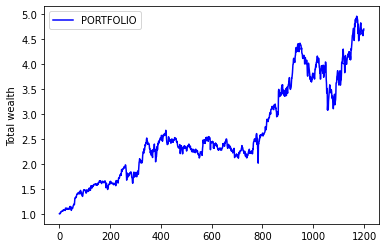

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.40 ± 0.65
    Ulcer index: -0.67
    Information ratio (wrt UCRP): -2.39
    Appraisal ratio (wrt UCRP): -2.42 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -68.350%
    Annualized return: -38.95%
    Annualized volatility: 31.61%
    Longest drawdown: 1130 days
    Max drawdown: 91.57%
    Winning days: 42.9%
    Annual turnover: 332.0
        
Total wealth: 0.09535165296311765


<Figure size 720x360 with 0 Axes>

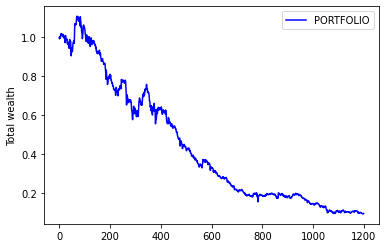

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.47
    Sharpe ratio: -4.03 ± 1.39
    Ulcer index: -1.47
    Information ratio (wrt UCRP): -5.52
    Appraisal ratio (wrt UCRP): -5.39 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -150.303%
    Annualized return: -73.17%
    Annualized volatility: 31.33%
    Longest drawdown: 1199 days
    Max drawdown: 99.81%
    Winning days: 34.5%
    Annual turnover: 332.0
        
Total wealth: 0.0019005105312581568


<Figure size 432x288 with 0 Axes>

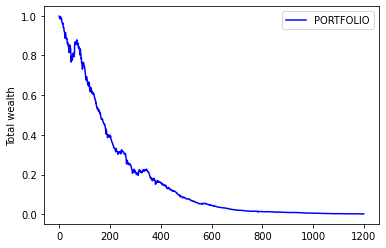

In [47]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

<Figure size 432x288 with 0 Axes>

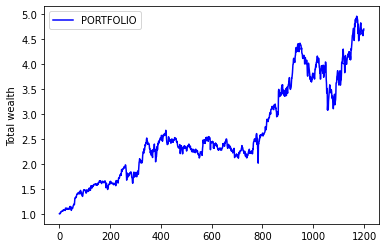

In [54]:
rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
B = pd.DataFrame(B)
Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
result = AlgoResult(Y, B)
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_fee00', ydata)

<Figure size 432x288 with 0 Axes>

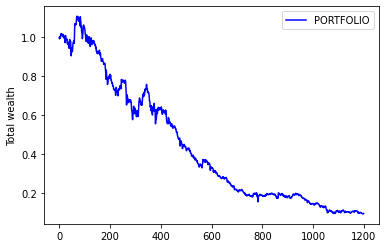

In [55]:
result.fee = 0.0025
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_fee25', ydata)

<Figure size 432x288 with 0 Axes>

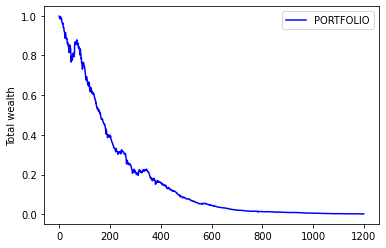

In [56]:
result.fee = 0.005
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_fee50', ydata)

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


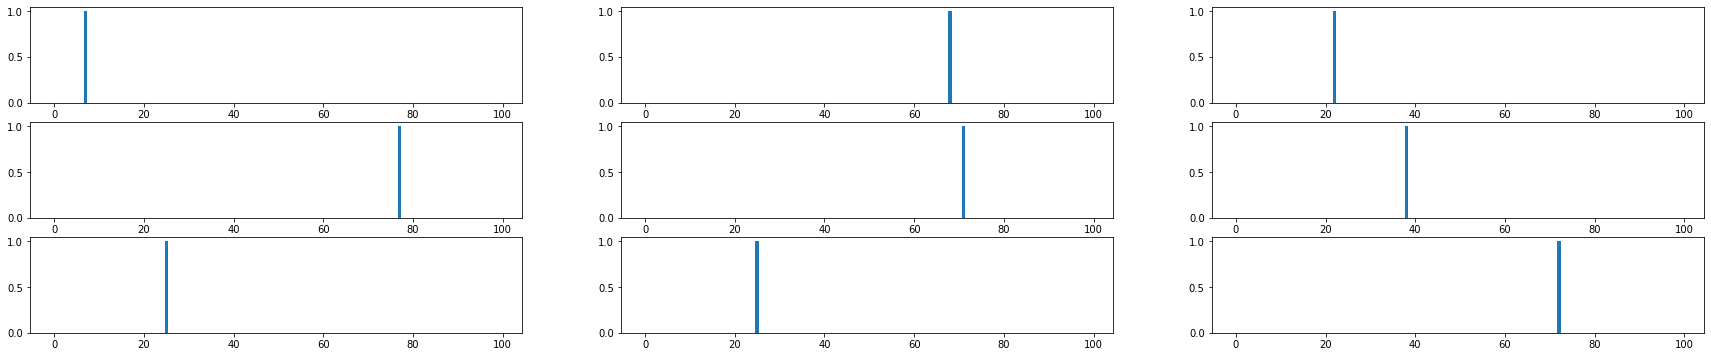

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


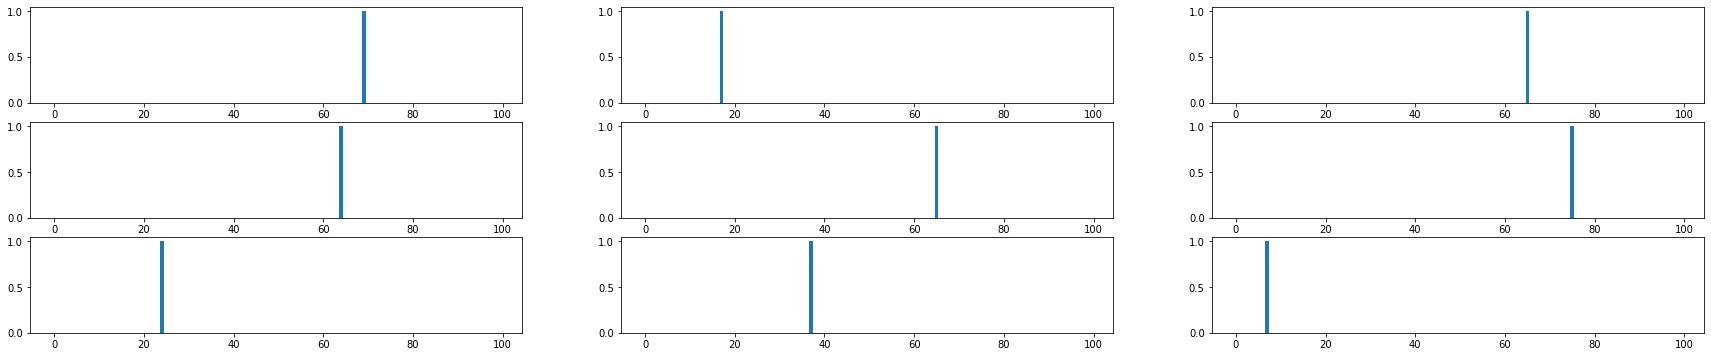

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


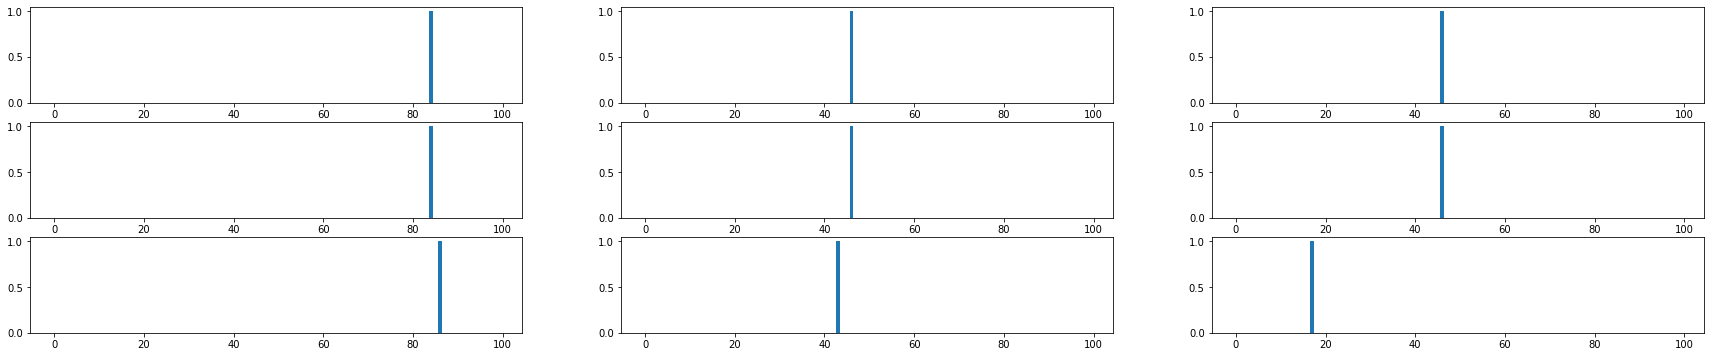

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


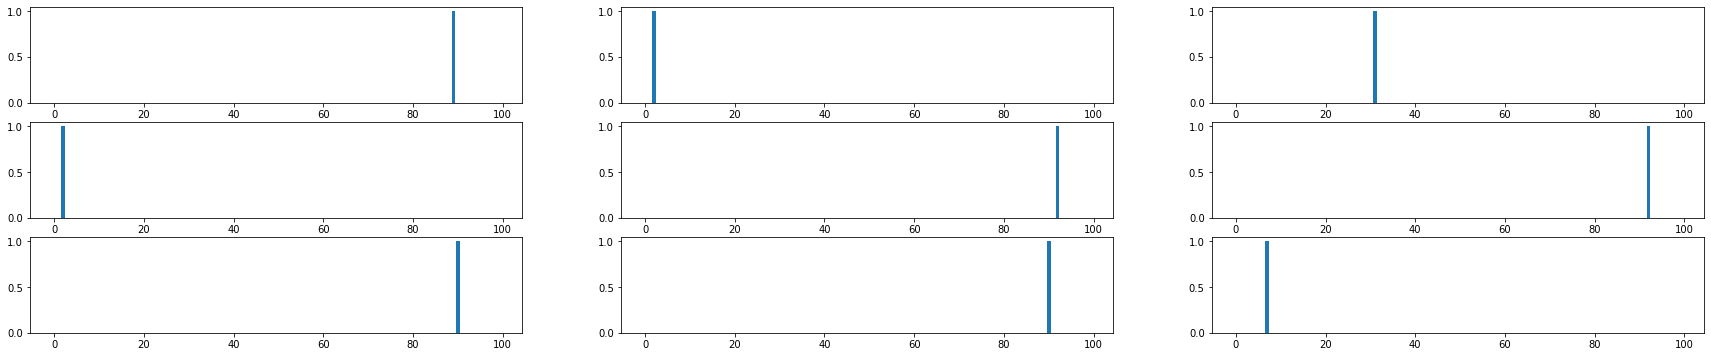

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


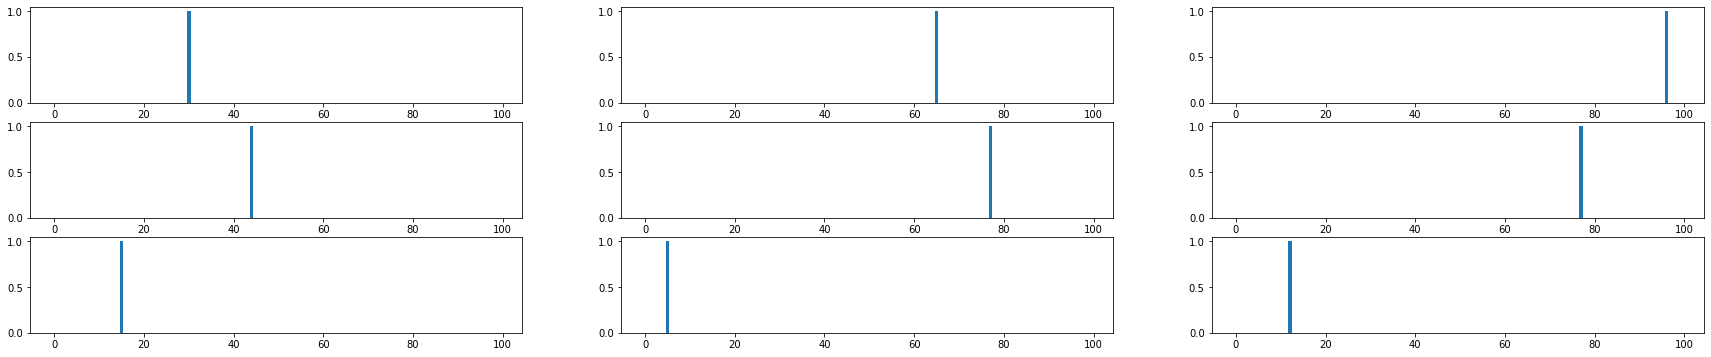

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


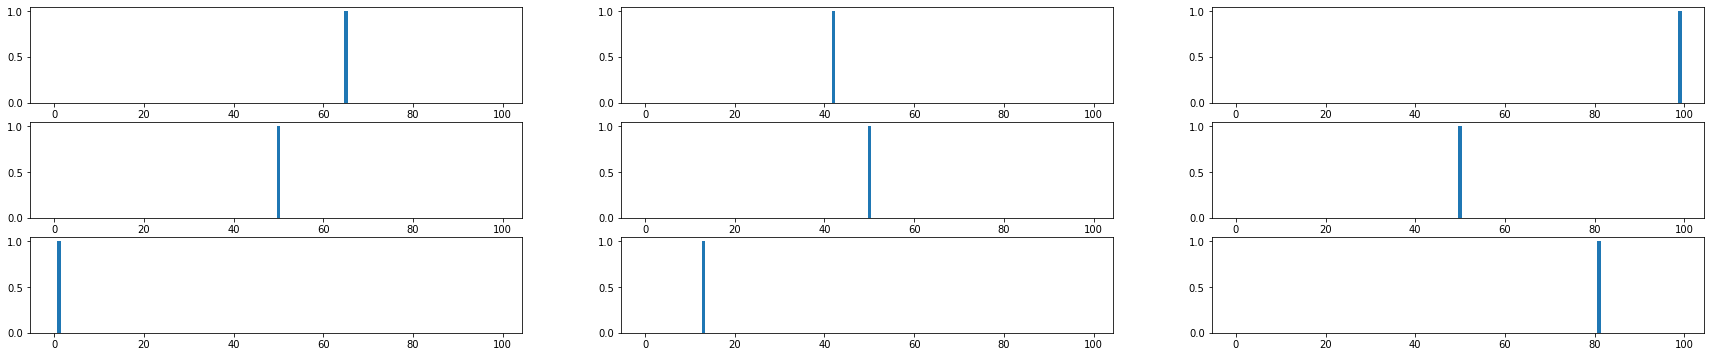

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


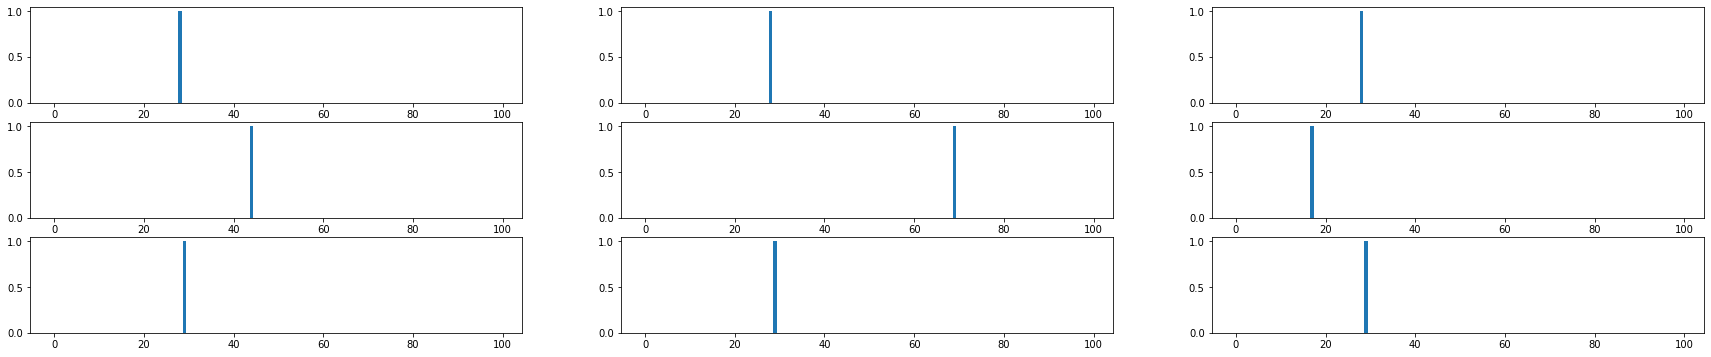

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


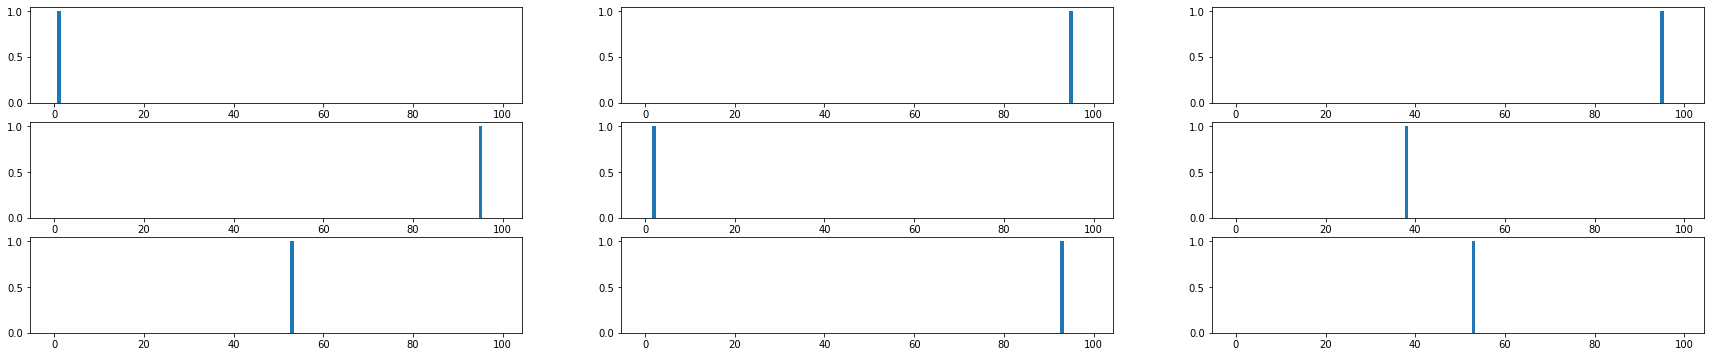

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


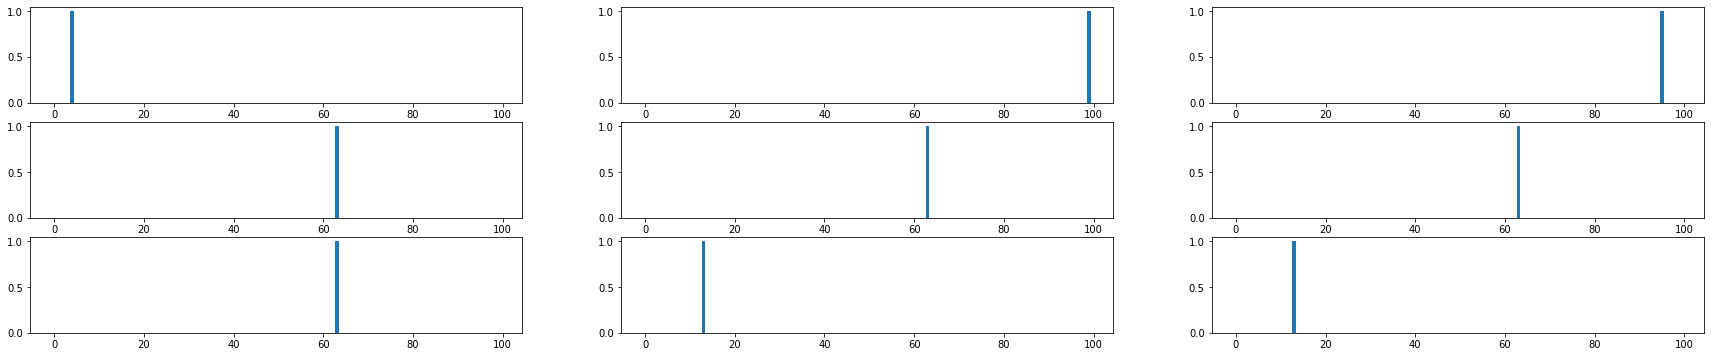

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


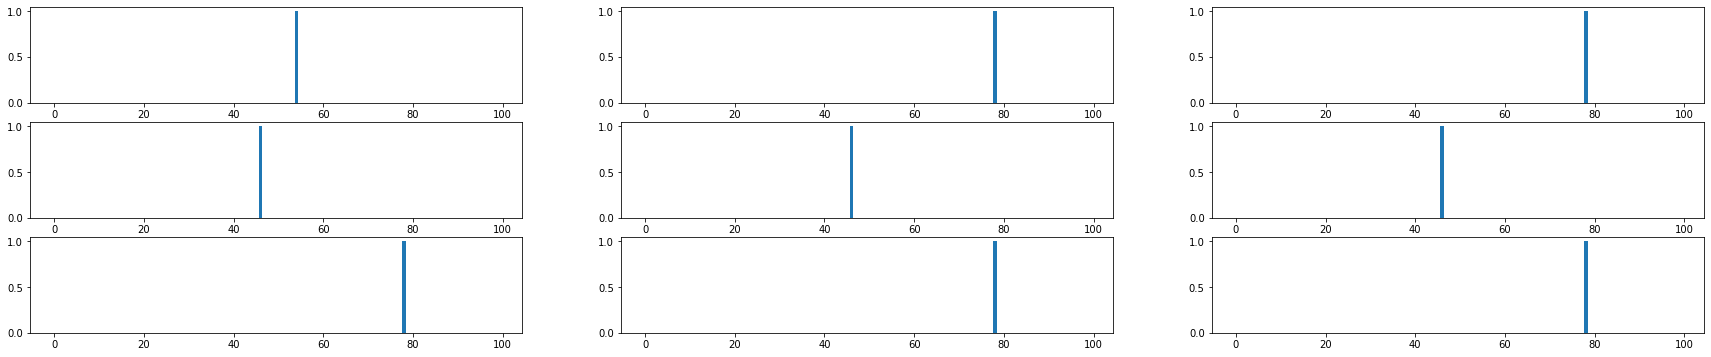

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


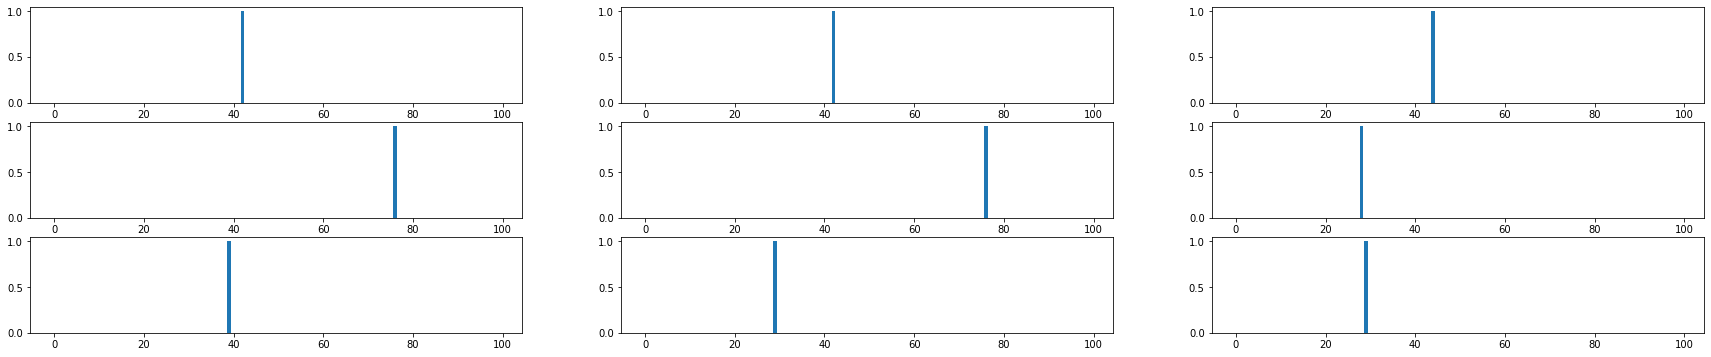

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


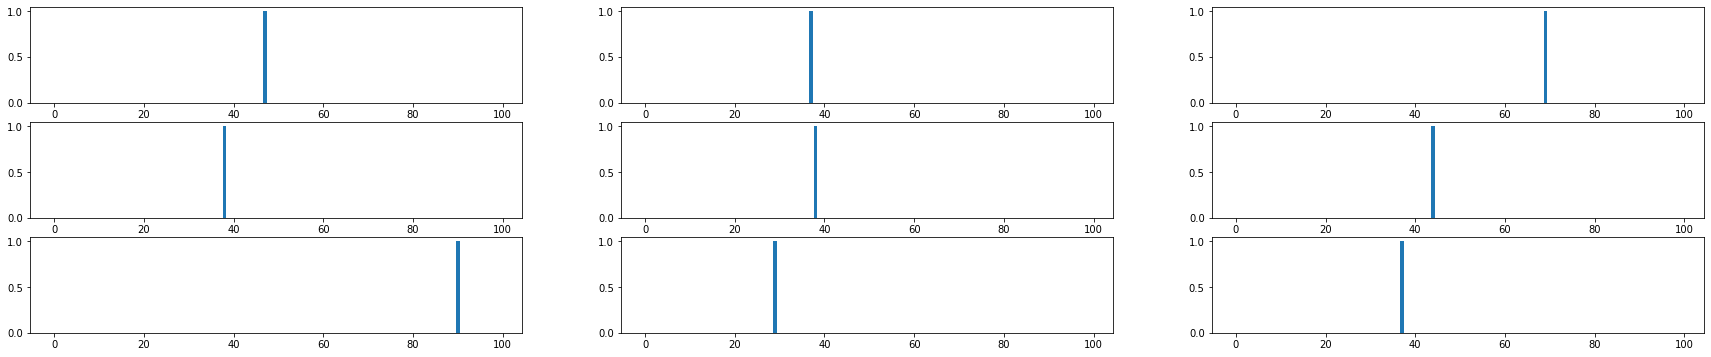

In [29]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.00, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.14
    Sharpe ratio: 0.90 ± 0.54
    Ulcer index: 1.81
    Information ratio (wrt UCRP): 0.38
    Appraisal ratio (wrt UCRP): 0.24 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.21 / 7.818%
    Annualized return: 28.93%
    Annualized volatility: 35.15%
    Longest drawdown: 451 days
    Max drawdown: 39.91%
    Winning days: 52.4%
    Annual turnover: 332.1
        
Total wealth: 3.353273993720321


<Figure size 720x360 with 0 Axes>

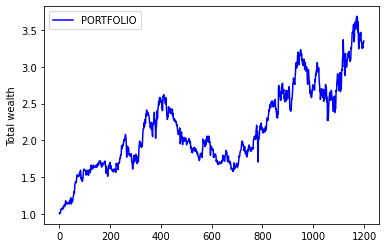

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.46 ± 0.66
    Ulcer index: -0.71
    Information ratio (wrt UCRP): -2.31
    Appraisal ratio (wrt UCRP): -2.33 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.20 / -74.089%
    Annualized return: -43.13%
    Annualized volatility: 34.55%
    Longest drawdown: 1130 days
    Max drawdown: 94.46%
    Winning days: 43.3%
    Annual turnover: 332.1
        
Total wealth: 0.06806453869067608


<Figure size 720x360 with 0 Axes>

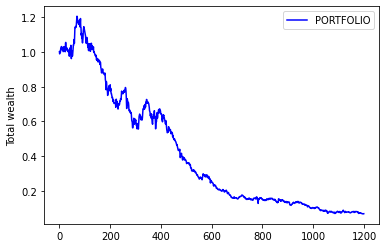

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.49
    Sharpe ratio: -3.85 ± 1.33
    Ulcer index: -1.53
    Information ratio (wrt UCRP): -5.05
    Appraisal ratio (wrt UCRP): -4.94 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.20 / -155.996%
    Annualized return: -75.01%
    Annualized volatility: 34.36%
    Longest drawdown: 1199 days
    Max drawdown: 99.87%
    Winning days: 37.0%
    Annual turnover: 332.1
        
Total wealth: 0.0013547176582128797


<Figure size 432x288 with 0 Axes>

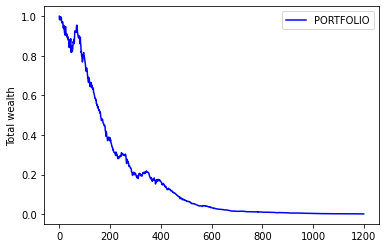

In [30]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

## Spearman 0.85 - GGD

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


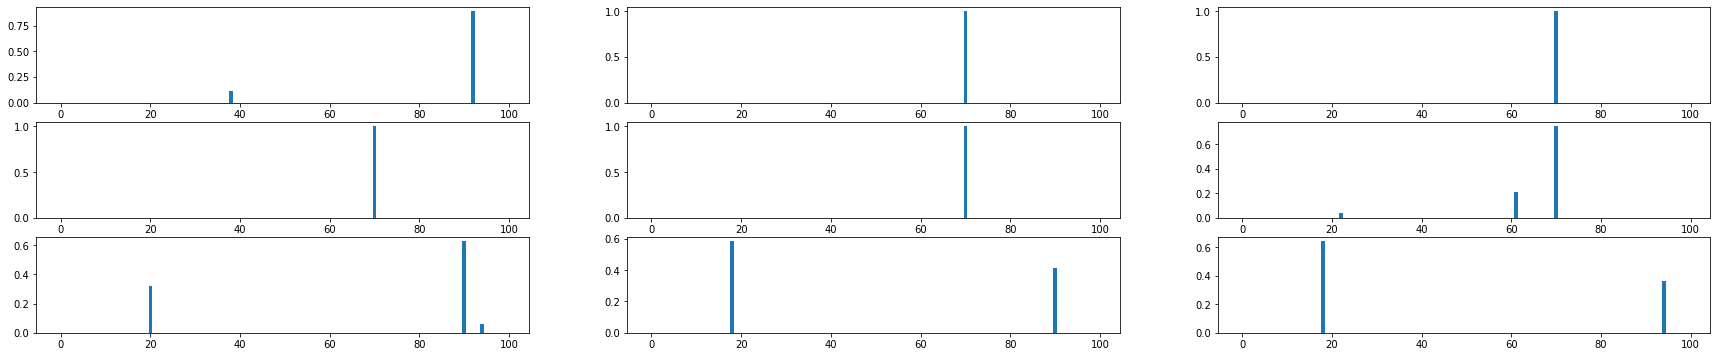

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


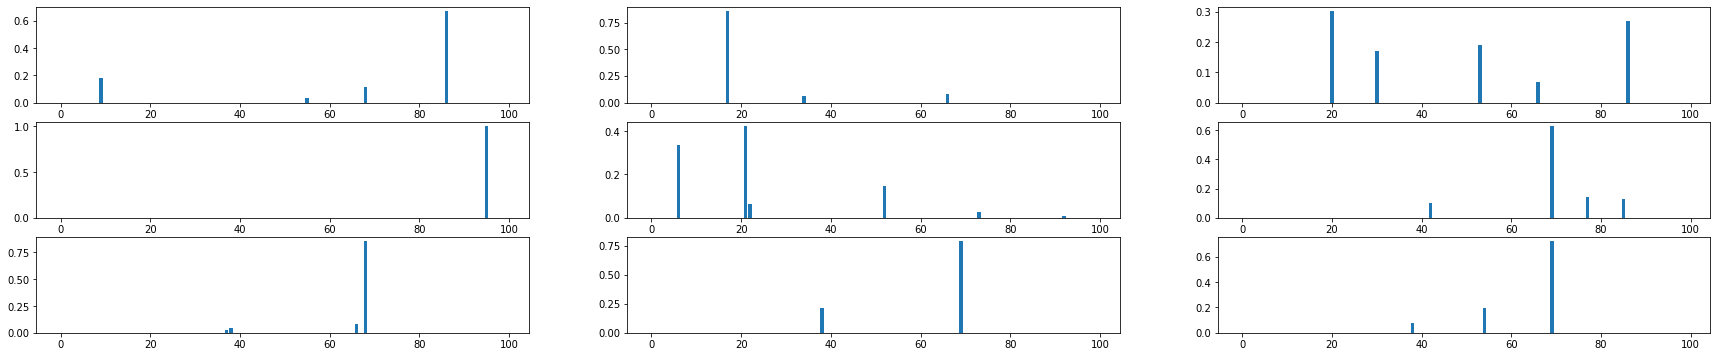

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


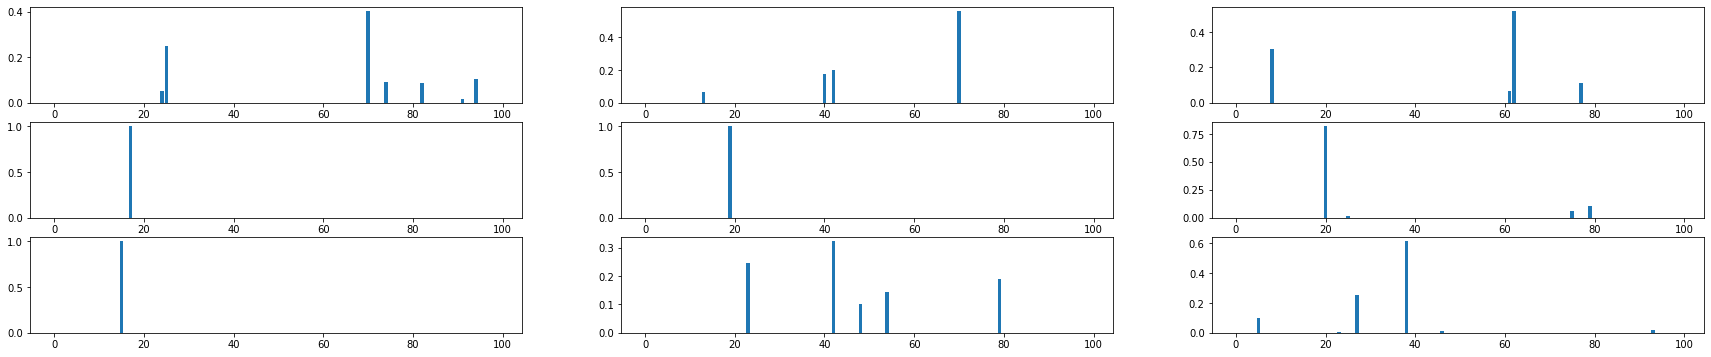

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


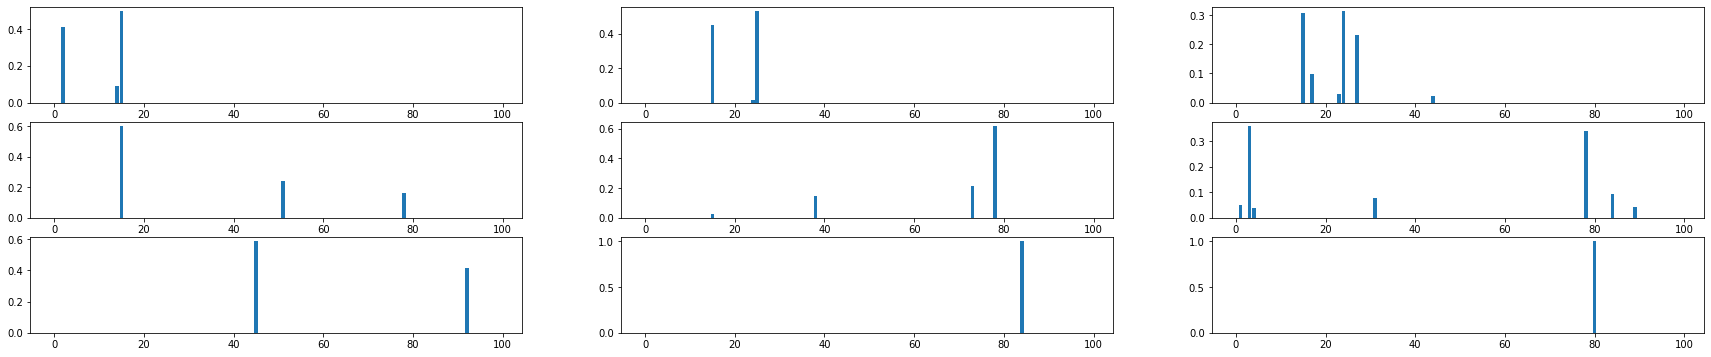

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


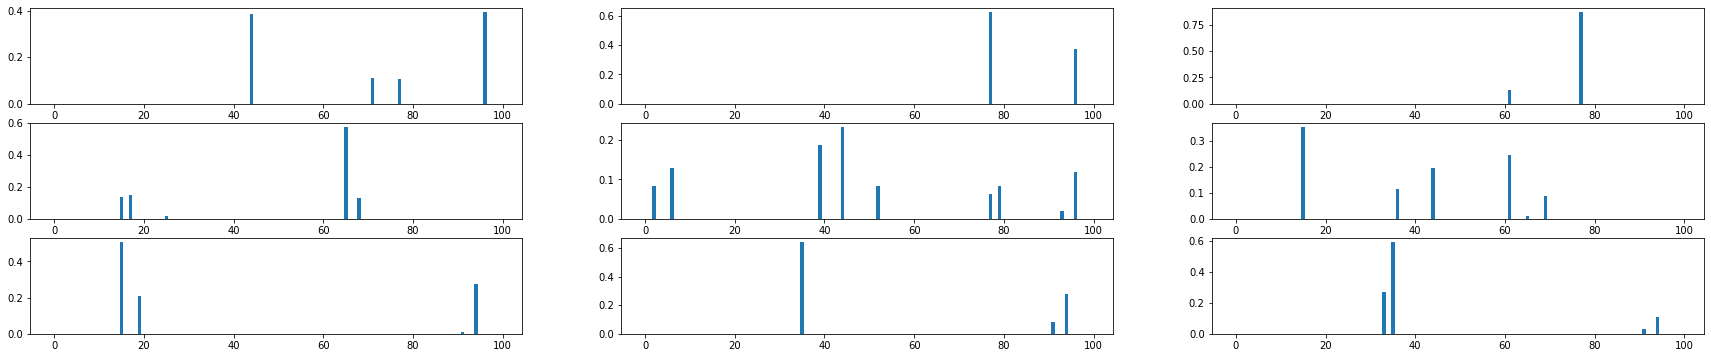

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


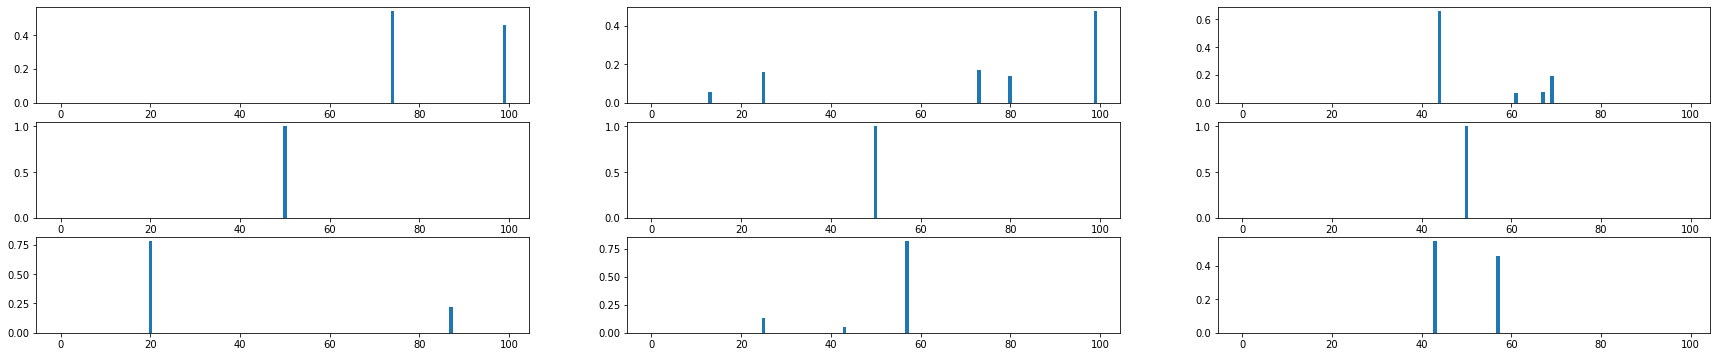

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


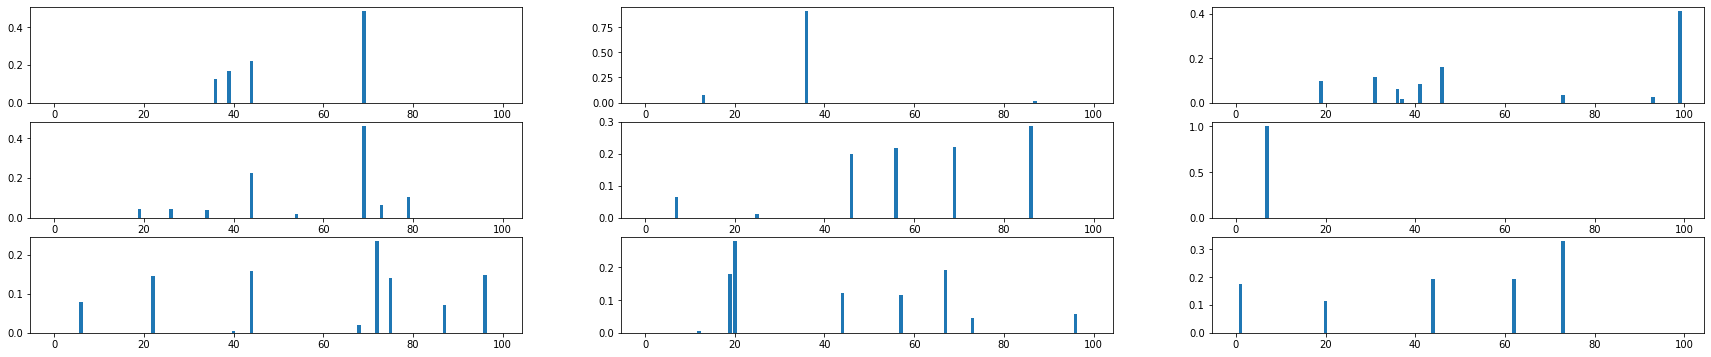

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


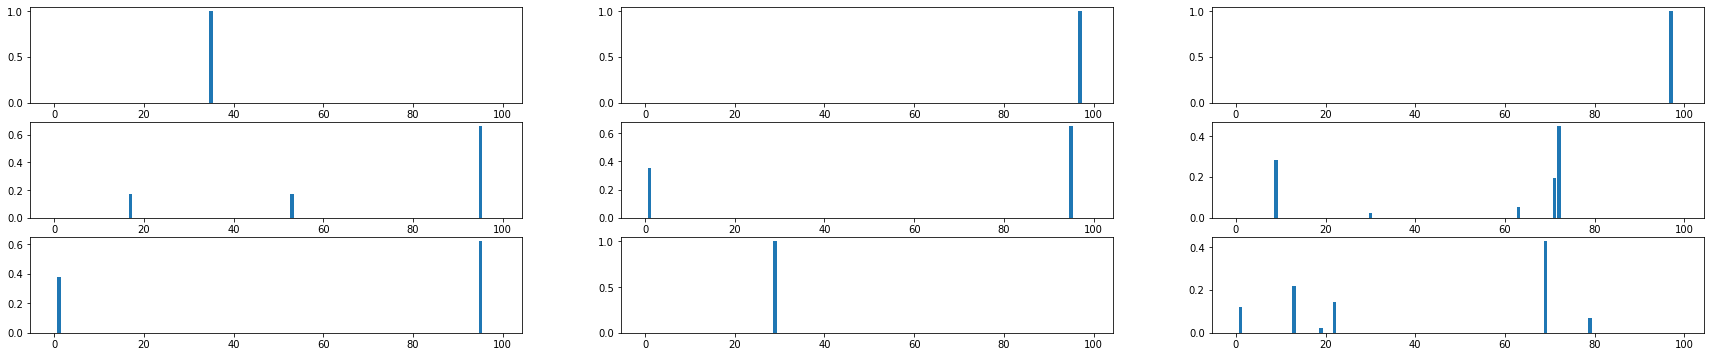

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


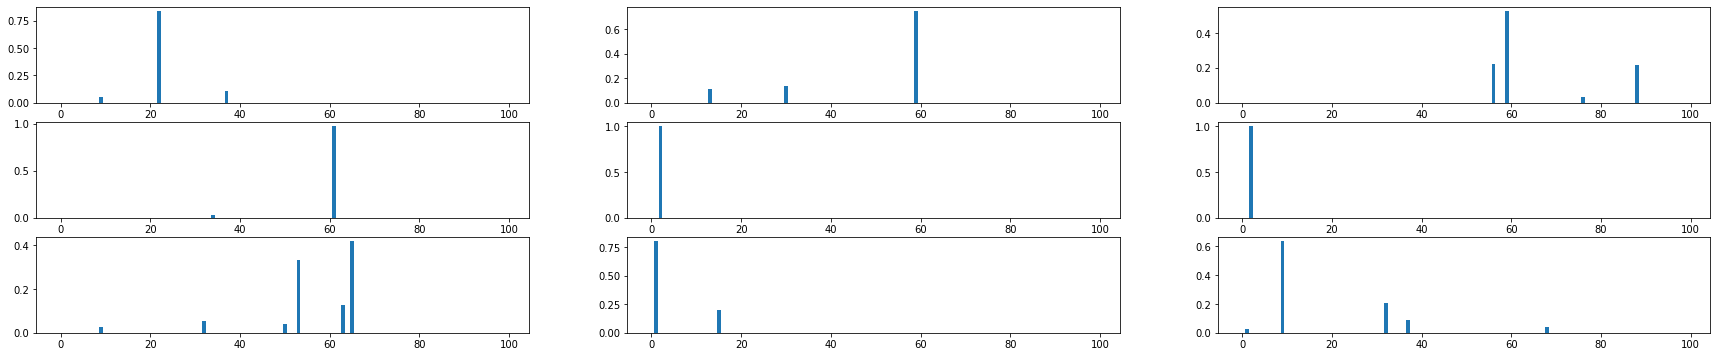

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


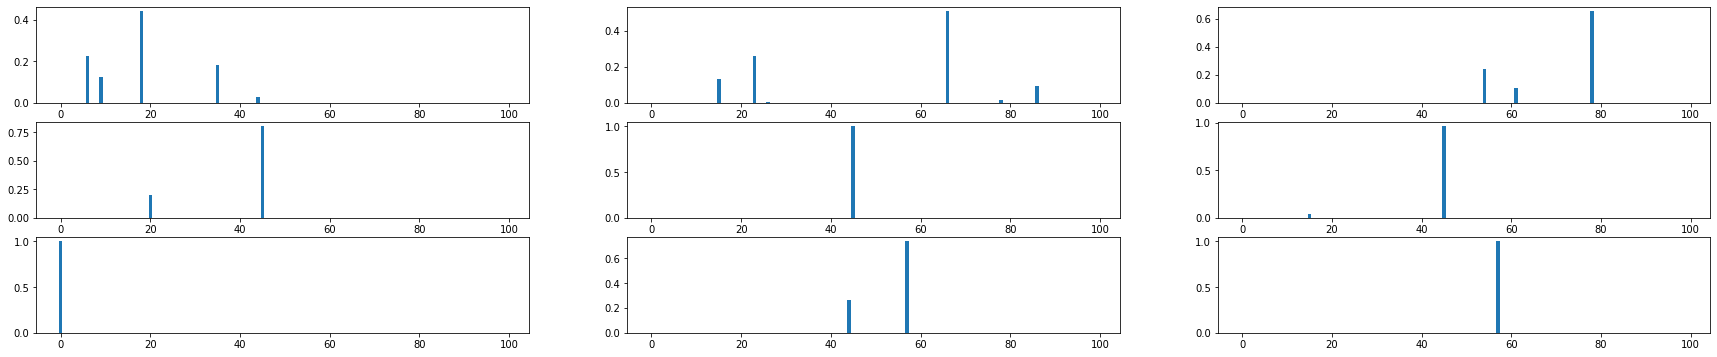

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


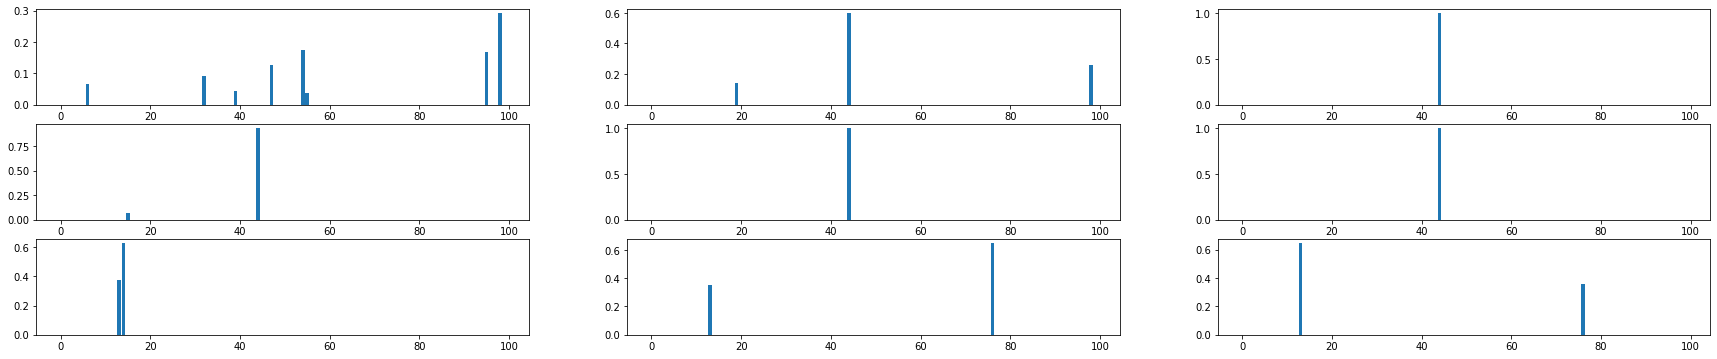

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P
No opt solution: 0 / 100


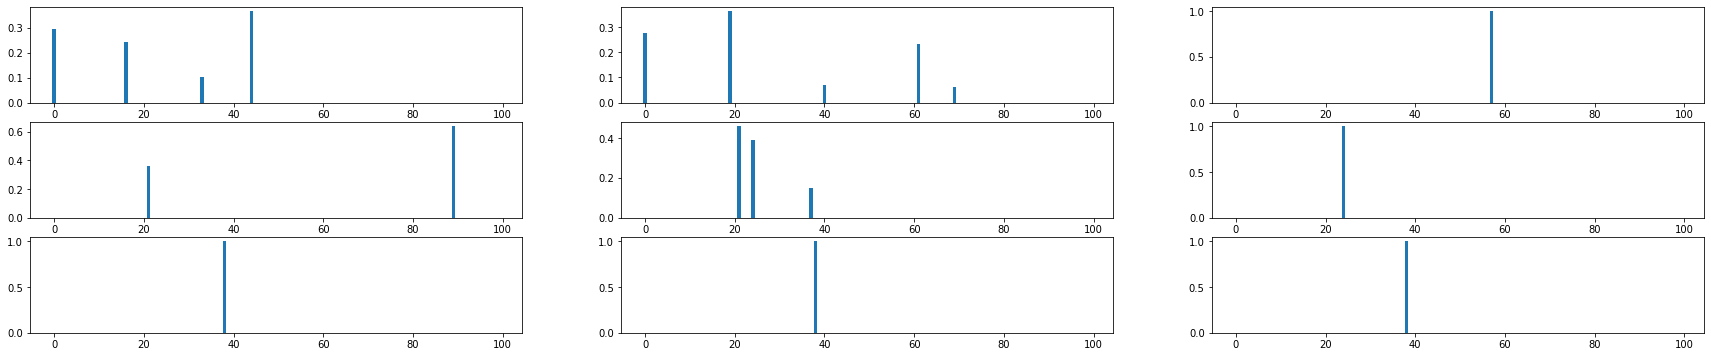

In [33]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'False',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0, 'passive_gamma':0,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.07 ± 0.58
    Ulcer index: 2.78
    Information ratio (wrt UCRP): 0.57
    Appraisal ratio (wrt UCRP): 0.36 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.27 / 10.836%
    Annualized return: 35.45%
    Annualized volatility: 33.33%
    Longest drawdown: 413 days
    Max drawdown: 36.37%
    Winning days: 54.2%
    Annual turnover: 338.3
        
Total wealth: 4.241880832853529


<Figure size 720x360 with 0 Axes>

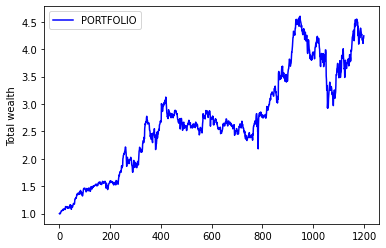

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.74
    Sharpe ratio: -1.46 ± 0.66
    Ulcer index: -0.74
    Information ratio (wrt UCRP): -2.42
    Appraisal ratio (wrt UCRP): -2.50 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.27 / -72.798%
    Annualized return: -41.25%
    Annualized volatility: 32.81%
    Longest drawdown: 1130 days
    Max drawdown: 92.71%
    Winning days: 42.8%
    Annual turnover: 338.3
        
Total wealth: 0.07945538480819843


<Figure size 720x360 with 0 Axes>

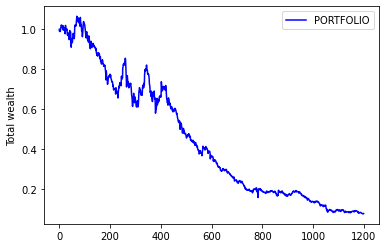

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.47
    Sharpe ratio: -4.04 ± 1.39
    Ulcer index: -1.53
    Information ratio (wrt UCRP): -5.49
    Appraisal ratio (wrt UCRP): -5.43 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.27 / -156.431%
    Annualized return: -74.61%
    Annualized volatility: 32.53%
    Longest drawdown: 1199 days
    Max drawdown: 99.86%
    Winning days: 33.8%
    Annual turnover: 338.3
        
Total wealth: 0.0014631560377096288


<Figure size 432x288 with 0 Axes>

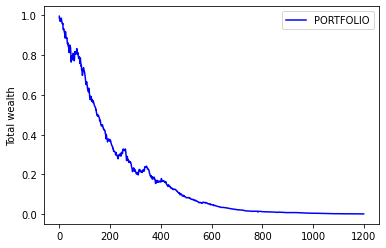

In [34]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

# Kandell

## Kandell 0.7 + GGD

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


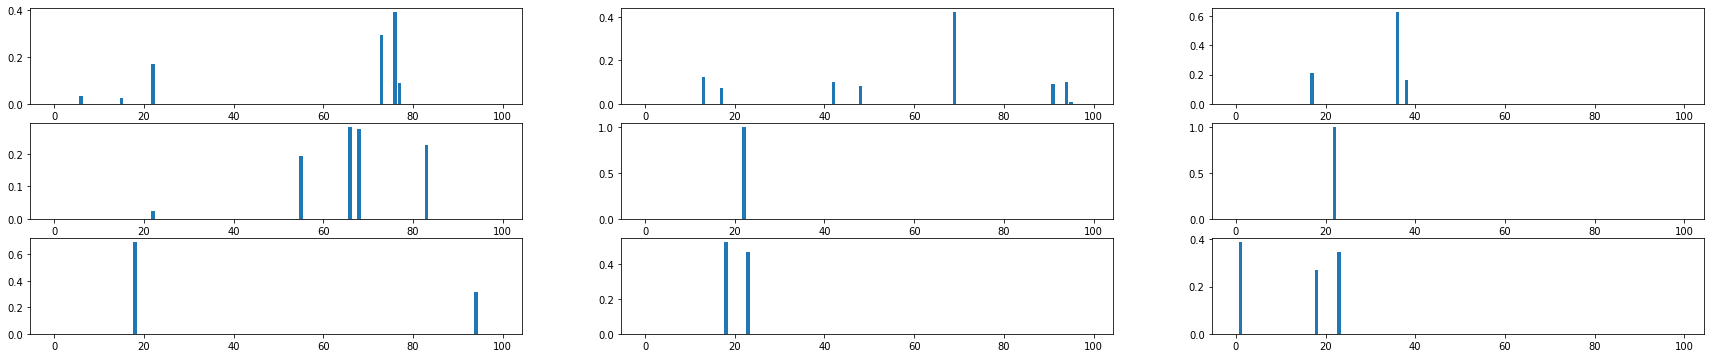

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


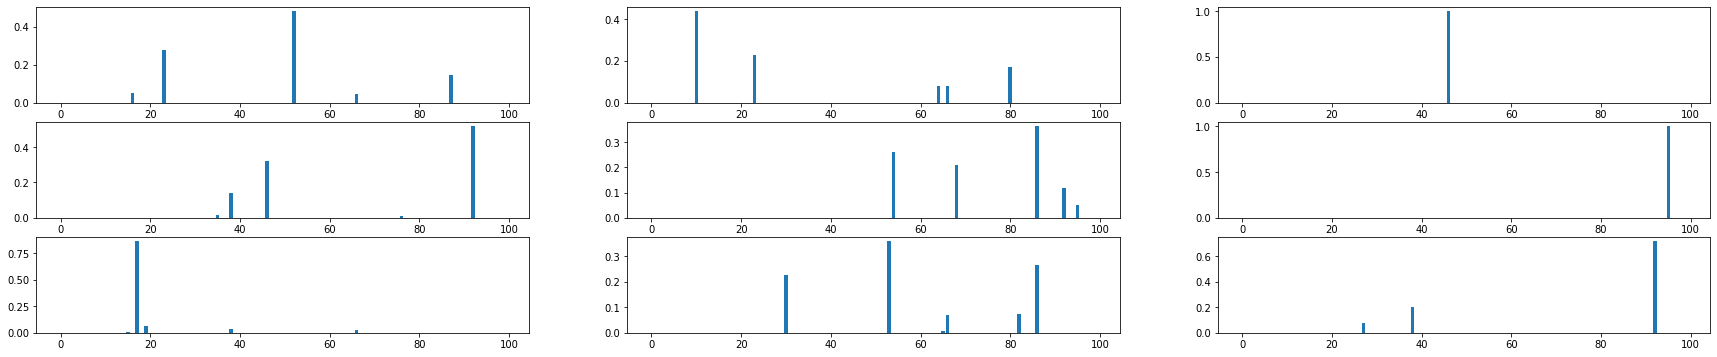

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


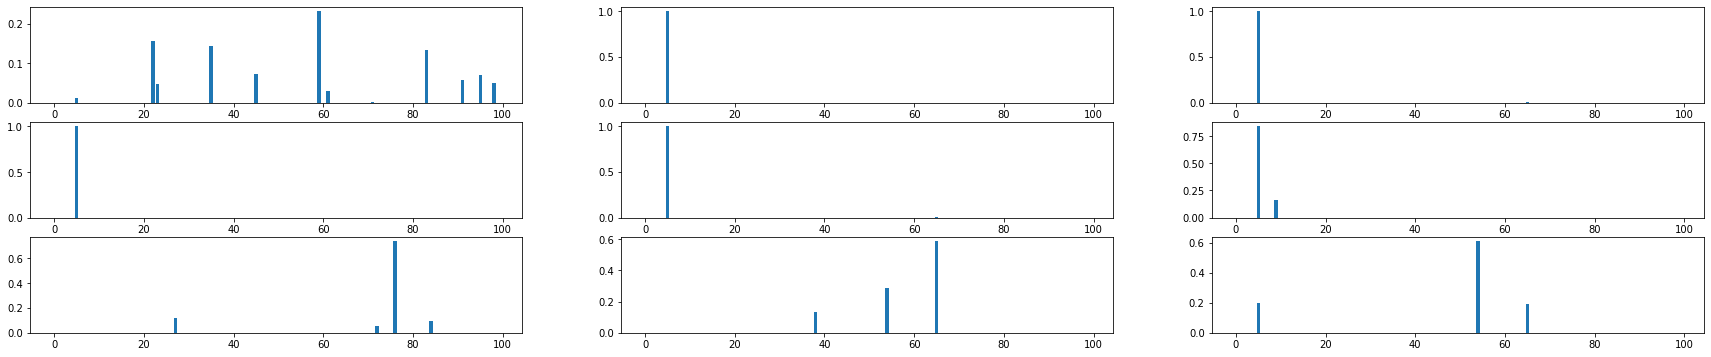

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


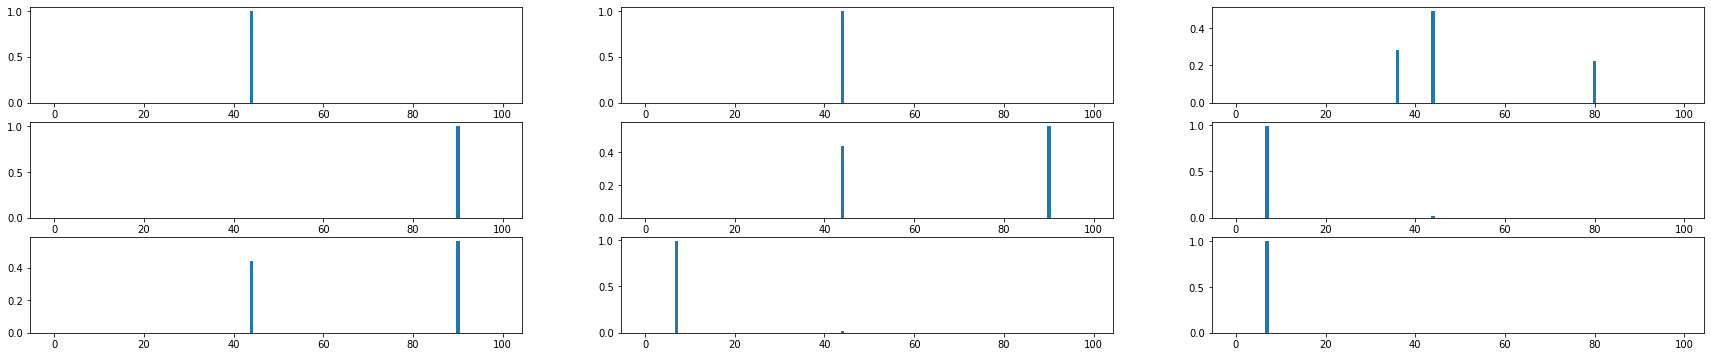

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


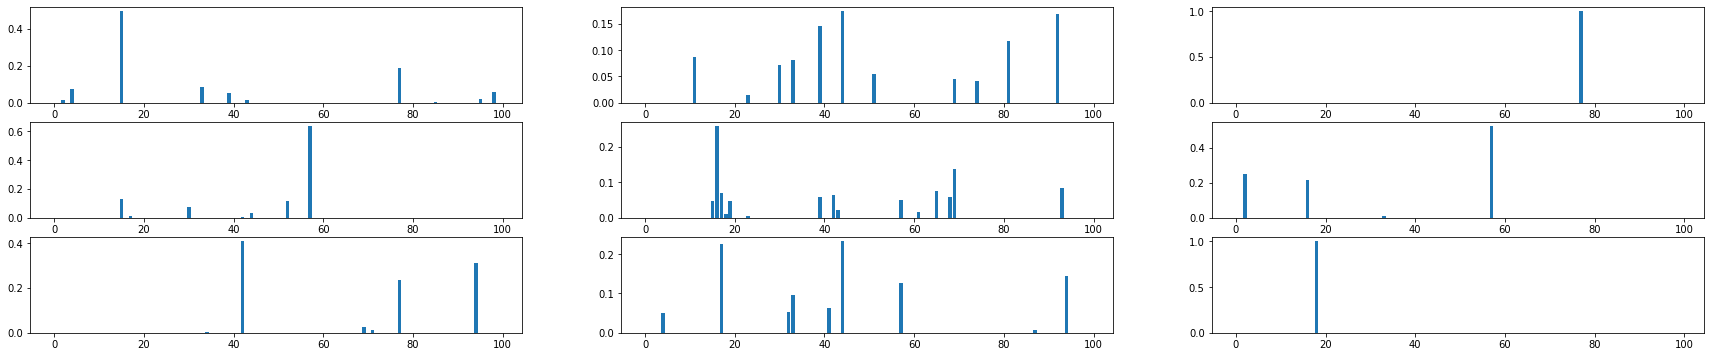

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


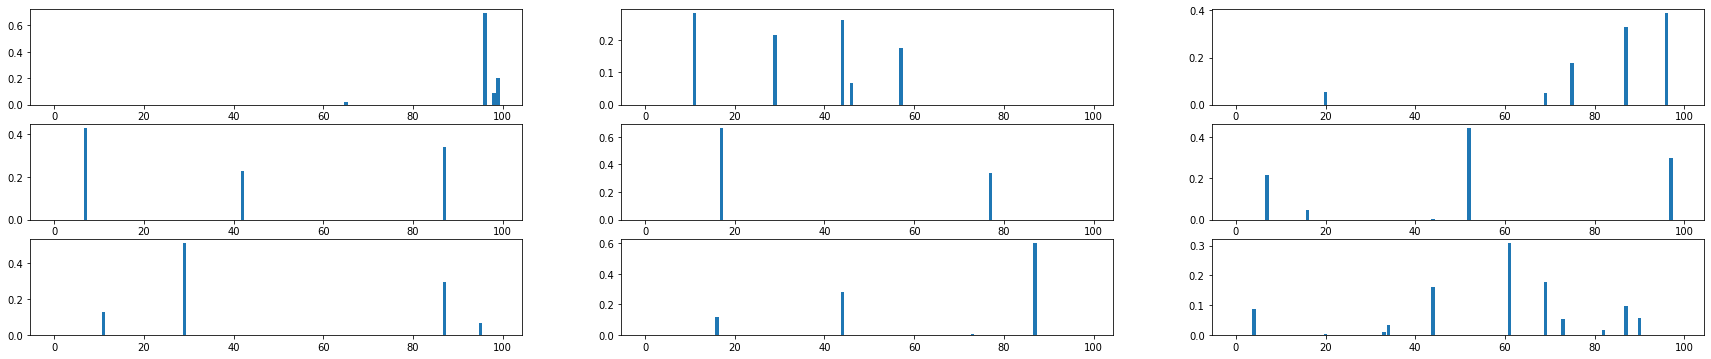

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


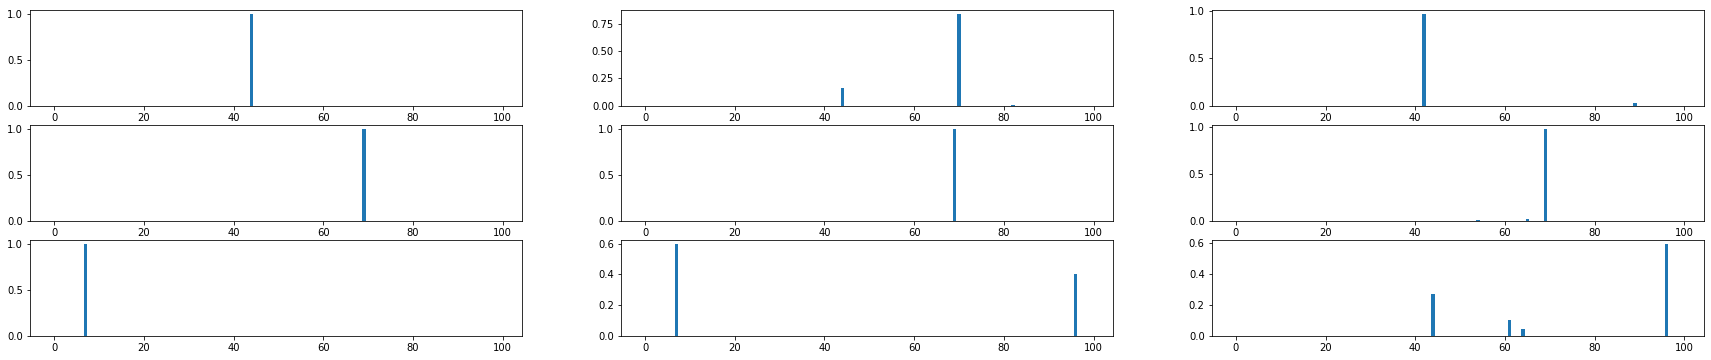

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


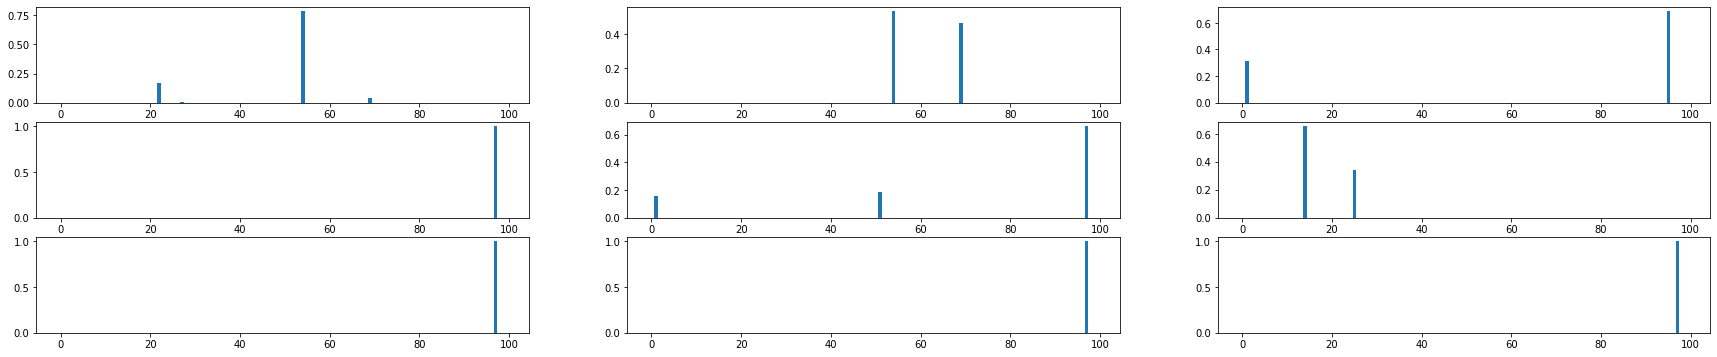

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


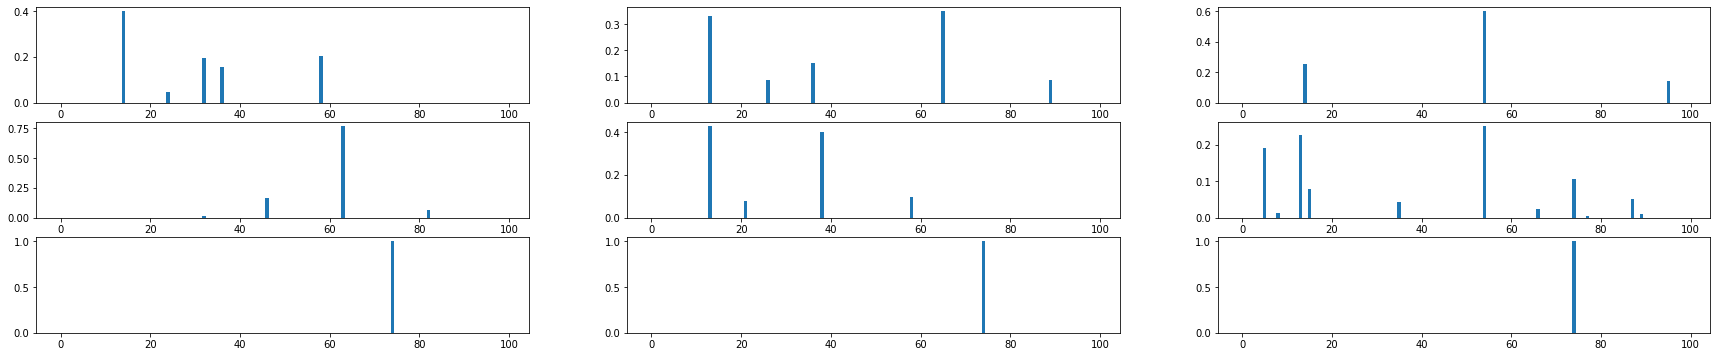

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


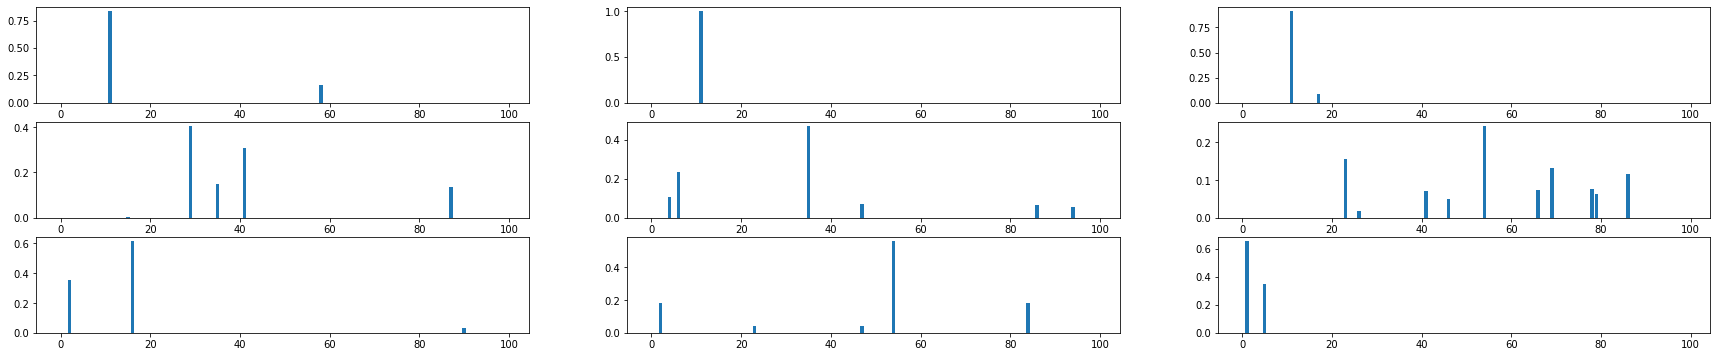

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


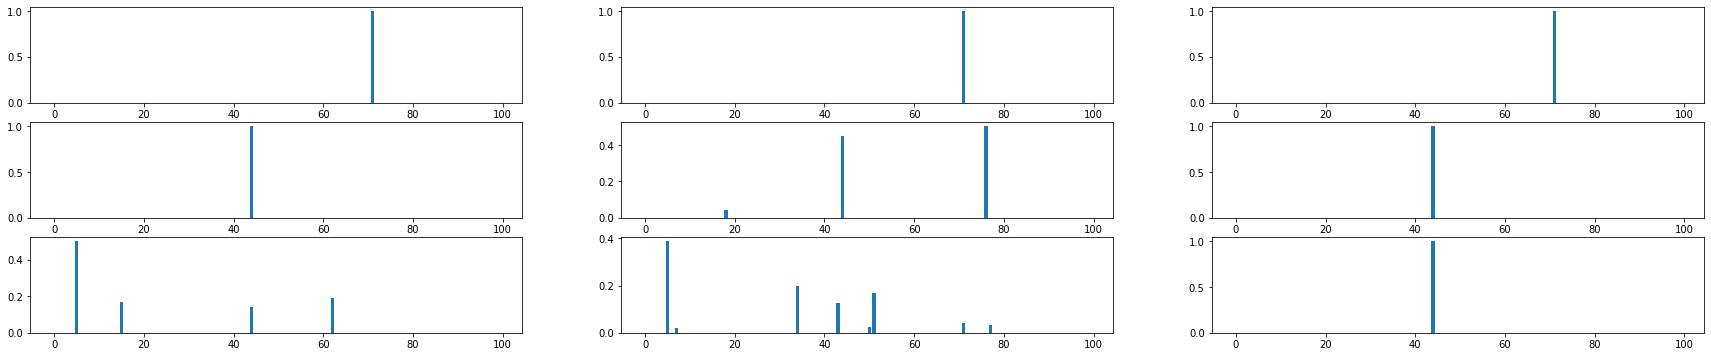

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_kendall_dg0.70_invTrue_ggdTrue.npz
G4P
No opt solution: 0 / 100


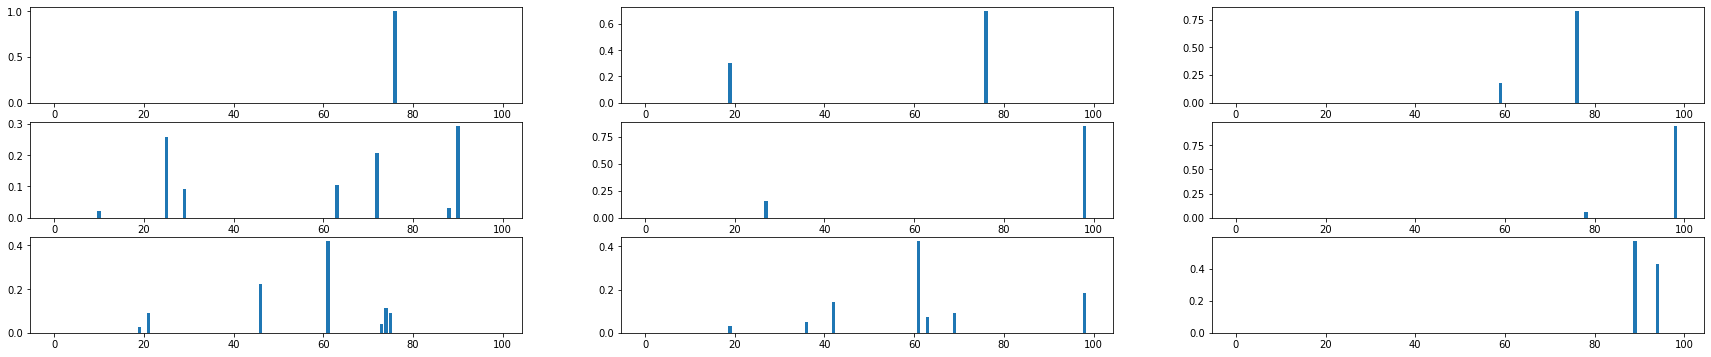

In [30]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':10, 'passive_gamma':0,
       'mattype':-3, 'dg':0.7
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.21
    Sharpe ratio: 1.16 ± 0.59
    Ulcer index: 3.61
    Information ratio (wrt UCRP): 0.64
    Appraisal ratio (wrt UCRP): 0.46 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / 13.227%
    Annualized return: 37.97%
    Annualized volatility: 32.15%
    Longest drawdown: 391 days
    Max drawdown: 30.37%
    Winning days: 55.0%
    Annual turnover: 331.8
        
Total wealth: 4.630449863073438


<Figure size 720x360 with 0 Axes>

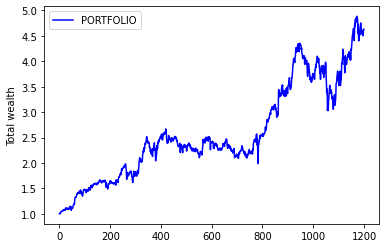

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 0.75
    Sharpe ratio: -1.41 ± 0.65
    Ulcer index: -0.67
    Information ratio (wrt UCRP): -2.40
    Appraisal ratio (wrt UCRP): -2.43 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -68.676%
    Annualized return: -39.13%
    Annualized volatility: 31.63%
    Longest drawdown: 1130 days
    Max drawdown: 91.69%
    Winning days: 43.0%
    Annual turnover: 331.8
        
Total wealth: 0.09402281496361645


<Figure size 720x360 with 0 Axes>

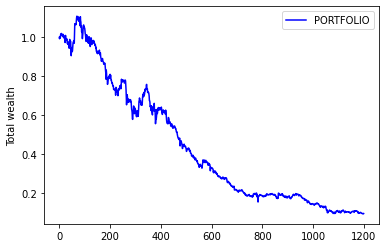

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 0.47
    Sharpe ratio: -4.04 ± 1.39
    Ulcer index: -1.47
    Information ratio (wrt UCRP): -5.52
    Appraisal ratio (wrt UCRP): -5.40 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.22 / -150.580%
    Annualized return: -73.24%
    Annualized volatility: 31.35%
    Longest drawdown: 1199 days
    Max drawdown: 99.81%
    Winning days: 34.6%
    Annual turnover: 331.8
        
Total wealth: 0.0018782305862953858


<Figure size 432x288 with 0 Axes>

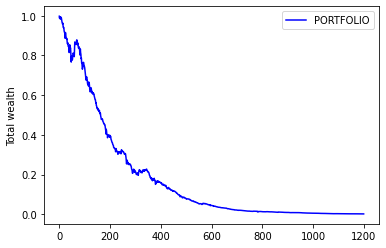

In [31]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

# G4P - passive

In [57]:
strategy_lst = ['G4P_passive(predY0, std_varY0, sample_Y0, cov, paras["passive_eps"], paras["passive_gamma"])']

# Spearman

## Spearman 0.85 + GGD

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


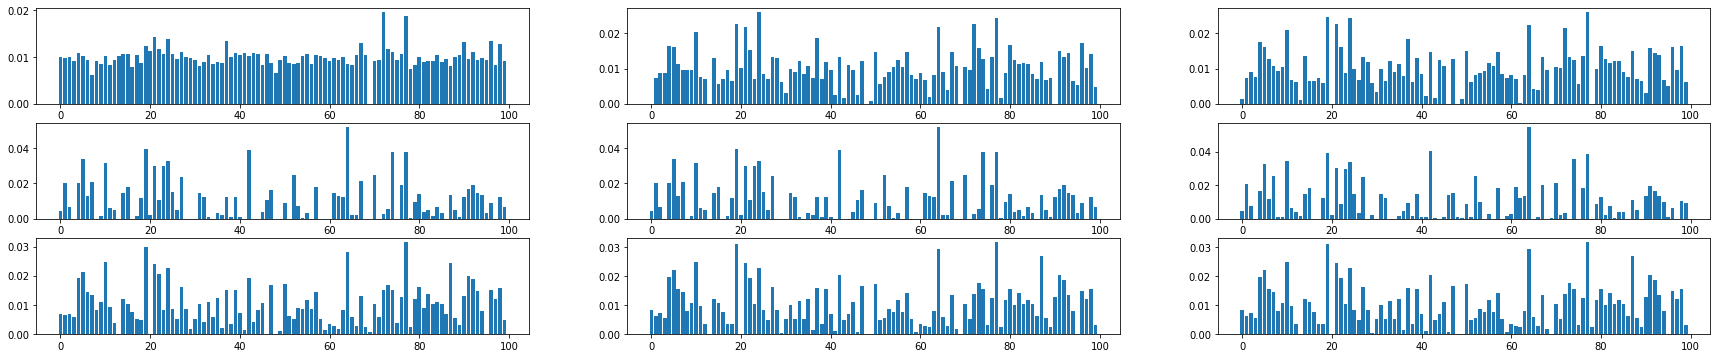

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


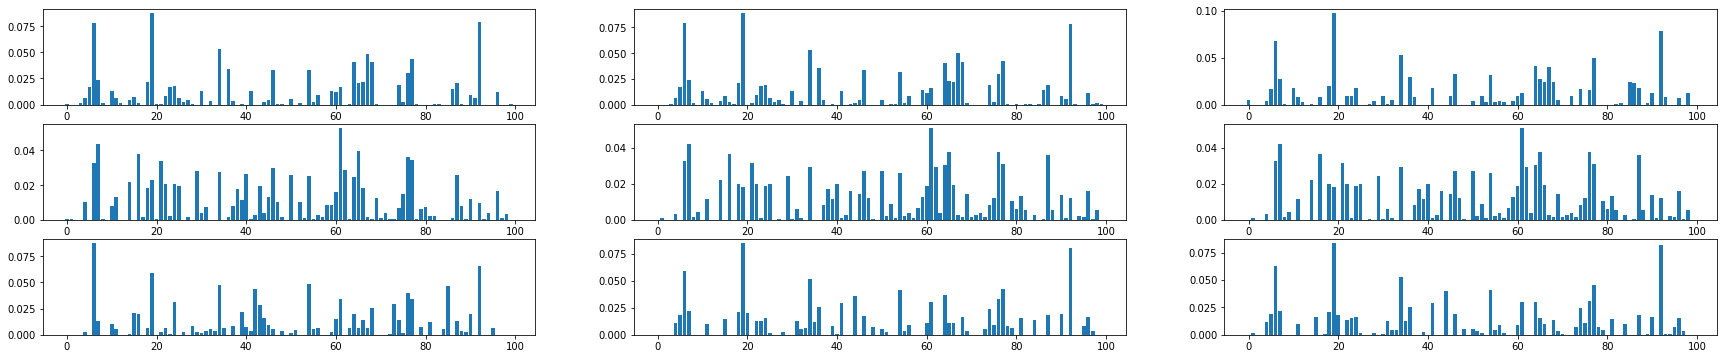

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


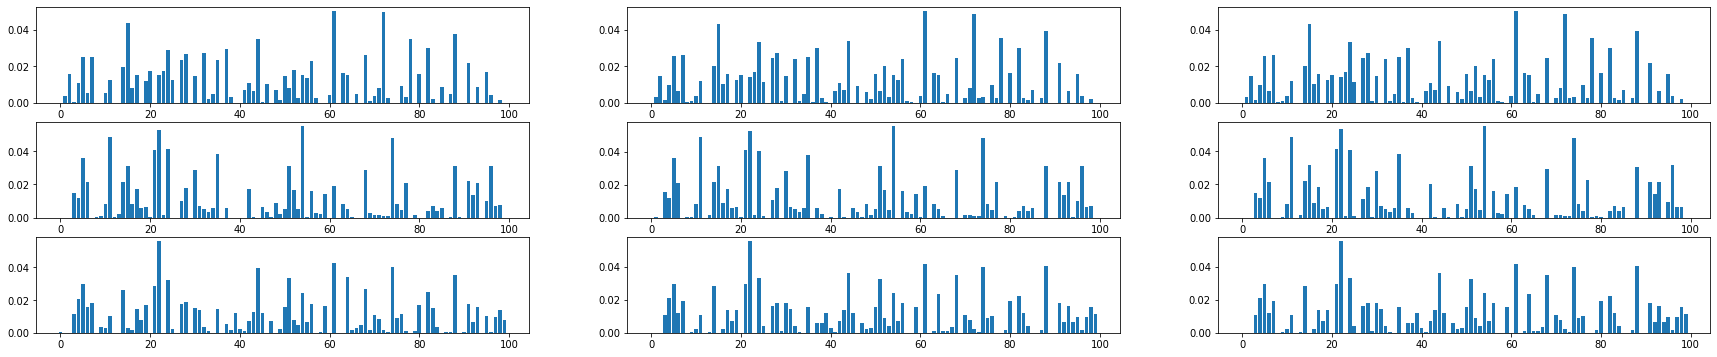

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


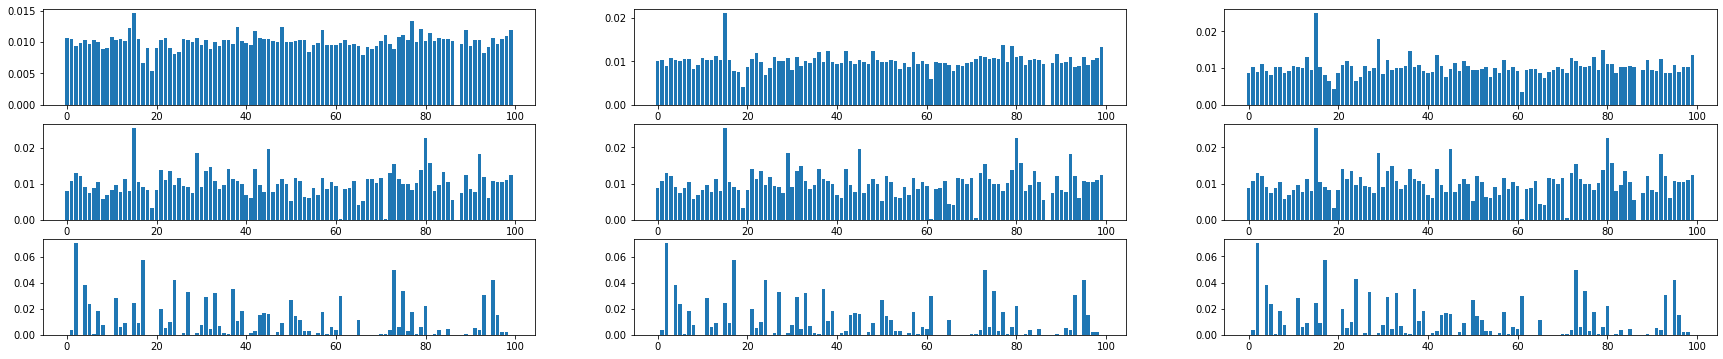

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


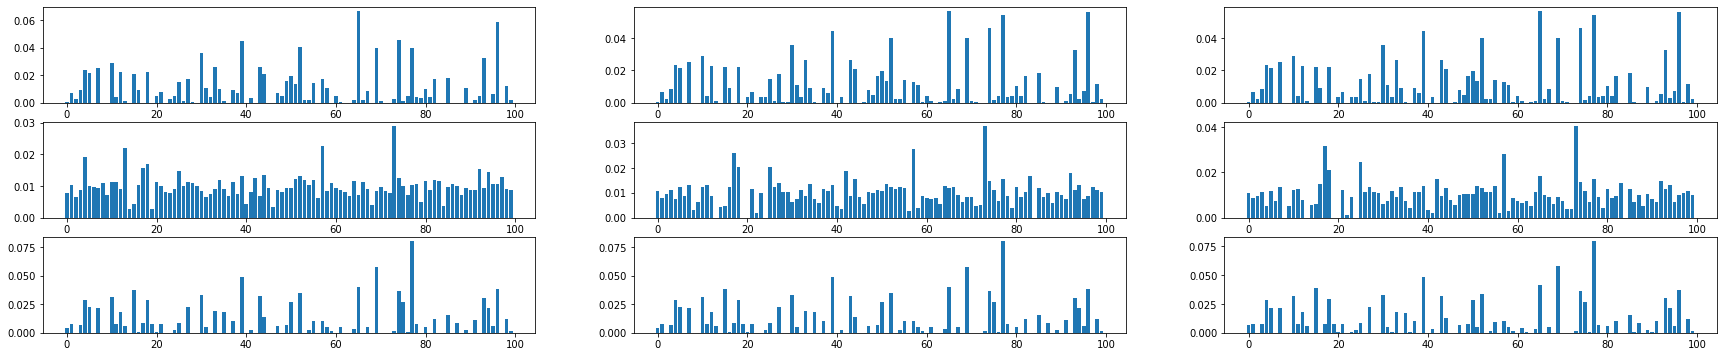

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


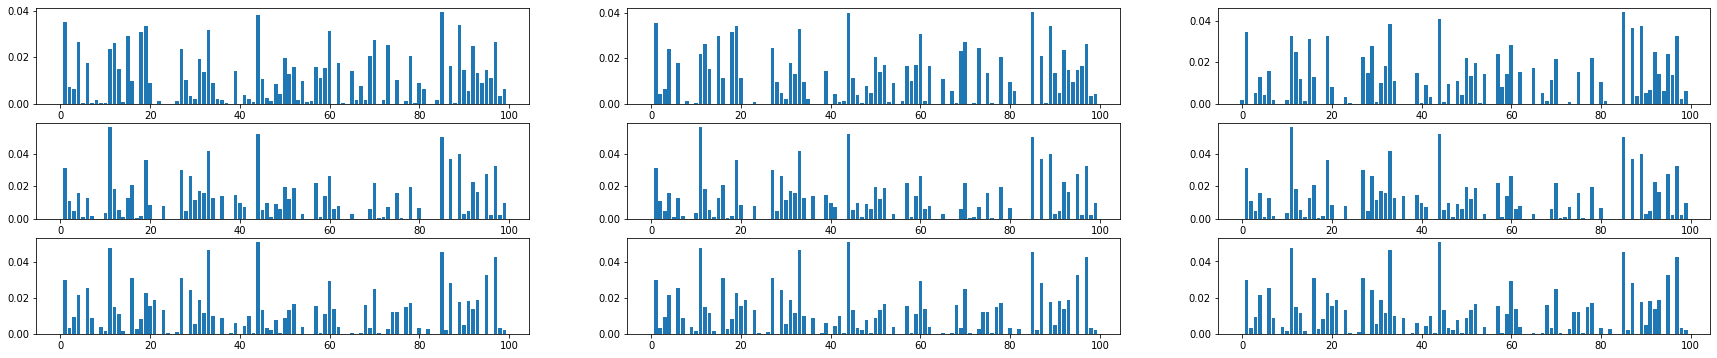

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


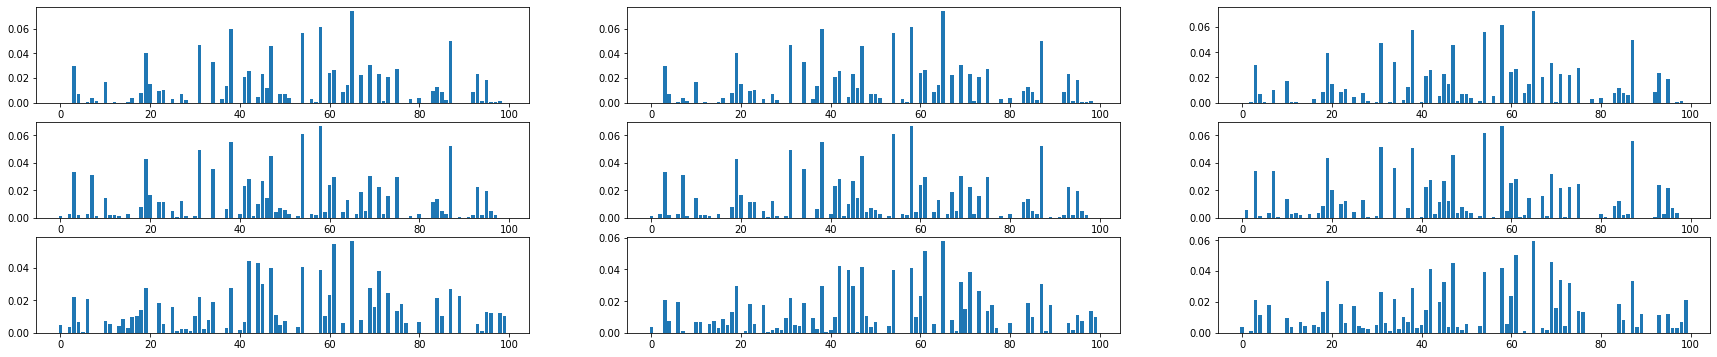

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


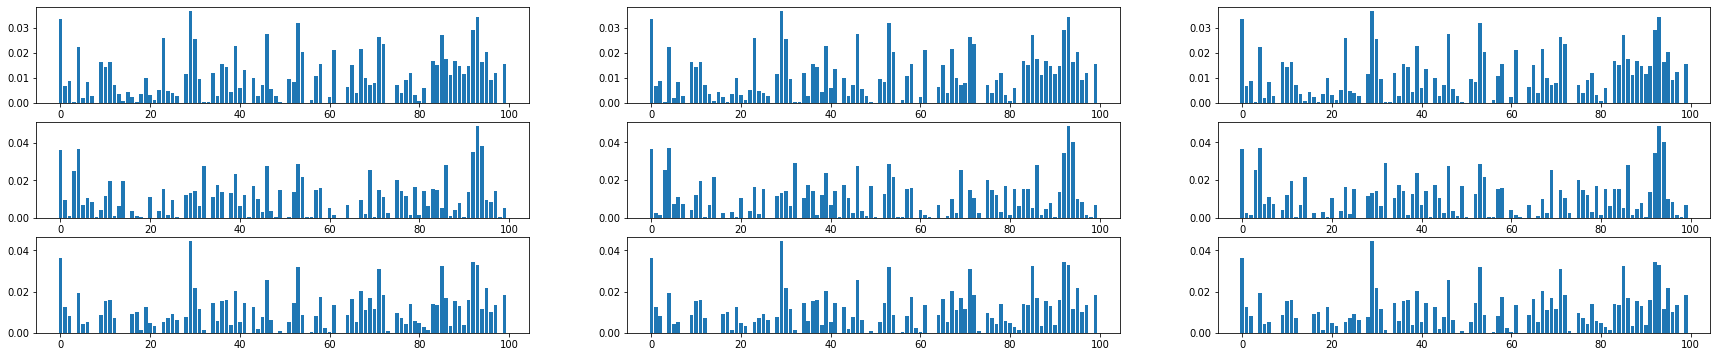

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


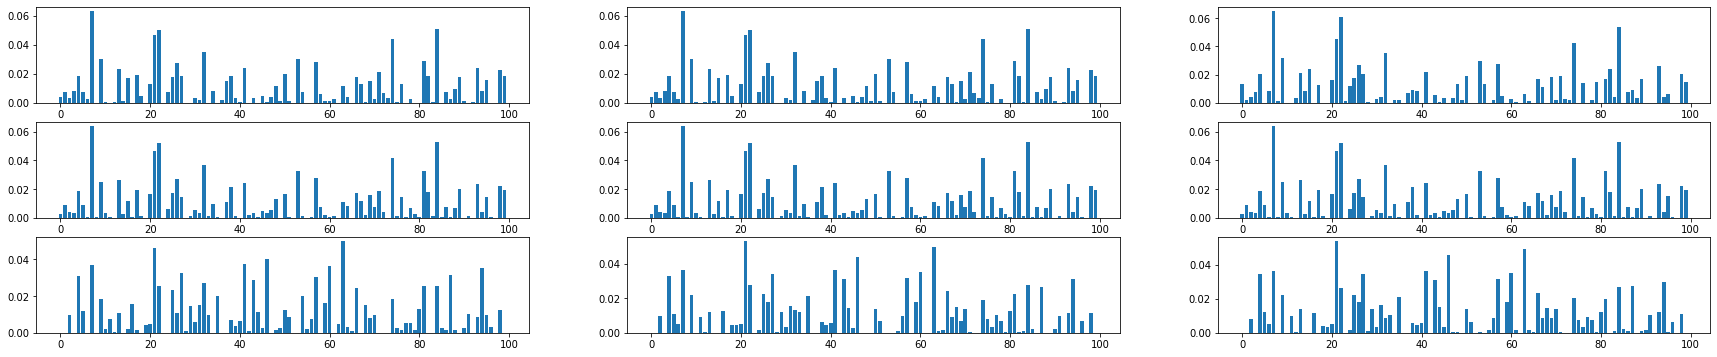

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


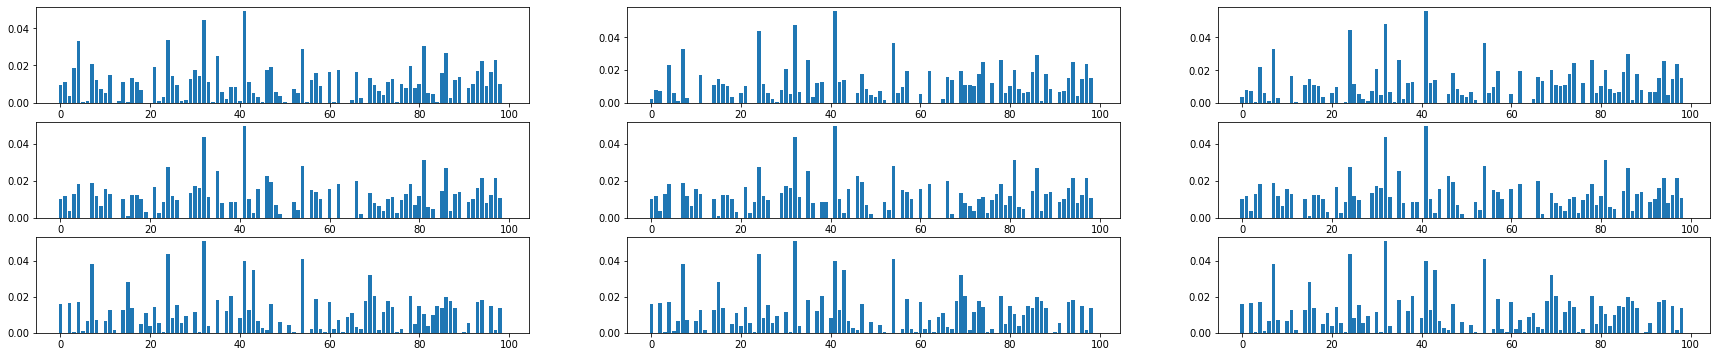

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


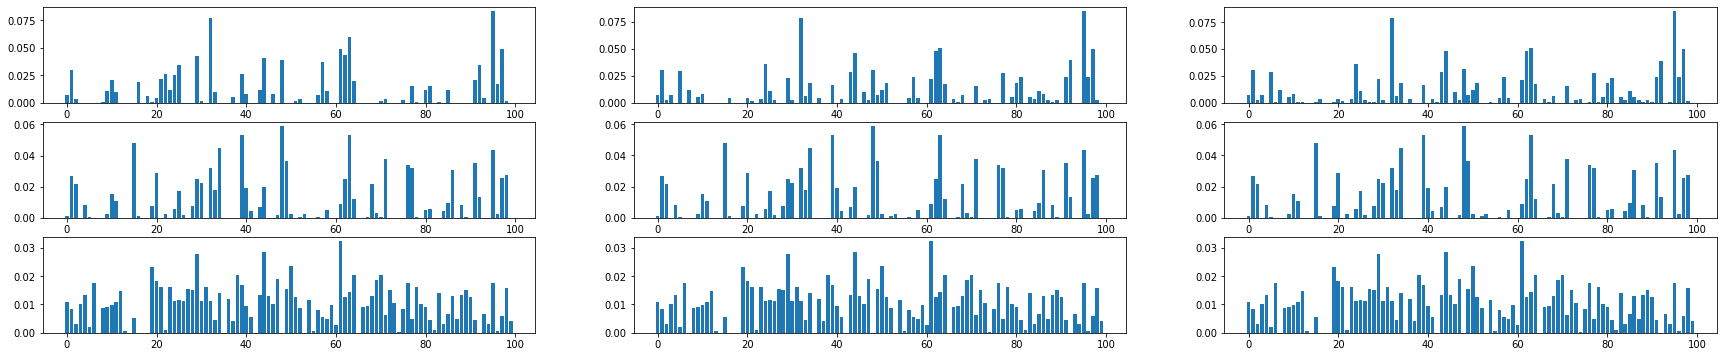

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdTrue.npz
G4P_passive
No opt solution: 0 / 100


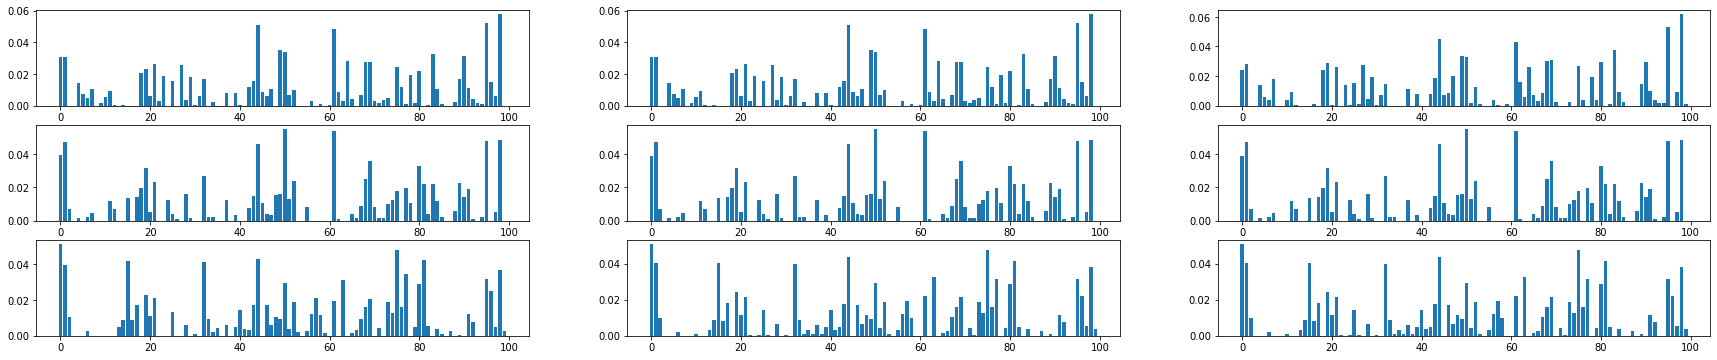

In [58]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'True',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0015, 'passive_gamma':0.001,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P_passive
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.31
    Sharpe ratio: 1.64 ± 0.70
    Ulcer index: 6.84
    Information ratio (wrt UCRP): 1.13
    Appraisal ratio (wrt UCRP): 0.77 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.00 / 4.073%
    Annualized return: 25.59%
    Annualized volatility: 14.51%
    Longest drawdown: 94 days
    Max drawdown: 17.99%
    Winning days: 57.2%
    Annual turnover: 25.7
        
Total wealth: 2.9599627080343462


<Figure size 720x360 with 0 Axes>

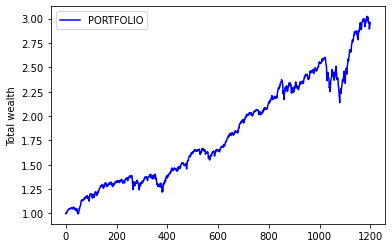

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.22
    Sharpe ratio: 1.21 ± 0.60
    Ulcer index: 4.36
    Information ratio (wrt UCRP): -0.65
    Appraisal ratio (wrt UCRP): -0.42 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 0.99 / -2.181%
    Annualized return: 17.72%
    Annualized volatility: 14.33%
    Longest drawdown: 157 days
    Max drawdown: 18.73%
    Winning days: 56.2%
    Annual turnover: 25.7
        
Total wealth: 2.1748753152678764


<Figure size 720x360 with 0 Axes>

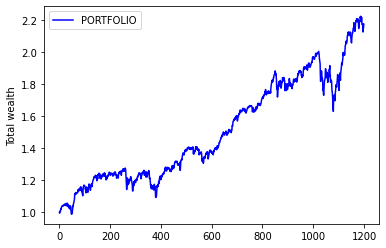

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.13
    Sharpe ratio: 0.76 ± 0.52
    Ulcer index: 2.17
    Information ratio (wrt UCRP): -2.36
    Appraisal ratio (wrt UCRP): -1.58 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 0.98 / -8.436%
    Annualized return: 10.34%
    Annualized volatility: 14.19%
    Longest drawdown: 331 days
    Max drawdown: 19.48%
    Winning days: 54.7%
    Annual turnover: 25.7
        
Total wealth: 1.5975454359416448


<Figure size 432x288 with 0 Axes>

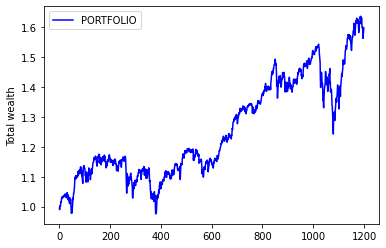

In [59]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)

<Figure size 432x288 with 0 Axes>

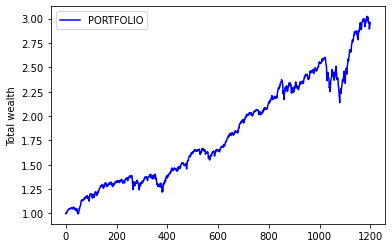

In [60]:
rt_v, x_vec, sample_Y0 = concat_results[strategy_name]
B = np.concatenate([v.reshape(1,-1) for v in x_vec], axis=0)
B = pd.DataFrame(B)
Y = pd.DataFrame(np.concatenate(sample_Y0, axis=0))
result = AlgoResult(Y, B)
result.fee = 0
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_passive_fee00', ydata)

<Figure size 432x288 with 0 Axes>

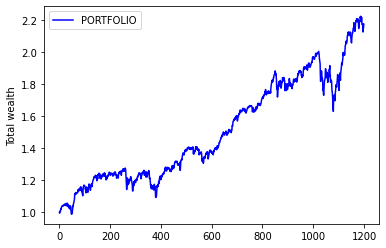

In [61]:
result.fee = 0.0025
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_passive_fee25', ydata)

<Figure size 432x288 with 0 Axes>

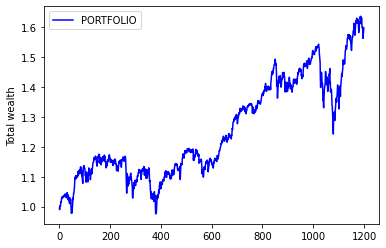

In [62]:
result.fee = 0.005
plt.figure()
ax=result.plot(weights=False, assets=False, ucrp=False, logy=False)
# plt.show()

# ax = plt.gca()
line = ax[0].lines[0]
ydata=line.get_ydata()

np.save('./tmp2/snp500_g4p_passive_fee50', ydata)

## Spearman 0.85 - GGD

Phase 0
./tmp2/snp500-12_phase00_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


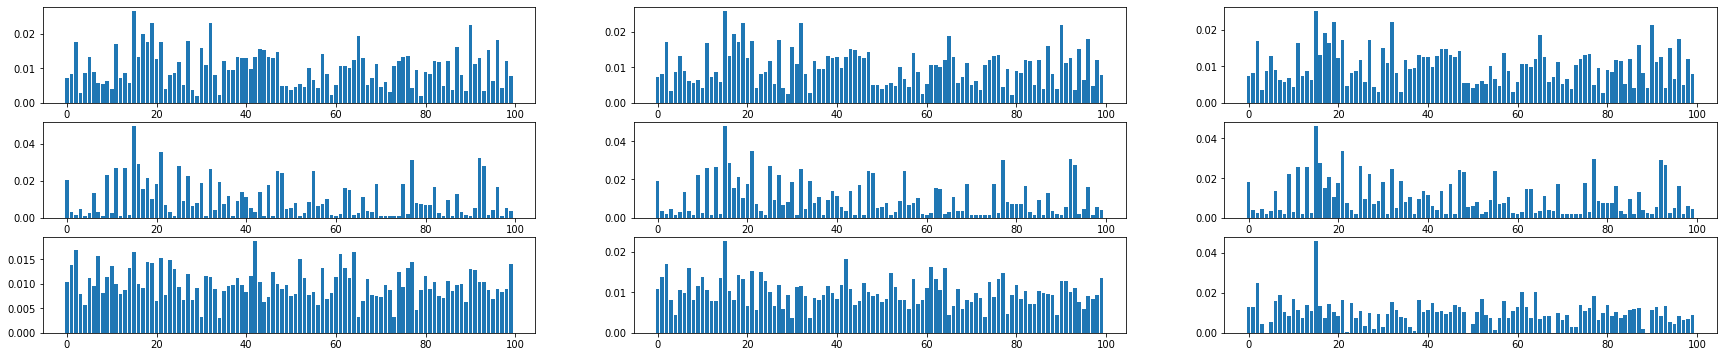

Phase 1
./tmp2/snp500-12_phase01_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


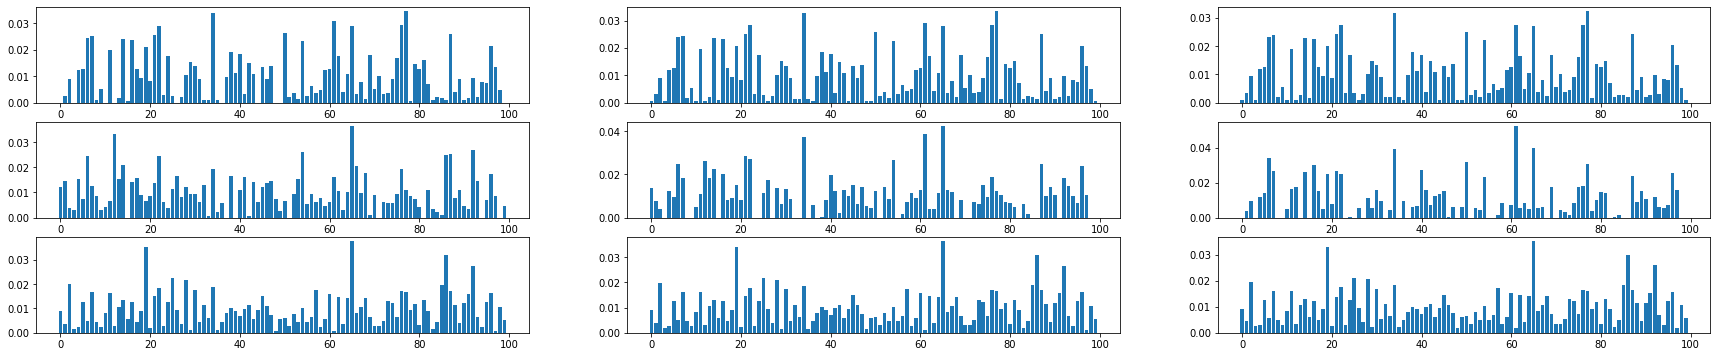

Phase 2
./tmp2/snp500-12_phase02_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


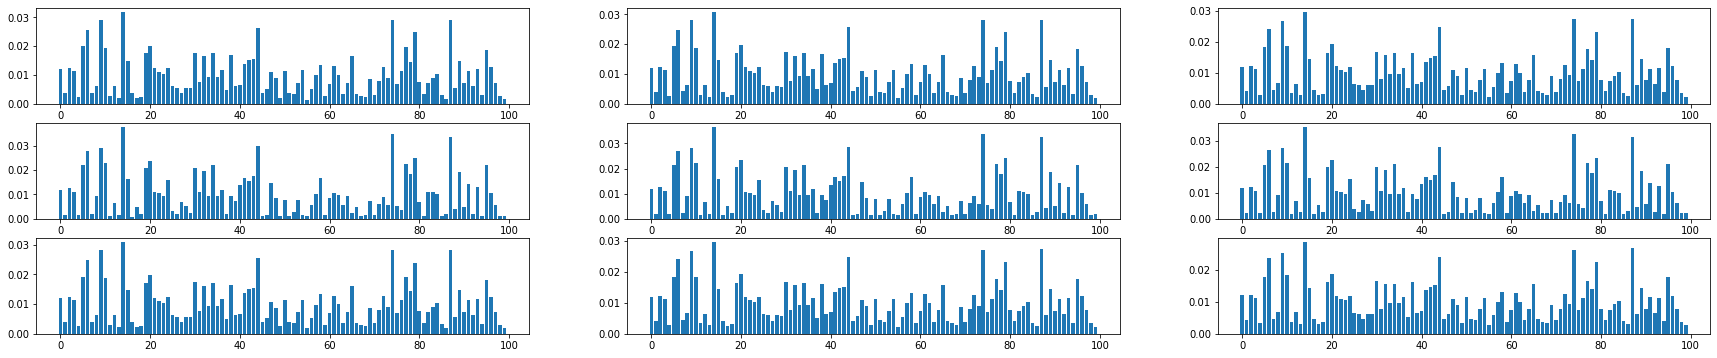

Phase 3
./tmp2/snp500-12_phase03_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


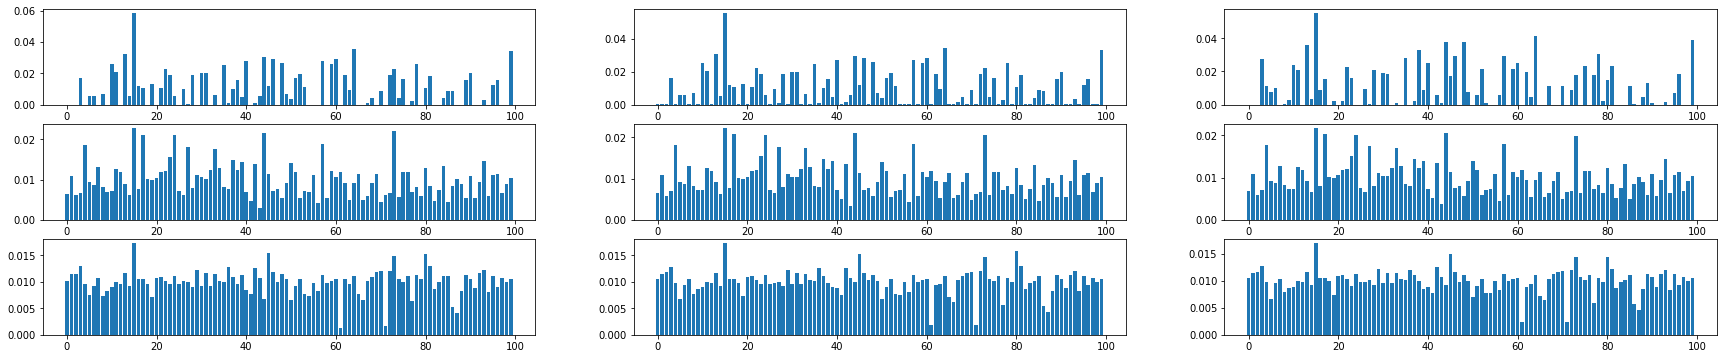

Phase 4
./tmp2/snp500-12_phase04_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


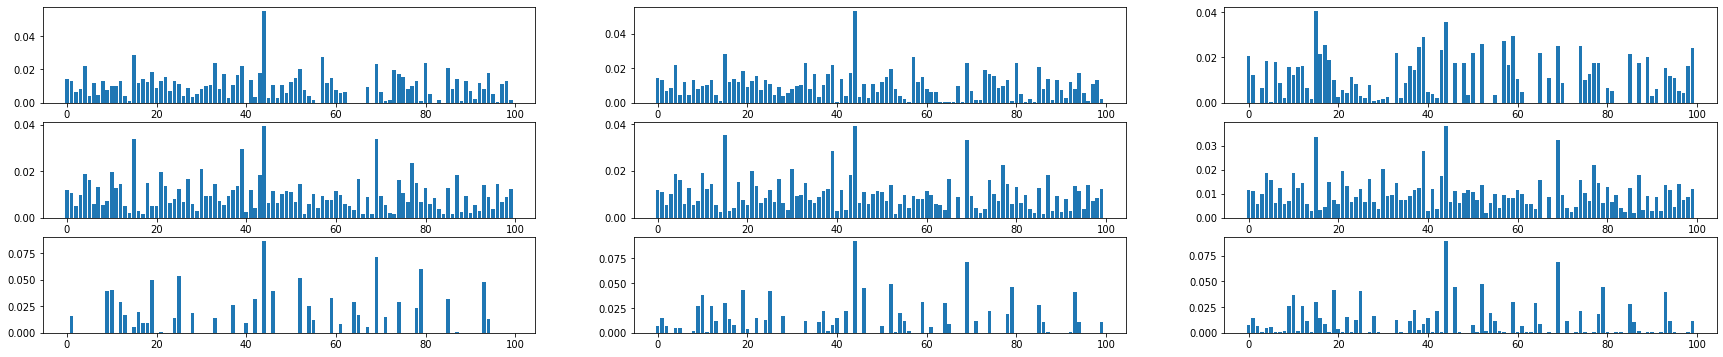

Phase 5
./tmp2/snp500-12_phase05_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


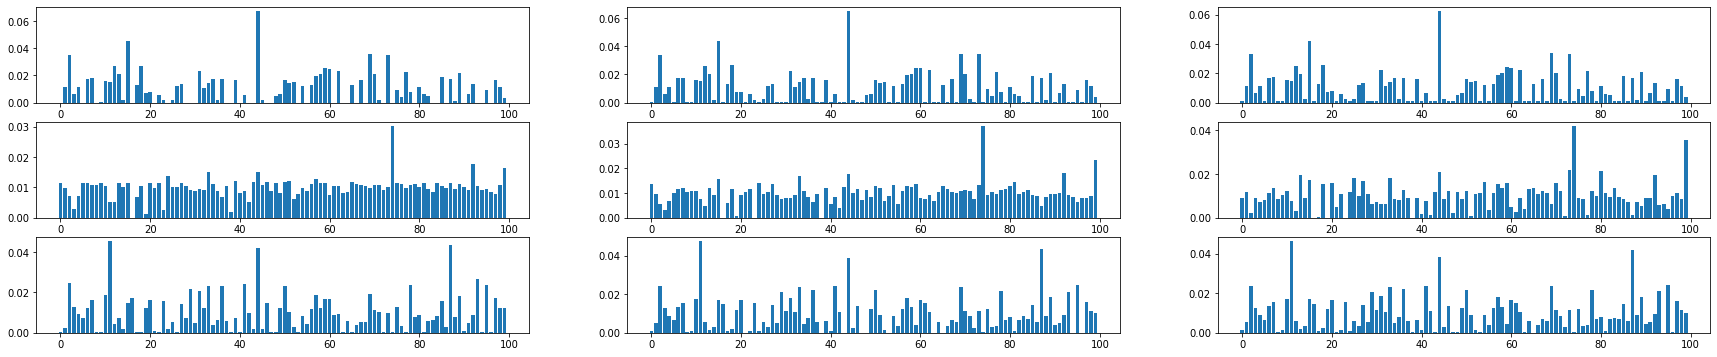

Phase 6
./tmp2/snp500-12_phase06_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


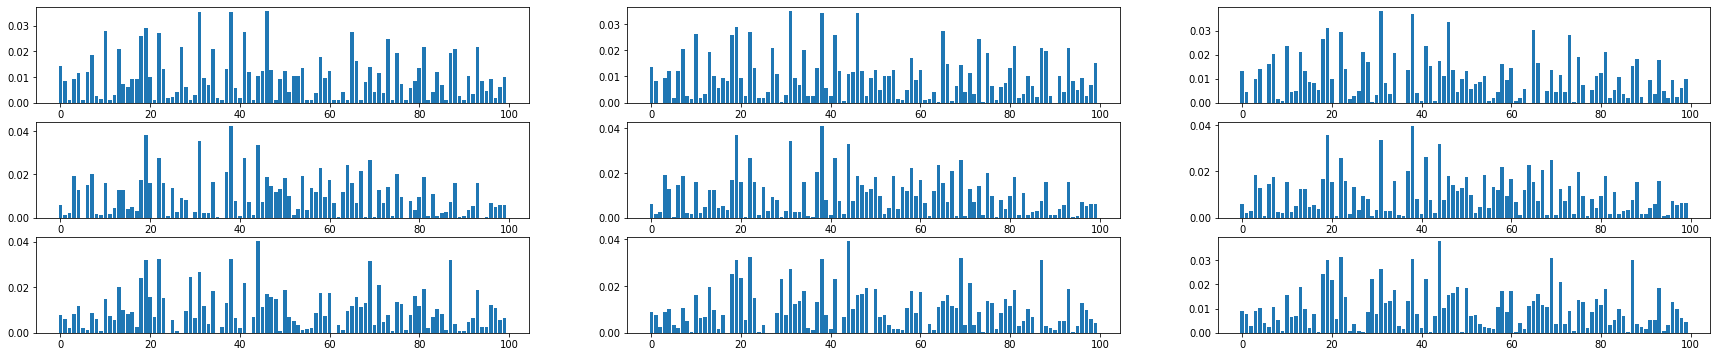

Phase 7
./tmp2/snp500-12_phase07_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


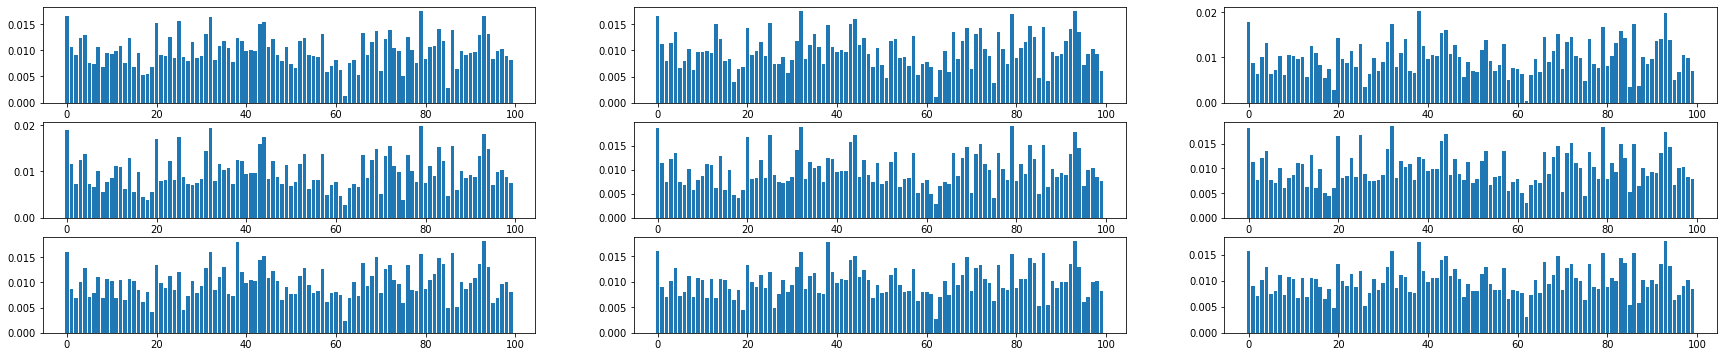

Phase 8
./tmp2/snp500-12_phase08_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


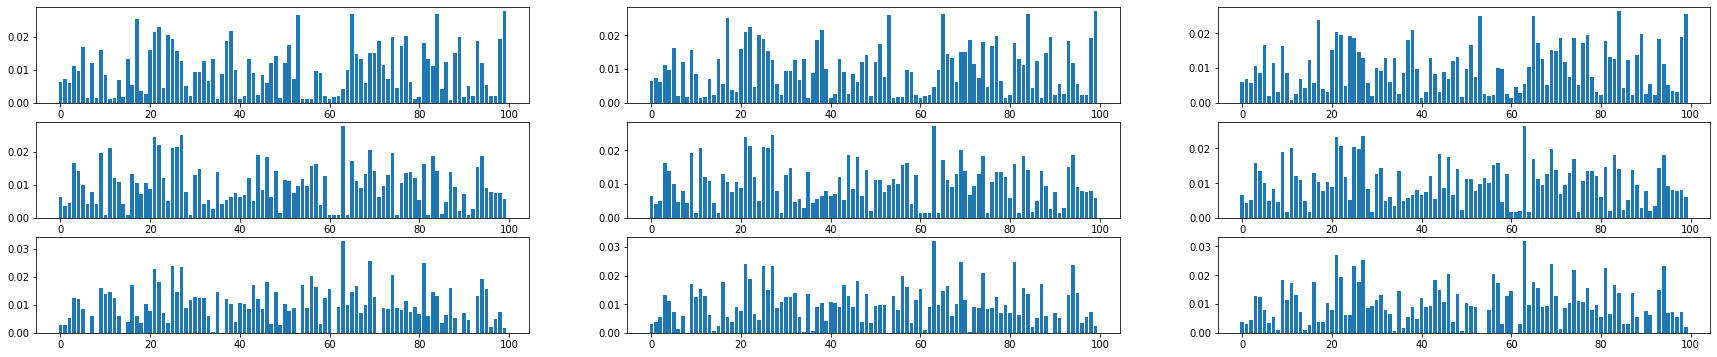

Phase 9
./tmp2/snp500-12_phase09_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


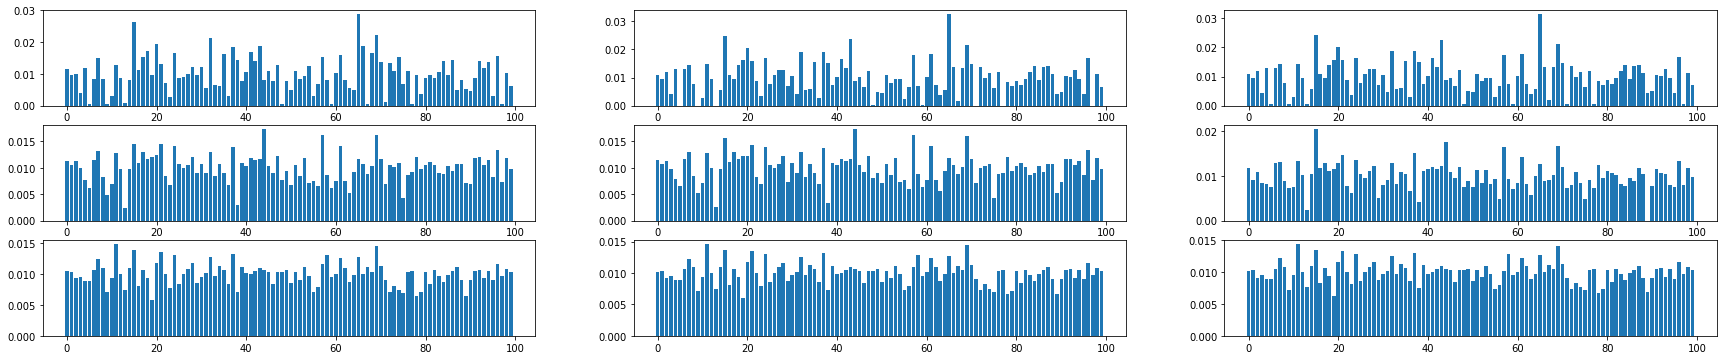

Phase 10
./tmp2/snp500-12_phase10_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


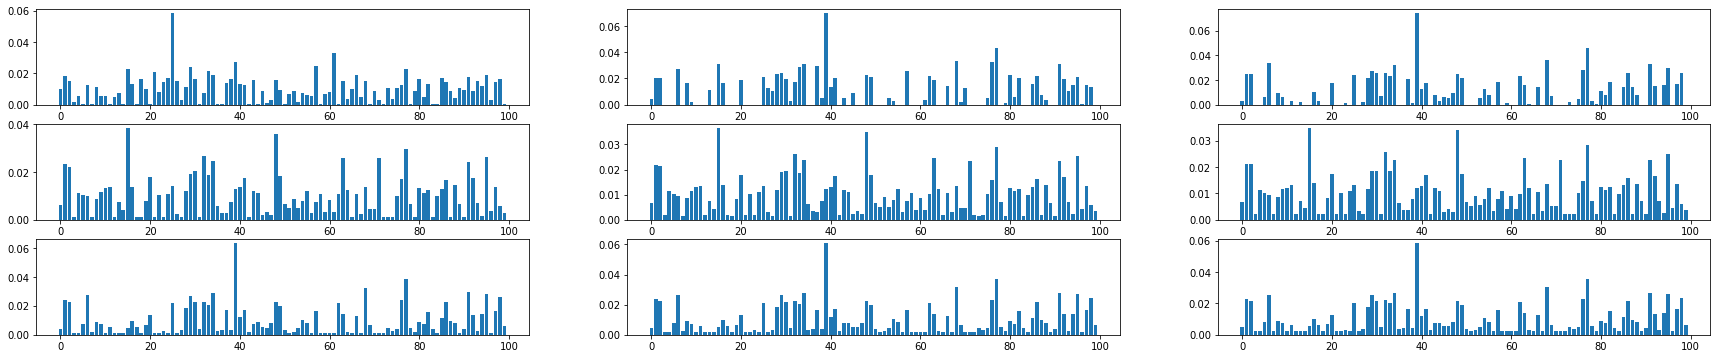

Phase 11
./tmp2/snp500-12_phase11_iter500_subn100_lb5_M50_spearman_dg0.85_invTrue_ggdFalse.npz
G4P_passive
No opt solution: 0 / 100


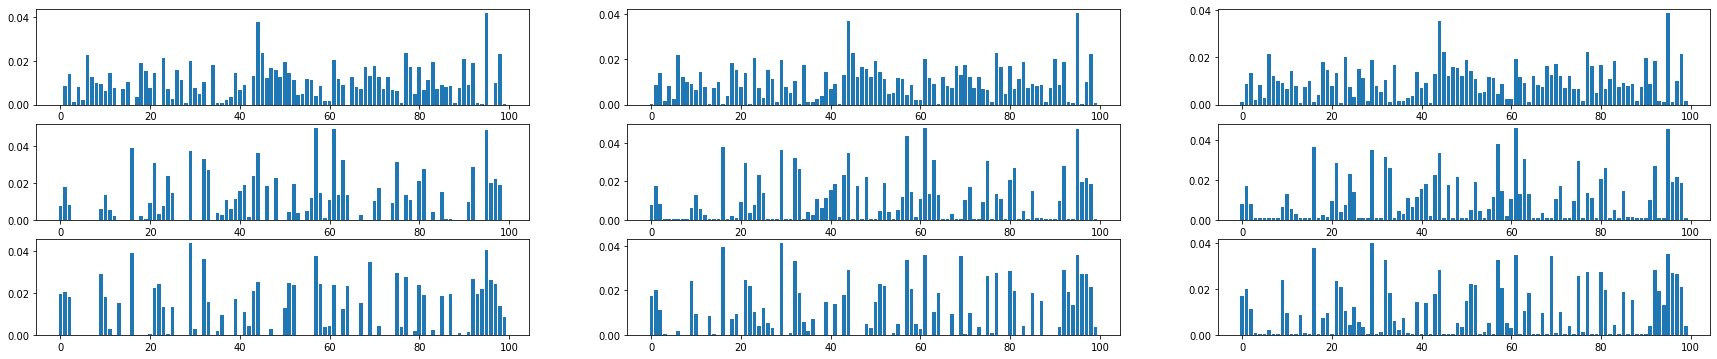

In [23]:
paras={'dataset':'snp500-12', 'maxiter':500, 'subn':100, 'lb':5, 'M':50, 'inverse':'True', 'ggd':'False',
       'c':0.001, 'rf':0.0007, 'gamma':0.01, 'passive_eps':1.0015, 'passive_gamma':0.1,
       'mattype':-2, 'dg':0.85
      }

results, concat_results = run(paras, strategy_lst, phase_cnt=12)
# plot_cumulative_return_history(concat_results, strategy_lst, figsize=(10,5))

G4P_passive
--------------------------------------------------------
fee = 0
Summary:
    Profit factor: 1.29
    Sharpe ratio: 1.54 ± 0.68
    Ulcer index: 6.48
    Information ratio (wrt UCRP): 0.94
    Appraisal ratio (wrt UCRP): 0.55 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 1.00 / 2.147%
    Annualized return: 23.23%
    Annualized volatility: 14.22%
    Longest drawdown: 90 days
    Max drawdown: 17.08%
    Winning days: 58.8%
    Annual turnover: 26.4
        
Total wealth: 2.703840942248315


<Figure size 720x360 with 0 Axes>

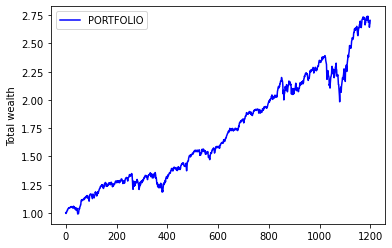

--------------------------------------------------------
fee = 0.002500
Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.08 ± 0.58
    Ulcer index: 3.86
    Information ratio (wrt UCRP): -1.92
    Appraisal ratio (wrt UCRP): -1.11 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 0.99 / -4.345%
    Annualized return: 15.28%
    Annualized volatility: 14.08%
    Longest drawdown: 193 days
    Max drawdown: 18.00%
    Winning days: 57.0%
    Annual turnover: 26.4
        
Total wealth: 1.9678274486606027


<Figure size 720x360 with 0 Axes>

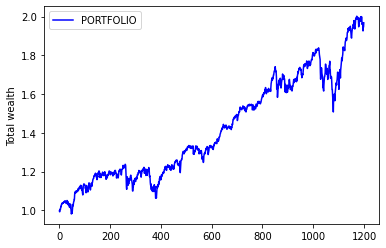

--------------------------------------------------------
fee = 0.005000
Summary:
    Profit factor: 1.10
    Sharpe ratio: 0.61 ± 0.50
    Ulcer index: 1.69
    Information ratio (wrt UCRP): -4.50
    Appraisal ratio (wrt UCRP): -2.67 ± 0.46
    UCRP sharpe: 1.40 ± 0.65
    Beta / Alpha: 0.98 / -10.837%
    Annualized return: 7.83%
    Annualized volatility: 13.95%
    Longest drawdown: 351 days
    Max drawdown: 18.91%
    Winning days: 55.2%
    Annual turnover: 26.4
        
Total wealth: 1.4318491510233593


<Figure size 432x288 with 0 Axes>

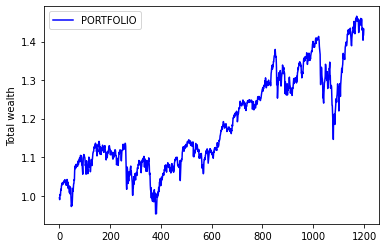

In [24]:
for strategy in strategy_lst:
    strategy_name = strategy.split('(')[0]
    display(strategy_name, concat_results, paras)